# Install Library

In [ ]:
!pip install torch torchvision

# Import Library

In [ ]:
import os
import random
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, RandAugment
from torchvision.models import vit_b_16, ViT_B_16_Weights, vit_l_16, ViT_L_16_Weights
from torch.optim import AdamW

# Menyetel Hyperparameter

In [ ]:
hyperparams = {
    'image_size': 384,
    'randaugment_magnitude': 30,
    'learning_rate': 0.000001,
    'seed': 42,
    'batch_size': 16,
    'optimizer_betas': (0.55, 0.9)
}

## Parameter Fungsi Aktivasi

In [ ]:
activation_functions = {
    'sigmoid': nn.Sigmoid(),
    'hard_sigmoid': nn.Hardsigmoid(),
    'silu': nn.SiLU(),
    'tanh': nn.Tanh(),
    'hard_tanh': nn.Hardtanh(),
    'softsign': nn.Softsign(),
    'relu': nn.ReLU(),
    'leaky_relu': nn.LeakyReLU(),
    'prelu': nn.PReLU(),
    'rrelu': nn.RReLU(),
    'softplus': nn.Softplus(),
    'elu': nn.ELU(),
    'selu': nn.SELU(),
}

# Fungsi untuk mendapatkan fungsi aktivasi
def get_activation_fn(name):
    if name in activation_functions:
        return activation_functions[name]
    else:
        raise ValueError(f"Fungsi aktivasi '{name}' tidak ditemukan. Pilih dari {list(activation_functions.keys())}")

# Menyetel Random Seed

In [ ]:
# Cek Perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(hyperparams['seed'])

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
from zipfile import ZipFile
import os

# Unzip dataset
with ZipFile('/content/drive/MyDrive/Tugas Akhir/dataset/VNPlant_200.zip', 'r') as zip_ref: # atau /content/VNPLANT200.zip
    zip_ref.extractall()

# Load Model ViT

In [ ]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super(ViTFeatureExtractor, self).__init__()
        self.backbone = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
        self.name = "vit_b_16"

        # Memastikan bobot dibekukan dengan requires_grad=False
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Menghapus kepala pengklasifikasi
        self.backbone.heads = nn.Identity()

    def forward(self, x):
        return self.backbone(x)

model = ViTFeatureExtractor().to(device)



Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:22<00:00, 15.7MB/s]


In [ ]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super(ViTFeatureExtractor, self).__init__()
        self.backbone = vit_l_16(weights=ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1)
        self.name = "vit_l_16"

        # Memastikan bobot dibekukan dengan requires_grad=False
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Menghapus kepala pengklasifikasi
        self.backbone.heads = nn.Identity()

    def forward(self, x):
        return self.backbone(x)

activation_fn = get_activation_fn('relu')
model_ViT_L = ViTFeatureExtractor().to(device)

Downloading: "https://download.pytorch.org/models/vit_l_16_swag-4f3808c9.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16_swag-4f3808c9.pth
100%|██████████| 1.14G/1.14G [00:29<00:00, 41.5MB/s]


## Lihat Contoh Augmentasi Data (Tidak Dipakai)

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# Definisikan transformasi tanpa augmentasi (untuk gambar asli)
original_transform = Compose([
    Resize((224, 224)),        # Ubah ukuran gambar sesuai kebutuhan model ViT
    ToTensor(),                # Konversi gambar ke tensor
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisasi
])

# Fungsi untuk denormalisasi tensor ke bentuk gambar asli
def denormalize(tensor):
    tensor = tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return tensor

# Lokasi gambar asli dan gambar hasil augmentasi
original_img_path = '/content/VNPLANT200_Koko_10 kelas/train/Abrus precatorius/54.JPG'
augmented_img_path = '/content/VNPLANT200_Koko_10 kelas/train/Abrus precatorius/54_augmented.JPG'

# Load gambar asli
original_img = Image.open(original_img_path).convert("RGB")
original_tensor = original_transform(original_img)

# Load gambar hasil augmentasi
augmented_img = Image.open(augmented_img_path).convert("RGB")
augmented_tensor = original_transform(augmented_img)  # Tidak melakukan augmentasi lagi, hanya resize dan normalize

# Tampilkan gambar asli dan hasil augmentasi
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Gambar asli
original_tensor_denorm = denormalize(original_tensor)  # Denormalisasi untuk menampilkan gambar dengan warna asli
original_tensor_denorm = original_tensor_denorm.permute(1, 2, 0).numpy()  # Ubah dari CHW ke HWC untuk matplotlib
axes[0].imshow(original_tensor_denorm)
axes[0].set_title('Original Image: 54.JPG')
axes[0].axis('off')

# Gambar hasil augmentasi
augmented_tensor_denorm = denormalize(augmented_tensor)  # Denormalisasi untuk menampilkan gambar dengan warna asli
augmented_tensor_denorm = augmented_tensor_denorm.permute(1, 2, 0).numpy()  # Ubah dari CHW ke HWC untuk matplotlib
axes[1].imshow(augmented_tensor_denorm)
axes[1].set_title('Augmented Image: aug_54.JPG')
axes[1].axis('off')

plt.show()


# Preprocessing Data

## Augmentasi data secara offline

In [ ]:
# Definisikan path direktori asal dan tujuan
train_data_dir = '/content/VNPlant_200_512/train'  # Path asal dataset

# Membuat direktori baru untuk menyimpan hasil augmented jika belum ada
if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)

# Buat augmentasi transform dengan RandAugment
augment_transform = transforms.Compose([
    RandAugment(magnitude=30),
])

# Fungsi untuk melakukan augmentasi dan menyimpan gambar
def augment_and_save(image_path, save_path, num_augments=1):
    image = Image.open(image_path).convert("RGB")  # Buka gambar
    for i in range(num_augments):  # Lakukan augmentasi sebanyak num_augments kali
        augmented_image = augment_transform(image)  # Augmentasi gambar
        augmented_image.save(f"{save_path}_augmented_{i+1}.JPG")  # Simpan hasil augmentasi

# Loop melalui semua gambar di direktori train
for class_folder in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_folder)
    save_class_path = os.path.join(train_data_dir, class_folder)

    if not os.path.exists(save_class_path):  # Buat folder jika belum ada
        os.makedirs(save_class_path)

    for img_file in os.listdir(class_path):
        if img_file.endswith(".JPG"):  # Proses hanya file JPG
            img_path = os.path.join(class_path, img_file)
            save_img_path = os.path.join(save_class_path, img_file.split('.')[0])  # Path penyimpanan gambar hasil augmentasi

            # Lakukan augmentasi dan simpan
            augment_and_save(img_path, save_img_path)

## Transform dataset ke tensor

In [ ]:
hyperparams['image_size'] = 512

In [ ]:
# Preprocessing data yang sesuai dengan model ViT dan augmentasi data
vit_transform = transforms.Compose([
    Resize((hyperparams['image_size'], hyperparams['image_size'])),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load semua gambar
        for class_idx, class_folder in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_folder)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.endswith(".JPG"):
                        img_path = os.path.join(class_path, img_file)
                        self.images.append(img_path)
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def prepare_dataloader(root_dir, batch_size, transform=None, shuffle=True):
    dataset = PlantDataset(root_dir=root_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

train_loader = prepare_dataloader('/content/VNPlant_200_512/train', batch_size=hyperparams['batch_size'], transform=vit_transform)
test_loader = prepare_dataloader('/content/VNPlant_200_512/test', batch_size=hyperparams['batch_size'], transform=vit_transform, shuffle=False)

# Ekstraksi Fitur

In [ ]:
def extract_features(model, data_loader, save_path):
    model.eval()
    final_list = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass to extract features
            features = model(inputs)
            feature_list = features.detach().cpu().numpy()
            label_list = labels.detach().cpu().numpy()

            # Store features and labels in the final list
            for fea, lbl in zip(feature_list, label_list):
                final_list.append([fea, lbl])

    # Save extracted features and labels to a .npy file
    final_list = np.array(final_list, dtype=object)
    with open(save_path, "wb") as f:
        np.save(f, final_list)
    print(f"Features saved to {save_path}")

In [ ]:
train_features_path = '/content/train_data.npy'
test_features_path = '/content/test_data.npy'

extract_features(model_ViT_L, train_loader, train_features_path)
extract_features(model_ViT_L, test_loader, test_features_path)

Features saved to /content/train_data.npy
Features saved to /content/test_data.npy


# Load Feature Data

In [ ]:
train_data = np.load('/content/drive/MyDrive/Tugas Akhir/dataset/ViT-B 16/train_data.npy', allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/Tugas Akhir/dataset/ViT-B 16/test_data.npy', allow_pickle=True)

In [ ]:
train_data = np.load('/content/drive/MyDrive/Tugas Akhir/dataset/ViT-L 16/train_data.npy', allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/Tugas Akhir/dataset/ViT-L 16/test_data.npy', allow_pickle=True)

In [ ]:
class FeatureDataset(Dataset):
    def __init__(self, data):
        self.features = [item[0] for item in data]
        self.labels = [item[1] for item in data]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

# Classifier

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_size=64, num_classes=200, activation_fn='relu'):
        super(SimpleClassifier, self).__init__()

        # Get the activation function
        self.activation_fn = get_activation_fn(activation_fn)

        # Define the classifier with customizable hidden size and activation function
        if hidden_size > 0:
            self.classifier = nn.Sequential(
                nn.Linear(input_dim, hidden_size),
                self.activation_fn,
                nn.Linear(hidden_size, num_classes)
            )
        else:
            self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.classifier(x)

# Data Loader dan Load Model

In [ ]:
batch_size = 16

train_dataset = FeatureDataset(train_data)
test_dataset = FeatureDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Model

In [ ]:
def plot_full_confusion_matrix(cm, num_classes=200):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="Spectral", cbar=True, square=True,
                xticklabels=10, yticklabels=10, cbar_kws={'label': 'Frequency'})
    plt.xlabel("Predicted Classes", fontsize=14)
    plt.ylabel("True Classes", fontsize=14)
    plt.title("Confusion Matrix for Classification Performance of 200 Classes", fontsize=16)
    plt.show()

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    total_correct = 0
    total_samples = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)

    return accuracy, f1, avg_loss, cm

In [ ]:
def train(model, train_loader, test_loader, num_epochs, hyperparams):
    optimizer = AdamW(model.parameters(), lr=hyperparams['learning_rate'], betas=hyperparams['optimizer_betas'])
    criterion = nn.CrossEntropyLoss()
    results = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        all_preds = []
        all_labels = []
        start_time = time.time()  # Mulai menghitung waktu

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Simpan prediksi dan label untuk perhitungan F1 Score
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = total_correct / total_samples
        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        val_acc, val_f1, val_loss, val_cm = evaluate(model, test_loader)

        end_time = time.time()  # Akhiri menghitung waktu
        epoch_time = end_time - start_time  # Hitung waktu per epoch

        results.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'epoch_time': epoch_time
        })


        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Time: {epoch_time:.2f}s")

        if epoch == num_epochs - 1:
            print("Confusion Matrix on Validation Set at Final Epoch:")
            plot_full_confusion_matrix(val_cm)

    results_df = pd.DataFrame(results)
    return results_df

# Pengujian Learning Rate

## Learning rate 10^-6

Epoch 1/100, Train Loss: 5.5838, Train Acc: 0.0049, Train F1: 0.0028, Val Acc: 0.0046, Val F1: 0.0023, Time: 3.45s
Epoch 2/100, Train Loss: 5.4657, Train Acc: 0.0071, Train F1: 0.0048, Val Acc: 0.0076, Val F1: 0.0051, Time: 3.27s
Epoch 3/100, Train Loss: 5.3560, Train Acc: 0.0107, Train F1: 0.0080, Val Acc: 0.0130, Val F1: 0.0095, Time: 2.98s
Epoch 4/100, Train Loss: 5.2535, Train Acc: 0.0161, Train F1: 0.0127, Val Acc: 0.0199, Val F1: 0.0152, Time: 3.03s
Epoch 5/100, Train Loss: 5.1565, Train Acc: 0.0231, Train F1: 0.0191, Val Acc: 0.0301, Val F1: 0.0245, Time: 3.27s
Epoch 6/100, Train Loss: 5.0638, Train Acc: 0.0325, Train F1: 0.0270, Val Acc: 0.0440, Val F1: 0.0353, Time: 3.44s
Epoch 7/100, Train Loss: 4.9748, Train Acc: 0.0428, Train F1: 0.0355, Val Acc: 0.0599, Val F1: 0.0482, Time: 3.01s
Epoch 8/100, Train Loss: 4.8891, Train Acc: 0.0560, Train F1: 0.0468, Val Acc: 0.0808, Val F1: 0.0656, Time: 3.01s
Epoch 9/100, Train Loss: 4.8060, Train Acc: 0.0706, Train F1: 0.0599, Val Acc: 0

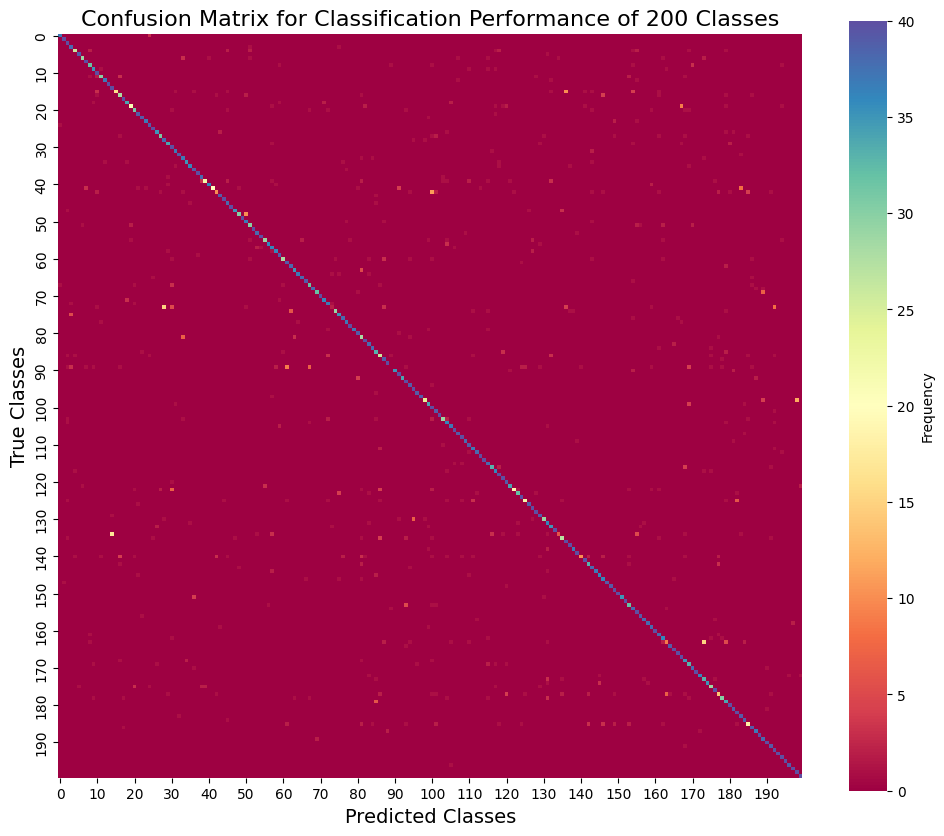

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_6.csv', index=False)

## Learning rate 10^-5

Epoch 1/100, Train Loss: 5.1501, Train Acc: 0.0295, Train F1: 0.0270, Val Acc: 0.1100, Val F1: 0.0882, Time: 3.01s
Epoch 2/100, Train Loss: 4.3428, Train Acc: 0.2020, Train F1: 0.1872, Val Acc: 0.3889, Val F1: 0.3536, Time: 2.98s
Epoch 3/100, Train Loss: 3.7073, Train Acc: 0.4300, Train F1: 0.4129, Val Acc: 0.6001, Val F1: 0.5664, Time: 3.19s
Epoch 4/100, Train Loss: 3.1883, Train Acc: 0.5713, Train F1: 0.5585, Val Acc: 0.7144, Val F1: 0.6897, Time: 3.48s
Epoch 5/100, Train Loss: 2.7656, Train Acc: 0.6601, Train F1: 0.6541, Val Acc: 0.7795, Val F1: 0.7595, Time: 3.03s
Epoch 6/100, Train Loss: 2.4247, Train Acc: 0.7110, Train F1: 0.7074, Val Acc: 0.8204, Val F1: 0.8051, Time: 2.99s
Epoch 7/100, Train Loss: 2.1503, Train Acc: 0.7462, Train F1: 0.7441, Val Acc: 0.8439, Val F1: 0.8299, Time: 2.98s
Epoch 8/100, Train Loss: 1.9303, Train Acc: 0.7697, Train F1: 0.7693, Val Acc: 0.8628, Val F1: 0.8507, Time: 3.64s
Epoch 9/100, Train Loss: 1.7526, Train Acc: 0.7895, Train F1: 0.7900, Val Acc: 0

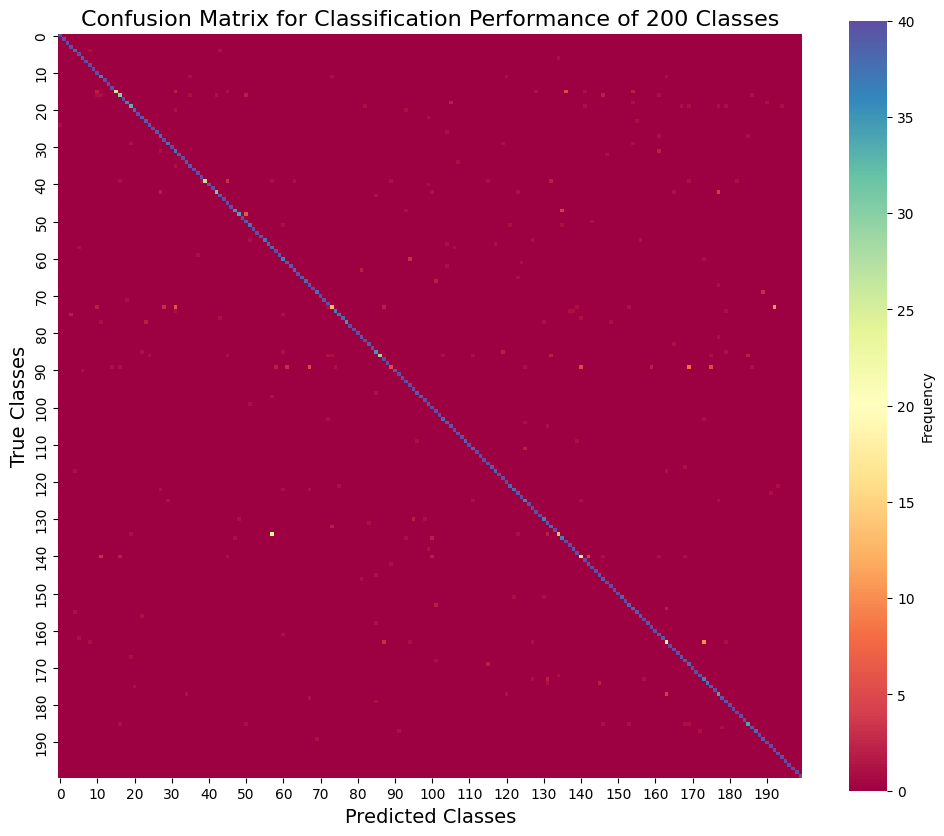

In [ ]:
hyperparams['learning_rate'] = 1e-5
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_5.csv', index=False)

## Learning rate 10^-4

Epoch 1/100, Train Loss: 2.9899, Train Acc: 0.5092, Train F1: 0.5123, Val Acc: 0.8532, Val F1: 0.8414, Time: 3.56s
Epoch 2/100, Train Loss: 1.2435, Train Acc: 0.8183, Train F1: 0.8203, Val Acc: 0.9143, Val F1: 0.9073, Time: 3.01s
Epoch 3/100, Train Loss: 0.8947, Train Acc: 0.8590, Train F1: 0.8619, Val Acc: 0.9301, Val F1: 0.9244, Time: 2.98s
Epoch 4/100, Train Loss: 0.7473, Train Acc: 0.8804, Train F1: 0.8832, Val Acc: 0.9399, Val F1: 0.9336, Time: 2.98s
Epoch 5/100, Train Loss: 0.6631, Train Acc: 0.8923, Train F1: 0.8949, Val Acc: 0.9447, Val F1: 0.9402, Time: 3.55s
Epoch 6/100, Train Loss: 0.6037, Train Acc: 0.9017, Train F1: 0.9040, Val Acc: 0.9491, Val F1: 0.9456, Time: 3.09s
Epoch 7/100, Train Loss: 0.5593, Train Acc: 0.9085, Train F1: 0.9107, Val Acc: 0.9509, Val F1: 0.9465, Time: 2.98s
Epoch 8/100, Train Loss: 0.5248, Train Acc: 0.9147, Train F1: 0.9168, Val Acc: 0.9520, Val F1: 0.9490, Time: 2.99s
Epoch 9/100, Train Loss: 0.4948, Train Acc: 0.9194, Train F1: 0.9210, Val Acc: 0

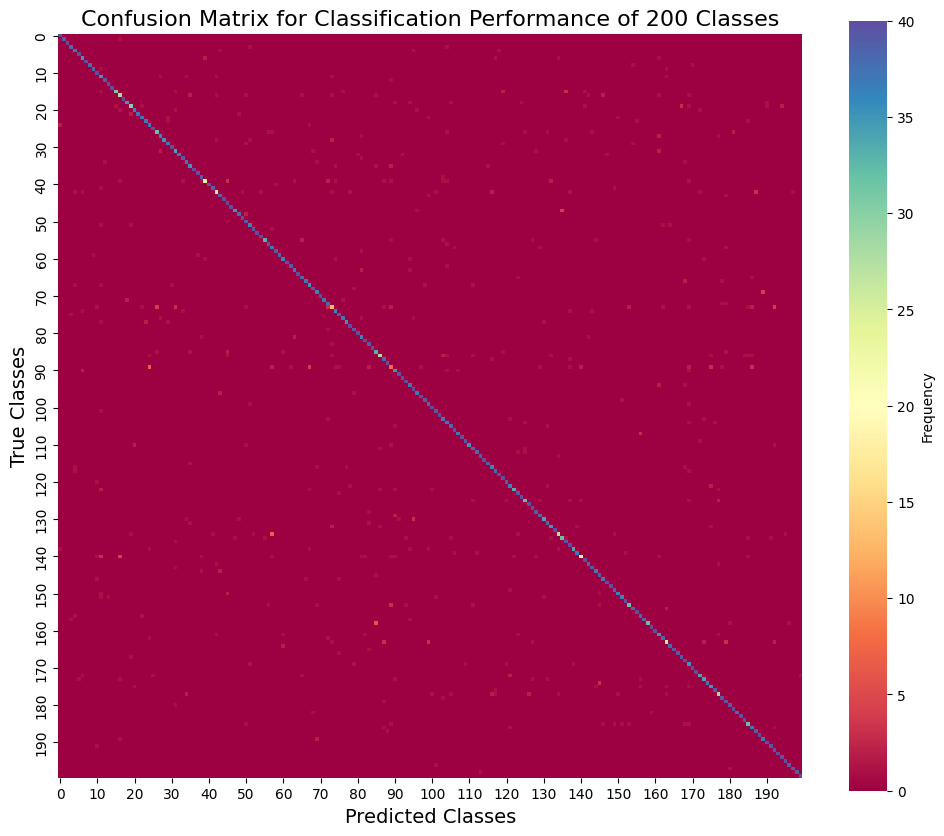

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4.csv', index=False)

## Learning rate 10^-3

Epoch 1/100, Train Loss: 1.1938, Train Acc: 0.7599, Train F1: 0.7614, Val Acc: 0.9373, Val F1: 0.9335, Time: 3.41s
Epoch 2/100, Train Loss: 0.5094, Train Acc: 0.8902, Train F1: 0.8912, Val Acc: 0.9521, Val F1: 0.9502, Time: 2.98s
Epoch 3/100, Train Loss: 0.3892, Train Acc: 0.9164, Train F1: 0.9171, Val Acc: 0.9526, Val F1: 0.9508, Time: 2.97s
Epoch 4/100, Train Loss: 0.3304, Train Acc: 0.9288, Train F1: 0.9294, Val Acc: 0.9529, Val F1: 0.9512, Time: 3.09s
Epoch 5/100, Train Loss: 0.2853, Train Acc: 0.9386, Train F1: 0.9390, Val Acc: 0.9493, Val F1: 0.9471, Time: 3.59s
Epoch 6/100, Train Loss: 0.2554, Train Acc: 0.9446, Train F1: 0.9451, Val Acc: 0.9474, Val F1: 0.9454, Time: 2.96s
Epoch 7/100, Train Loss: 0.2304, Train Acc: 0.9491, Train F1: 0.9494, Val Acc: 0.9447, Val F1: 0.9434, Time: 2.97s
Epoch 8/100, Train Loss: 0.2095, Train Acc: 0.9532, Train F1: 0.9535, Val Acc: 0.9465, Val F1: 0.9453, Time: 2.99s
Epoch 9/100, Train Loss: 0.1959, Train Acc: 0.9564, Train F1: 0.9567, Val Acc: 0

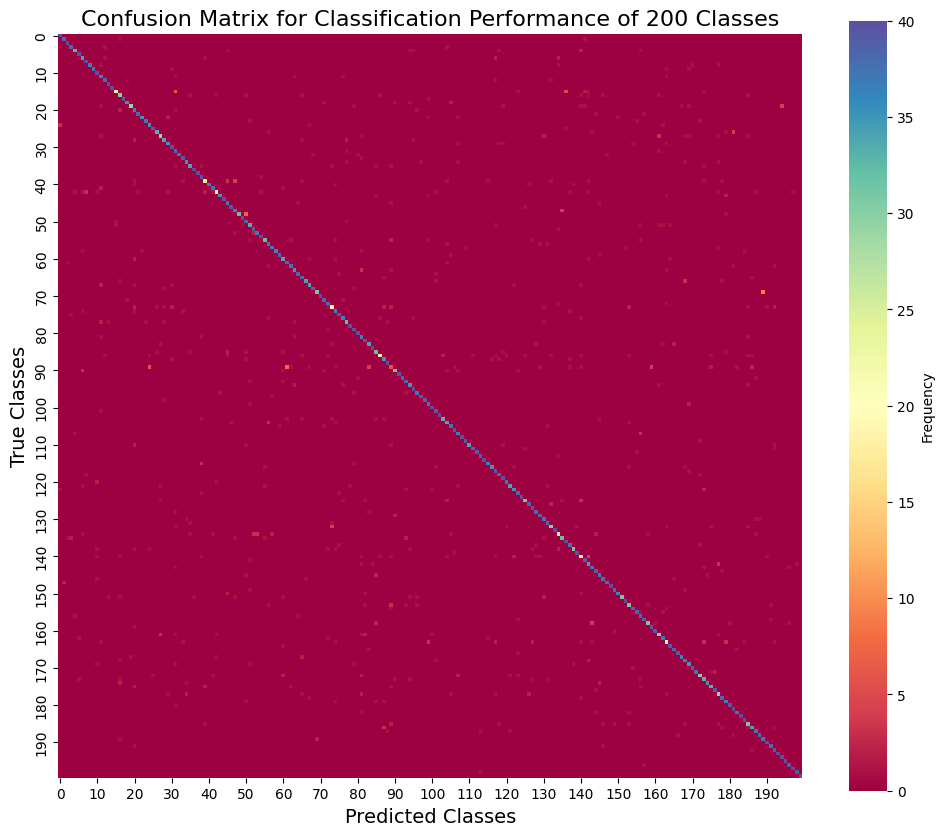

In [ ]:
hyperparams['learning_rate'] = 1e-3
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_3.csv', index=False)

### Grafik Pengujian

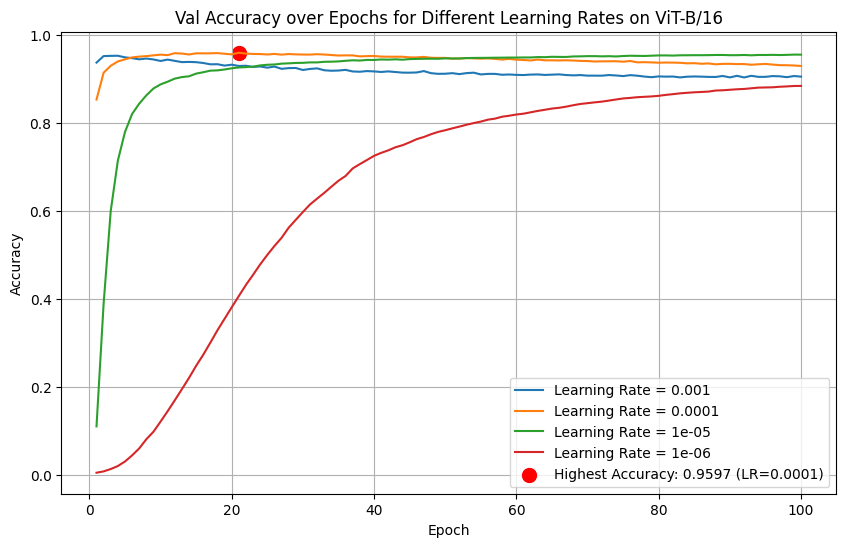

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_3.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_4.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_5.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_6.csv'       # Misalnya file hasil untuk learning rate 1
]

# Variabel untuk menyimpan label learning rate untuk setiap file
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_accuracy = 0
highest_epoch = 0
highest_lr = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    accuracy = data['val_acc']

    # Plot akurasi vs epoch
    plt.plot(epochs, accuracy, label=f'Learning Rate = {learning_rates[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_accuracy = accuracy.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_accuracy > highest_accuracy:
        highest_accuracy = max_accuracy
        highest_epoch = max_epoch
        highest_lr = learning_rates[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_accuracy, color='red', s=100, label=f'Highest Accuracy: {highest_accuracy:.4f} (LR={highest_lr})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy over Epochs for Different Learning Rates on ViT-B/16')
plt.legend()
plt.grid(True)
plt.show()


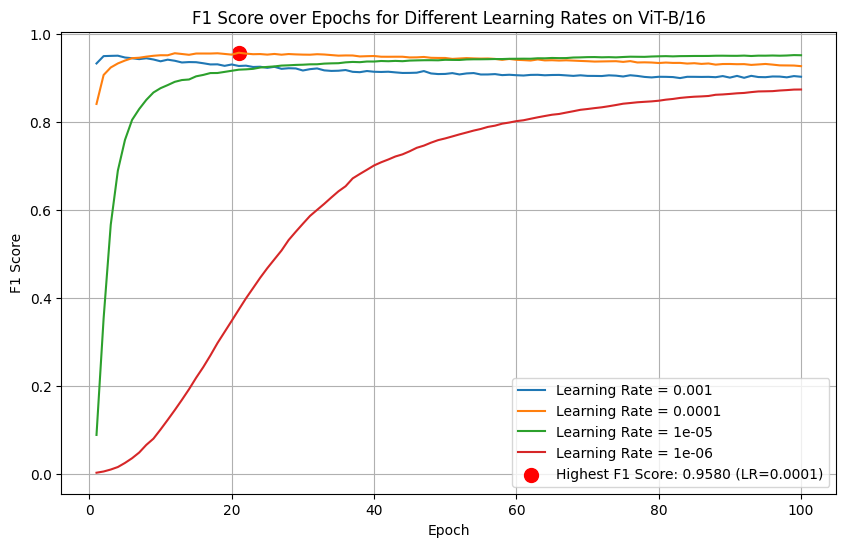

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_3.csv',
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_4.csv',
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_5.csv',
    '/content/Hasil Pengujian VIT B/Learningrate/training_results_learning_rate_6.csv'
]

# Variabel untuk menyimpan label learning rate untuk setiap file
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_f1_score = 0
highest_epoch = 0
highest_lr = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    f1_scores = data['val_f1']

    # Plot akurasi vs epoch
    plt.plot(epochs, f1_scores, label=f'Learning Rate = {learning_rates[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_f1_score = f1_scores.max()
    max_epoch = epochs[f1_scores.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_f1_score > highest_f1_score:
        highest_f1_score = max_f1_score
        highest_epoch = max_epoch
        highest_lr= learning_rates[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_f1_score, color='red', s=100, label=f'Highest F1 Score: {highest_f1_score:.4f} (LR={highest_lr})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs for Different Learning Rates on ViT-B/16')
plt.legend()
plt.grid(True)
plt.show()


# Pengujian Jumlah Neuron

## 64 Neuron

Epoch 1/50, Train Loss: 3.9508, Train Acc: 0.2624, Train F1: 0.2662, Val Acc: 0.6409, Val F1: 0.6094, Time: 4.59s
Epoch 2/50, Train Loss: 1.8584, Train Acc: 0.6598, Train F1: 0.6540, Val Acc: 0.7995, Val F1: 0.7875, Time: 3.21s
Epoch 3/50, Train Loss: 1.1835, Train Acc: 0.7670, Train F1: 0.7663, Val Acc: 0.8566, Val F1: 0.8493, Time: 3.27s
Epoch 4/50, Train Loss: 0.9029, Train Acc: 0.8128, Train F1: 0.8126, Val Acc: 0.8832, Val F1: 0.8761, Time: 3.59s
Epoch 5/50, Train Loss: 0.7475, Train Acc: 0.8407, Train F1: 0.8412, Val Acc: 0.8971, Val F1: 0.8907, Time: 3.72s
Epoch 6/50, Train Loss: 0.6439, Train Acc: 0.8596, Train F1: 0.8600, Val Acc: 0.9066, Val F1: 0.9002, Time: 3.22s
Epoch 7/50, Train Loss: 0.5684, Train Acc: 0.8762, Train F1: 0.8766, Val Acc: 0.9130, Val F1: 0.9084, Time: 3.25s
Epoch 8/50, Train Loss: 0.5099, Train Acc: 0.8887, Train F1: 0.8890, Val Acc: 0.9167, Val F1: 0.9115, Time: 3.66s
Epoch 9/50, Train Loss: 0.4622, Train Acc: 0.8975, Train F1: 0.8979, Val Acc: 0.9223, Va

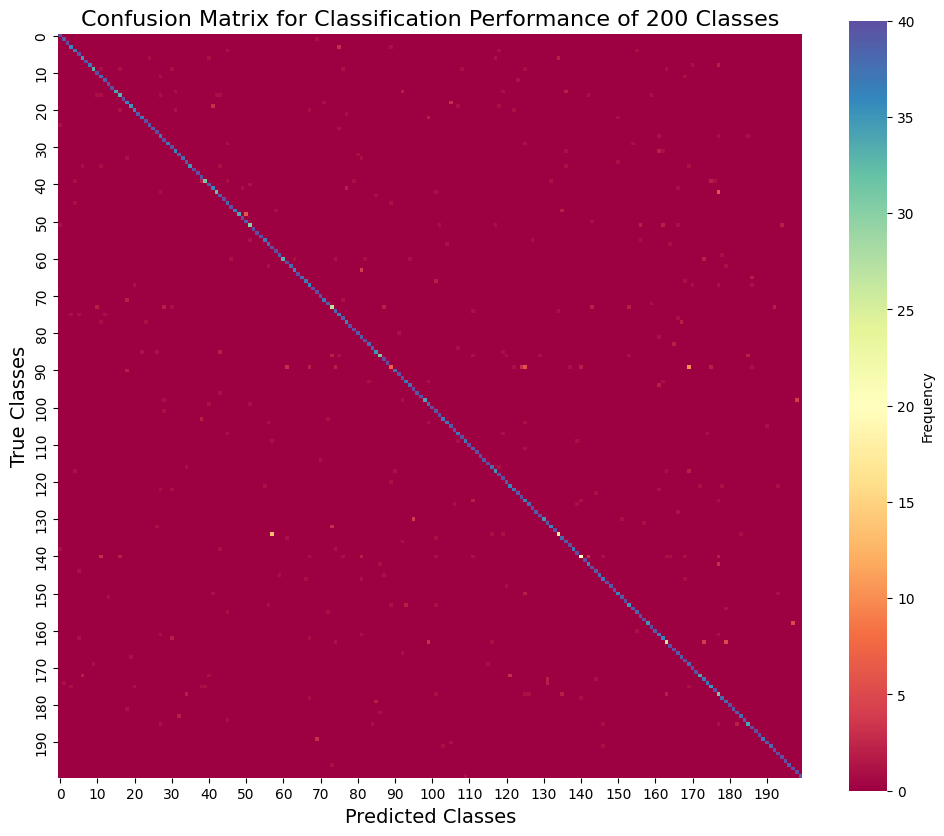

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=64, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_5_64_neuron.csv', index=False)

## 128 Neuron

Epoch 1/50, Train Loss: 3.3231, Train Acc: 0.4153, Train F1: 0.4274, Val Acc: 0.7698, Val F1: 0.7480, Time: 4.05s
Epoch 2/50, Train Loss: 1.2540, Train Acc: 0.7678, Train F1: 0.7664, Val Acc: 0.8715, Val F1: 0.8604, Time: 4.94s
Epoch 3/50, Train Loss: 0.8097, Train Acc: 0.8337, Train F1: 0.8340, Val Acc: 0.9004, Val F1: 0.8919, Time: 6.53s
Epoch 4/50, Train Loss: 0.6238, Train Acc: 0.8680, Train F1: 0.8688, Val Acc: 0.9145, Val F1: 0.9091, Time: 6.54s
Epoch 5/50, Train Loss: 0.5138, Train Acc: 0.8898, Train F1: 0.8903, Val Acc: 0.9261, Val F1: 0.9216, Time: 3.42s
Epoch 6/50, Train Loss: 0.4369, Train Acc: 0.9059, Train F1: 0.9063, Val Acc: 0.9325, Val F1: 0.9281, Time: 3.51s
Epoch 7/50, Train Loss: 0.3820, Train Acc: 0.9166, Train F1: 0.9170, Val Acc: 0.9370, Val F1: 0.9347, Time: 3.92s
Epoch 8/50, Train Loss: 0.3369, Train Acc: 0.9267, Train F1: 0.9270, Val Acc: 0.9390, Val F1: 0.9358, Time: 3.34s
Epoch 9/50, Train Loss: 0.3016, Train Acc: 0.9345, Train F1: 0.9347, Val Acc: 0.9446, Va

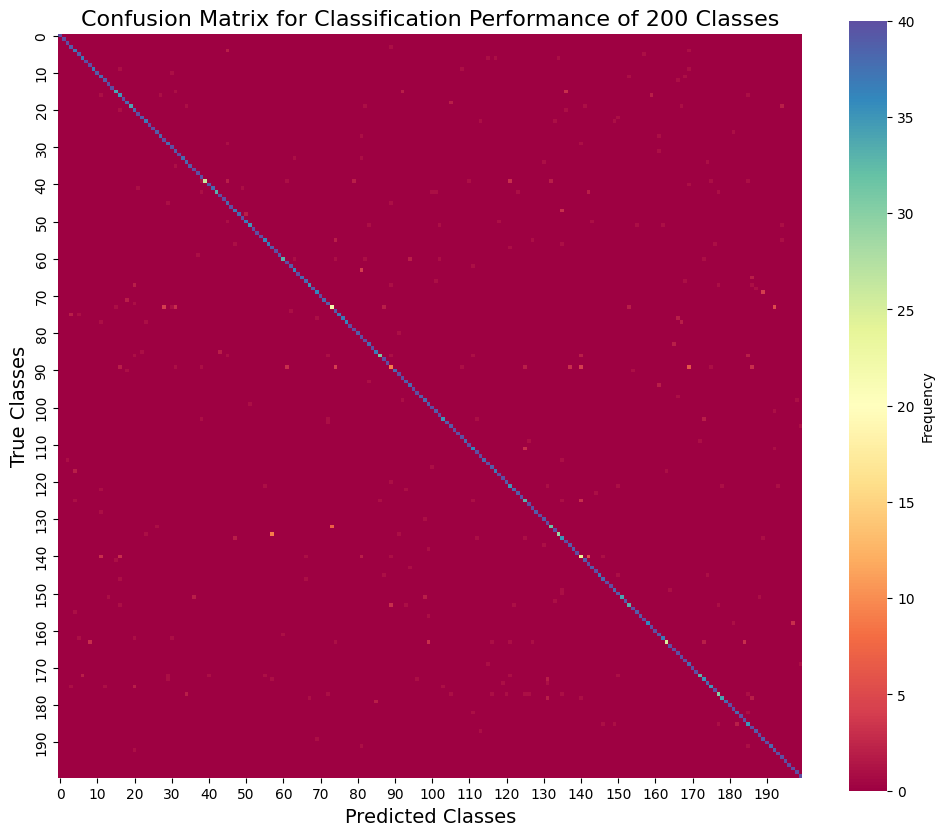

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=128, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_5_128_neuron.csv', index=False)

## 256 Neuron

Epoch 1/50, Train Loss: 2.7174, Train Acc: 0.5275, Train F1: 0.5349, Val Acc: 0.8515, Val F1: 0.8424, Time: 3.64s
Epoch 2/50, Train Loss: 0.8939, Train Acc: 0.8221, Train F1: 0.8223, Val Acc: 0.8996, Val F1: 0.8914, Time: 3.49s
Epoch 3/50, Train Loss: 0.5950, Train Acc: 0.8724, Train F1: 0.8727, Val Acc: 0.9235, Val F1: 0.9190, Time: 3.40s
Epoch 4/50, Train Loss: 0.4574, Train Acc: 0.9010, Train F1: 0.9014, Val Acc: 0.9345, Val F1: 0.9300, Time: 4.02s
Epoch 5/50, Train Loss: 0.3708, Train Acc: 0.9180, Train F1: 0.9182, Val Acc: 0.9435, Val F1: 0.9412, Time: 3.39s
Epoch 6/50, Train Loss: 0.3121, Train Acc: 0.9307, Train F1: 0.9310, Val Acc: 0.9486, Val F1: 0.9464, Time: 3.65s
Epoch 7/50, Train Loss: 0.2666, Train Acc: 0.9419, Train F1: 0.9420, Val Acc: 0.9493, Val F1: 0.9466, Time: 3.51s
Epoch 8/50, Train Loss: 0.2298, Train Acc: 0.9496, Train F1: 0.9498, Val Acc: 0.9503, Val F1: 0.9474, Time: 3.83s
Epoch 9/50, Train Loss: 0.2024, Train Acc: 0.9560, Train F1: 0.9561, Val Acc: 0.9550, Va

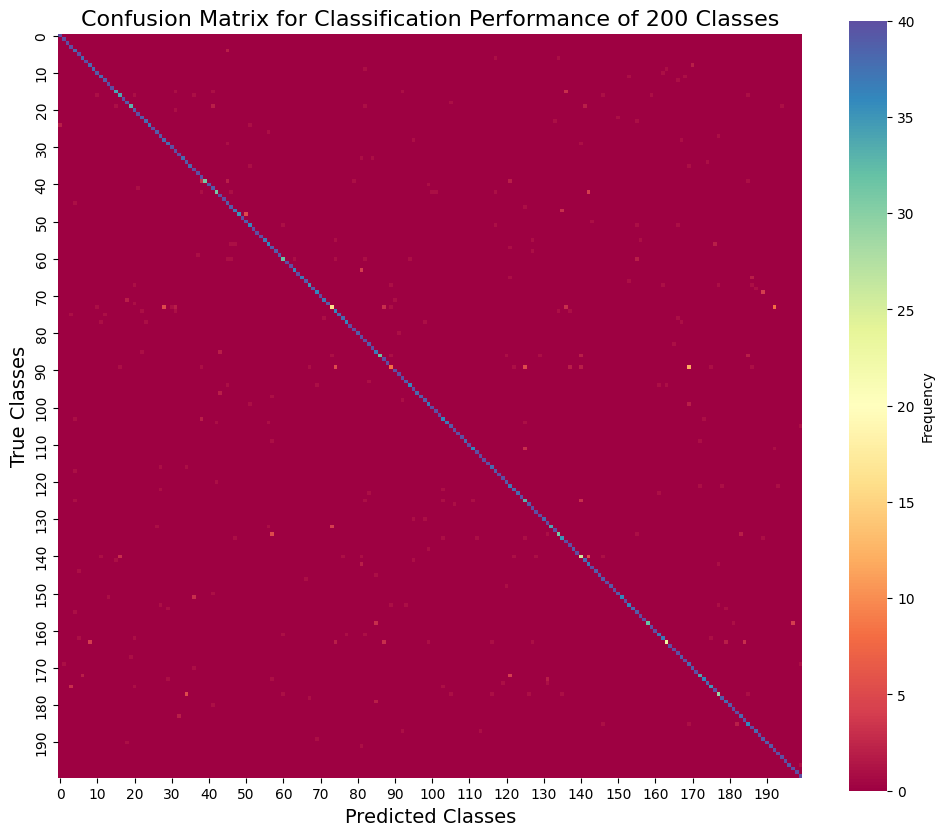

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_5_256_neuron.csv', index=False)

## 512 Neuron

Epoch 1/50, Train Loss: 2.1594, Train Acc: 0.6124, Train F1: 0.6181, Val Acc: 0.8918, Val F1: 0.8836, Time: 6.14s
Epoch 2/50, Train Loss: 0.6831, Train Acc: 0.8529, Train F1: 0.8534, Val Acc: 0.9249, Val F1: 0.9209, Time: 8.57s
Epoch 3/50, Train Loss: 0.4606, Train Acc: 0.8957, Train F1: 0.8960, Val Acc: 0.9414, Val F1: 0.9369, Time: 4.51s
Epoch 4/50, Train Loss: 0.3450, Train Acc: 0.9219, Train F1: 0.9221, Val Acc: 0.9481, Val F1: 0.9464, Time: 3.43s
Epoch 5/50, Train Loss: 0.2743, Train Acc: 0.9368, Train F1: 0.9369, Val Acc: 0.9521, Val F1: 0.9500, Time: 4.06s
Epoch 6/50, Train Loss: 0.2251, Train Acc: 0.9491, Train F1: 0.9492, Val Acc: 0.9505, Val F1: 0.9489, Time: 3.50s
Epoch 7/50, Train Loss: 0.1884, Train Acc: 0.9571, Train F1: 0.9572, Val Acc: 0.9543, Val F1: 0.9523, Time: 3.43s
Epoch 8/50, Train Loss: 0.1600, Train Acc: 0.9637, Train F1: 0.9638, Val Acc: 0.9559, Val F1: 0.9540, Time: 3.39s
Epoch 9/50, Train Loss: 0.1371, Train Acc: 0.9695, Train F1: 0.9696, Val Acc: 0.9550, Va

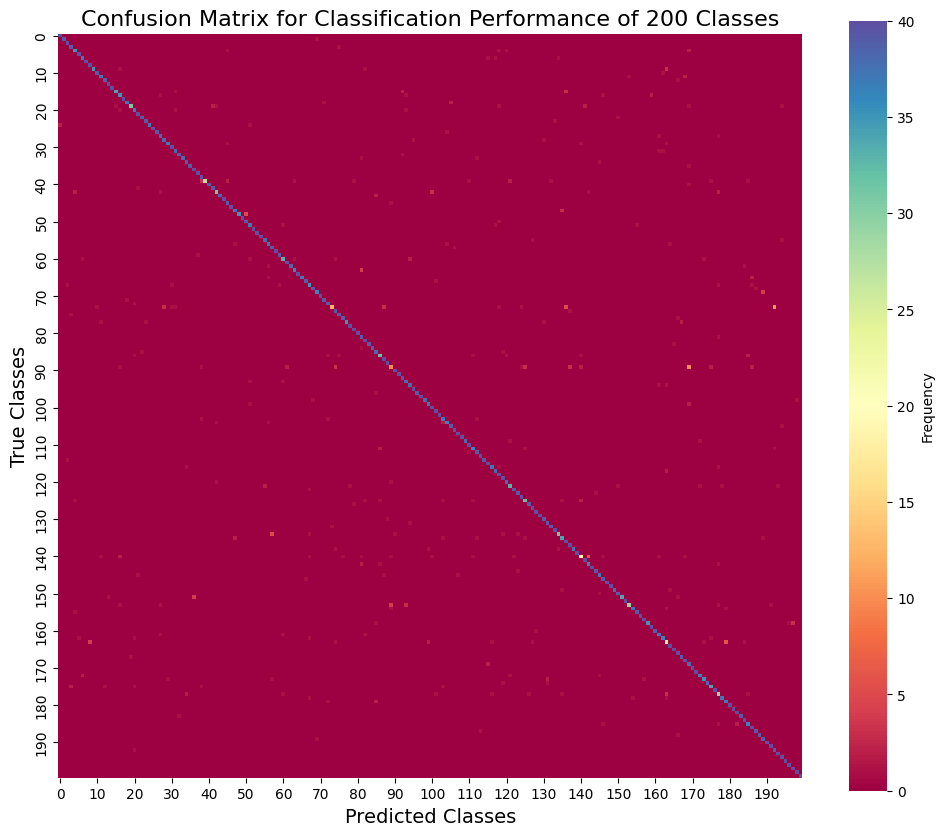

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=512, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_5_512_neuron.csv', index=False)

## 1024 Neuron

Epoch 1/50, Train Loss: 1.7445, Train Acc: 0.6738, Train F1: 0.6779, Val Acc: 0.9039, Val F1: 0.8976, Time: 4.06s
Epoch 2/50, Train Loss: 0.5425, Train Acc: 0.8753, Train F1: 0.8756, Val Acc: 0.9406, Val F1: 0.9361, Time: 3.87s
Epoch 3/50, Train Loss: 0.3566, Train Acc: 0.9156, Train F1: 0.9158, Val Acc: 0.9469, Val F1: 0.9439, Time: 3.54s
Epoch 4/50, Train Loss: 0.2601, Train Acc: 0.9390, Train F1: 0.9391, Val Acc: 0.9484, Val F1: 0.9465, Time: 3.61s
Epoch 5/50, Train Loss: 0.2033, Train Acc: 0.9521, Train F1: 0.9522, Val Acc: 0.9500, Val F1: 0.9481, Time: 4.28s
Epoch 6/50, Train Loss: 0.1621, Train Acc: 0.9606, Train F1: 0.9607, Val Acc: 0.9539, Val F1: 0.9519, Time: 3.55s
Epoch 7/50, Train Loss: 0.1325, Train Acc: 0.9691, Train F1: 0.9691, Val Acc: 0.9545, Val F1: 0.9534, Time: 3.62s
Epoch 8/50, Train Loss: 0.1119, Train Acc: 0.9747, Train F1: 0.9747, Val Acc: 0.9586, Val F1: 0.9568, Time: 3.91s
Epoch 9/50, Train Loss: 0.0952, Train Acc: 0.9779, Train F1: 0.9779, Val Acc: 0.9535, Va

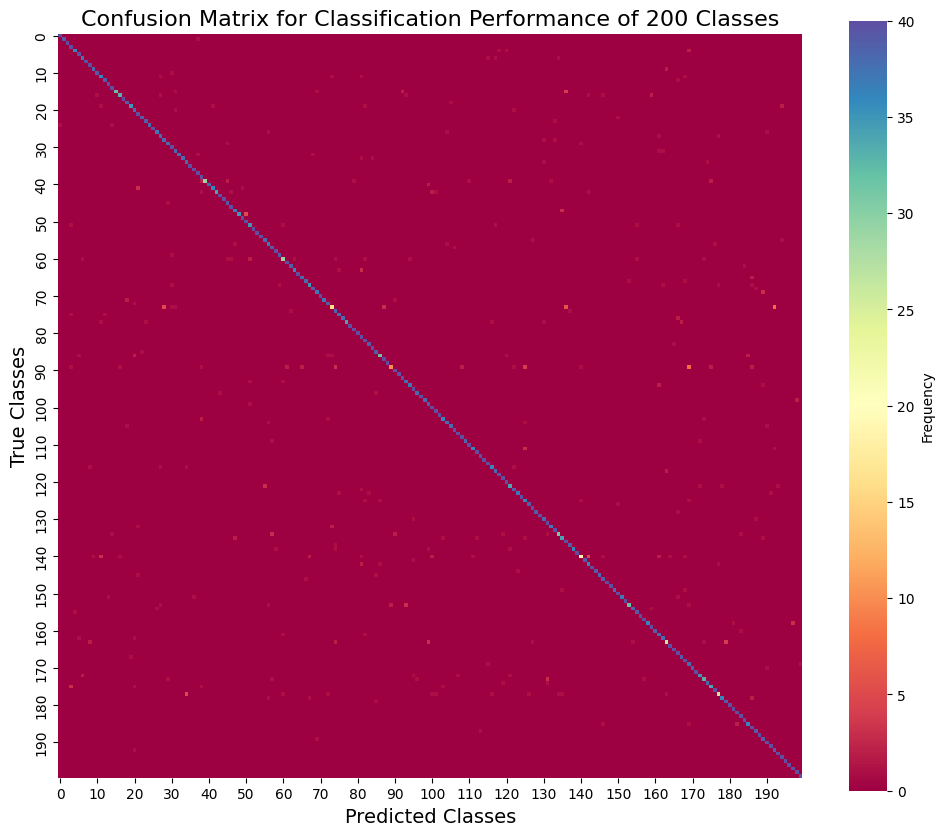

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_5_1024_neuron.csv', index=False)

### Grafik Pengujian Neuron


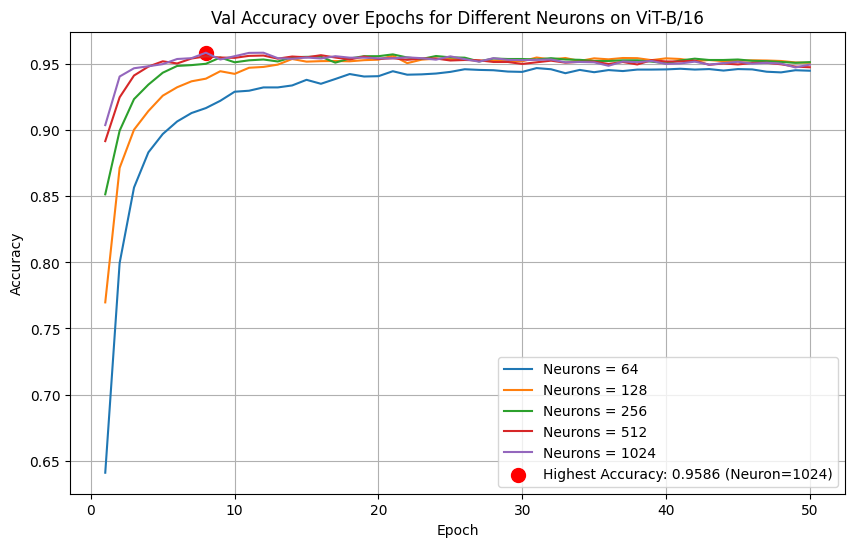

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_5_64_neuron.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/training_results_learning_rate_5_128_neuron.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/training_results_learning_rate_5_256_neuron.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/training_results_learning_rate_5_512_neuron.csv',       # Misalnya file hasil untuk learning rate 1
    '/content/training_results_learning_rate_5_1024_neuron.csv'
]

# Variabel untuk menyimpan label learning rate untuk setiap file
neurons = [64, 128, 256, 512, 1024]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_accuracy = 0
highest_epoch = 0
highest_lr = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    accuracy = data['val_acc']

    # Plot akurasi vs epoch
    plt.plot(epochs, accuracy, label=f'Neurons = {neurons[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_accuracy = accuracy.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_accuracy > highest_accuracy:
        highest_accuracy = max_accuracy
        highest_epoch = max_epoch
        highest_neuron = neurons[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_accuracy, color='red', s=100, label=f'Highest Accuracy: {highest_accuracy:.4f} (Neuron={highest_neuron})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy over Epochs for Different Neurons on ViT-B/16')
plt.legend()
plt.grid(True)
plt.show()


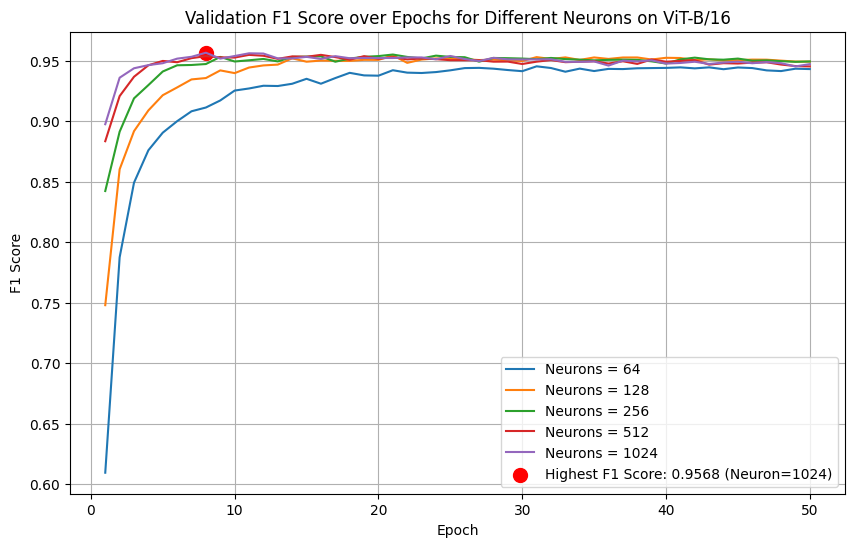

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_5_64_neuron.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/training_results_learning_rate_5_128_neuron.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/training_results_learning_rate_5_256_neuron.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/training_results_learning_rate_5_512_neuron.csv',       # Misalnya file hasil untuk learning rate 1
    '/content/training_results_learning_rate_5_1024_neuron.csv'
]

# Variabel untuk menyimpan label neuron untuk setiap file
neurons = [64, 128, 256, 512, 1024]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai F1-score dan epoch tertinggi secara keseluruhan
highest_f1_score = 0
highest_epoch = 0
highest_neuron = None

# Loop untuk memuat setiap file CSV, lalu plot data F1-score vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'val_f1'
    epochs = data['epoch']
    f1_scores = data['val_f1']  # Pastikan kolom ini sesuai dengan nama kolom dalam file CSV Anda

    # Plot F1-score vs epoch
    plt.plot(epochs, f1_scores, label=f'Neurons = {neurons[i]}')

    # Menemukan F1-score tertinggi dalam file ini
    max_f1_score = f1_scores.max()
    max_epoch = epochs[f1_scores.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_f1_score > highest_f1_score:
        highest_f1_score = max_f1_score
        highest_epoch = max_epoch
        highest_neuron = neurons[i]

# Menambahkan tanda titik untuk F1-score tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_f1_score, color='red', s=100, label=f'Highest F1 Score: {highest_f1_score:.4f} (Neuron={highest_neuron})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score over Epochs for Different Neurons on ViT-B/16')
plt.legend()
plt.grid(True)
plt.show()


# Pengujian Fungsi Aktivasi

## Sigmoid

Epoch 1/50, Train Loss: 3.5538, Train Acc: 0.4370, Train F1: 0.4446, Val Acc: 0.7875, Val F1: 0.7673, Time: 4.89s
Epoch 2/50, Train Loss: 1.3599, Train Acc: 0.7841, Train F1: 0.7814, Val Acc: 0.8936, Val F1: 0.8849, Time: 3.54s
Epoch 3/50, Train Loss: 0.7709, Train Acc: 0.8574, Train F1: 0.8574, Val Acc: 0.9165, Val F1: 0.9101, Time: 3.53s
Epoch 4/50, Train Loss: 0.5559, Train Acc: 0.8857, Train F1: 0.8859, Val Acc: 0.9280, Val F1: 0.9224, Time: 3.80s
Epoch 5/50, Train Loss: 0.4391, Train Acc: 0.9067, Train F1: 0.9069, Val Acc: 0.9359, Val F1: 0.9315, Time: 4.24s
Epoch 6/50, Train Loss: 0.3635, Train Acc: 0.9225, Train F1: 0.9227, Val Acc: 0.9443, Val F1: 0.9406, Time: 3.52s
Epoch 7/50, Train Loss: 0.3072, Train Acc: 0.9361, Train F1: 0.9363, Val Acc: 0.9445, Val F1: 0.9406, Time: 3.66s
Epoch 8/50, Train Loss: 0.2691, Train Acc: 0.9435, Train F1: 0.9436, Val Acc: 0.9519, Val F1: 0.9493, Time: 4.16s
Epoch 9/50, Train Loss: 0.2346, Train Acc: 0.9525, Train F1: 0.9526, Val Acc: 0.9515, Va

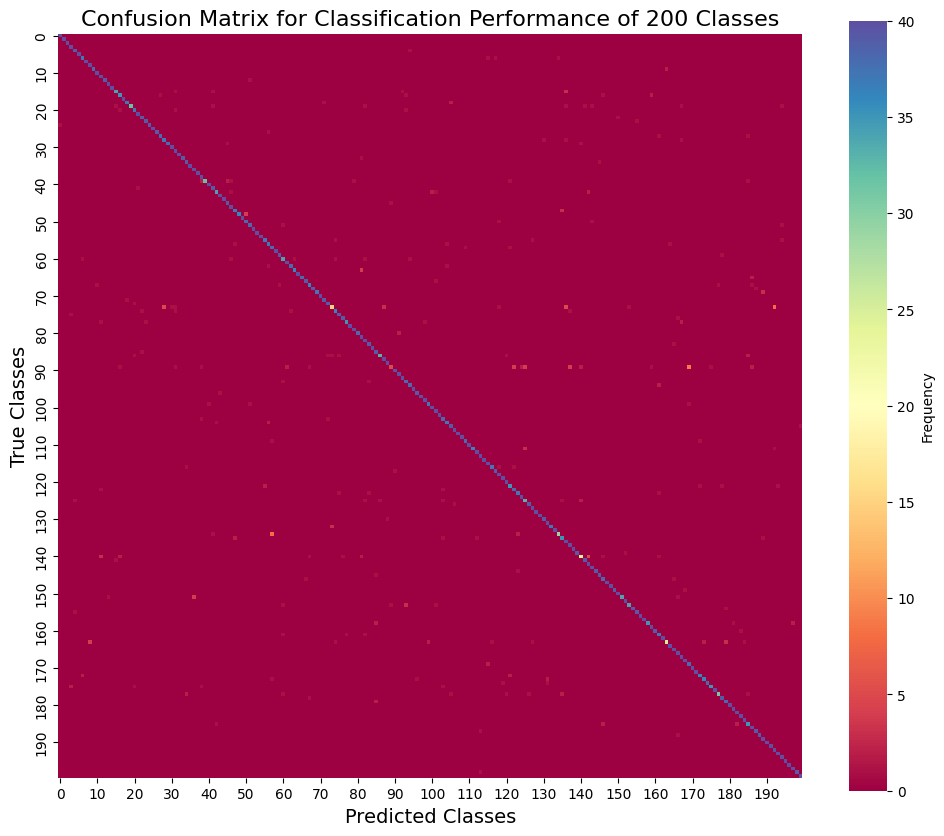

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='sigmoid').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_sigmoid.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 4.2605, Train Acc: 0.4123, Train F1: 0.4173, Val Acc: 0.7164, Val F1: 0.6917, Time: 3.60s
Epoch 2/50, Train Loss: 2.3725, Train Acc: 0.7645, Train F1: 0.7558, Val Acc: 0.8542, Val F1: 0.8404, Time: 3.82s
Epoch 3/50, Train Loss: 1.2812, Train Acc: 0.8682, Train F1: 0.8653, Val Acc: 0.9079, Val F1: 0.8998, Time: 3.33s
Epoch 4/50, Train Loss: 0.7706, Train Acc: 0.9093, Train F1: 0.9084, Val Acc: 0.9300, Val F1: 0.9252, Time: 3.86s
Epoch 5/50, Train Loss: 0.5204, Train Acc: 0.9303, Train F1: 0.9301, Val Acc: 0.9480, Val F1: 0.9454, Time: 3.87s
Epoch 6/50, Train Loss: 0.3848, Train Acc: 0.9457, Train F1: 0.9456, Val Acc: 0.9565, Val F1: 0.9544, Time: 3.57s
Epoch 7/50, Train Loss: 0.3003, Train Acc: 0.9557, Train F1: 0.9558, Val Acc: 0.9607, Val F1: 0.9597, Time: 3.31s
Epoch 8/50, Train Loss: 0.2432, Train Acc: 0.9636, Train F1: 0.9637, Val Acc: 0.9686, Val F1: 0.9680, Time: 3.36s
Epoch 9/50, Train Loss: 0.2019, Train Acc: 0.9700, Train F1: 0.9702, Val Acc: 0.9698, Va

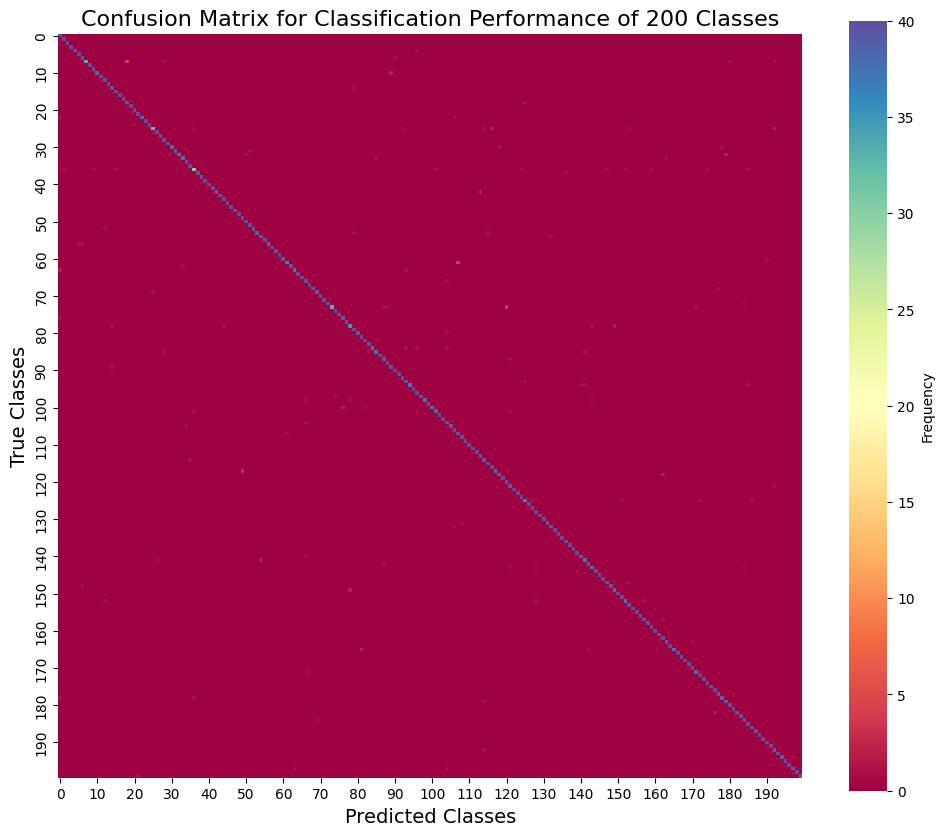

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='sigmoid').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_sigmoid.csv', index=False)

## Hard Sigmoid

Epoch 1/50, Train Loss: 3.6318, Train Acc: 0.4065, Train F1: 0.4160, Val Acc: 0.7625, Val F1: 0.7332, Time: 3.83s
Epoch 2/50, Train Loss: 1.4042, Train Acc: 0.7720, Train F1: 0.7700, Val Acc: 0.8811, Val F1: 0.8711, Time: 3.55s
Epoch 3/50, Train Loss: 0.8133, Train Acc: 0.8447, Train F1: 0.8449, Val Acc: 0.9073, Val F1: 0.8996, Time: 4.19s
Epoch 4/50, Train Loss: 0.5932, Train Acc: 0.8782, Train F1: 0.8785, Val Acc: 0.9241, Val F1: 0.9183, Time: 3.57s
Epoch 5/50, Train Loss: 0.4735, Train Acc: 0.8986, Train F1: 0.8989, Val Acc: 0.9341, Val F1: 0.9290, Time: 3.57s
Epoch 6/50, Train Loss: 0.3958, Train Acc: 0.9137, Train F1: 0.9140, Val Acc: 0.9404, Val F1: 0.9362, Time: 4.18s
Epoch 7/50, Train Loss: 0.3396, Train Acc: 0.9270, Train F1: 0.9272, Val Acc: 0.9447, Val F1: 0.9404, Time: 3.89s
Epoch 8/50, Train Loss: 0.2968, Train Acc: 0.9351, Train F1: 0.9353, Val Acc: 0.9487, Val F1: 0.9462, Time: 3.53s
Epoch 9/50, Train Loss: 0.2620, Train Acc: 0.9420, Train F1: 0.9421, Val Acc: 0.9494, Va

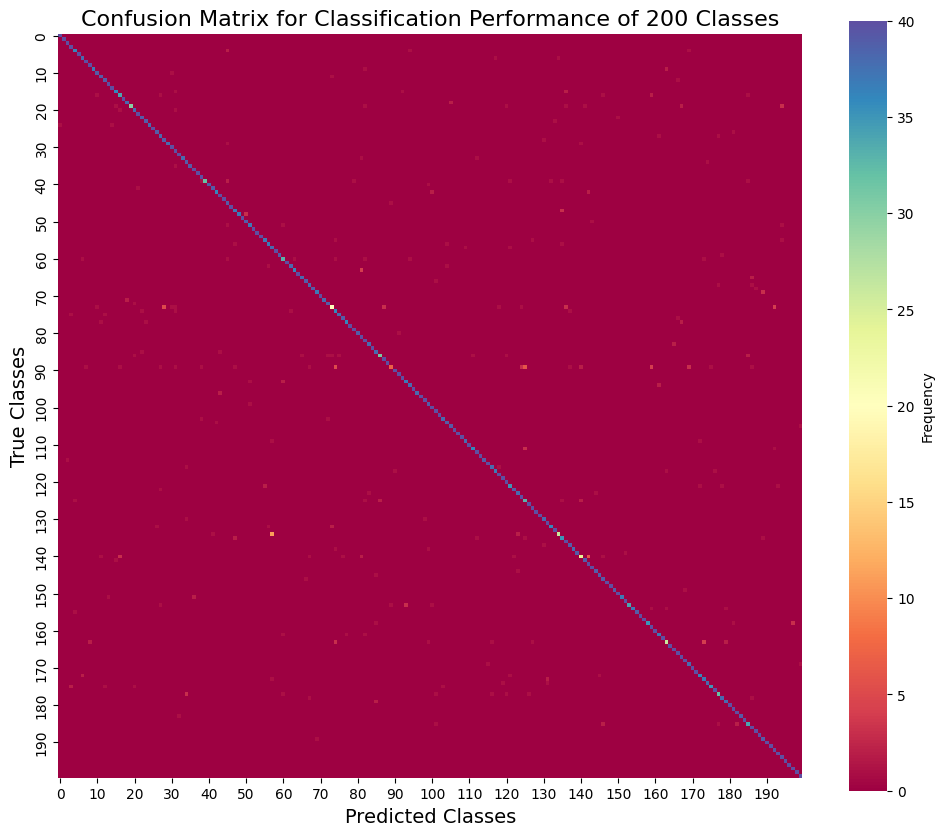

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='hard_sigmoid').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_hard_sigmoid.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 4.3149, Train Acc: 0.3688, Train F1: 0.3858, Val Acc: 0.6965, Val F1: 0.6750, Time: 3.33s
Epoch 2/50, Train Loss: 2.4206, Train Acc: 0.7507, Train F1: 0.7421, Val Acc: 0.8439, Val F1: 0.8283, Time: 3.33s
Epoch 3/50, Train Loss: 1.3334, Train Acc: 0.8585, Train F1: 0.8547, Val Acc: 0.9066, Val F1: 0.8985, Time: 3.61s
Epoch 4/50, Train Loss: 0.8070, Train Acc: 0.9048, Train F1: 0.9038, Val Acc: 0.9304, Val F1: 0.9251, Time: 3.74s
Epoch 5/50, Train Loss: 0.5473, Train Acc: 0.9286, Train F1: 0.9284, Val Acc: 0.9443, Val F1: 0.9398, Time: 3.35s
Epoch 6/50, Train Loss: 0.4044, Train Acc: 0.9433, Train F1: 0.9434, Val Acc: 0.9523, Val F1: 0.9490, Time: 3.38s
Epoch 7/50, Train Loss: 0.3174, Train Acc: 0.9530, Train F1: 0.9531, Val Acc: 0.9576, Val F1: 0.9553, Time: 3.76s
Epoch 8/50, Train Loss: 0.2578, Train Acc: 0.9611, Train F1: 0.9613, Val Acc: 0.9613, Val F1: 0.9598, Time: 3.63s
Epoch 9/50, Train Loss: 0.2149, Train Acc: 0.9671, Train F1: 0.9672, Val Acc: 0.9655, Va

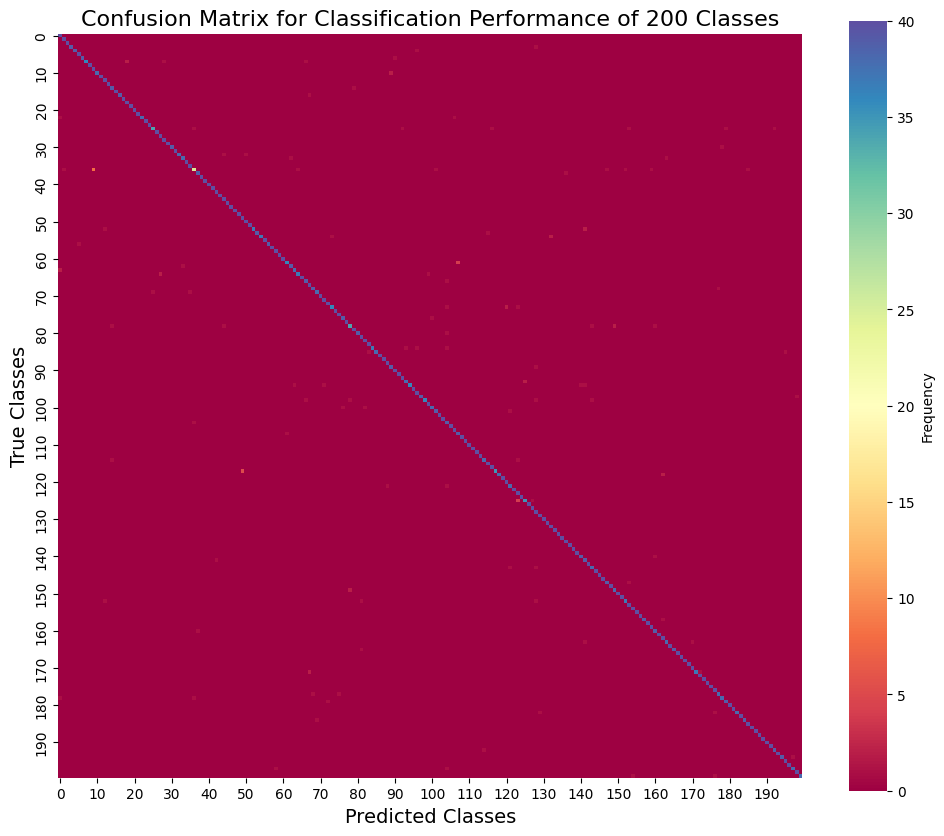

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='hard_sigmoid').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_hard_sigmoid.csv', index=False)

## SiLU

Epoch 1/50, Train Loss: 1.7902, Train Acc: 0.6697, Train F1: 0.6740, Val Acc: 0.9021, Val F1: 0.8966, Time: 3.57s
Epoch 2/50, Train Loss: 0.5471, Train Acc: 0.8773, Train F1: 0.8778, Val Acc: 0.9327, Val F1: 0.9292, Time: 3.82s
Epoch 3/50, Train Loss: 0.3674, Train Acc: 0.9137, Train F1: 0.9140, Val Acc: 0.9456, Val F1: 0.9422, Time: 3.89s
Epoch 4/50, Train Loss: 0.2734, Train Acc: 0.9368, Train F1: 0.9370, Val Acc: 0.9471, Val F1: 0.9433, Time: 3.57s
Epoch 5/50, Train Loss: 0.2123, Train Acc: 0.9505, Train F1: 0.9506, Val Acc: 0.9540, Val F1: 0.9529, Time: 3.54s
Epoch 6/50, Train Loss: 0.1711, Train Acc: 0.9600, Train F1: 0.9600, Val Acc: 0.9534, Val F1: 0.9512, Time: 4.20s
Epoch 7/50, Train Loss: 0.1417, Train Acc: 0.9671, Train F1: 0.9672, Val Acc: 0.9553, Val F1: 0.9528, Time: 3.53s
Epoch 8/50, Train Loss: 0.1191, Train Acc: 0.9721, Train F1: 0.9721, Val Acc: 0.9536, Val F1: 0.9512, Time: 3.54s
Epoch 9/50, Train Loss: 0.1015, Train Acc: 0.9769, Train F1: 0.9769, Val Acc: 0.9566, Va

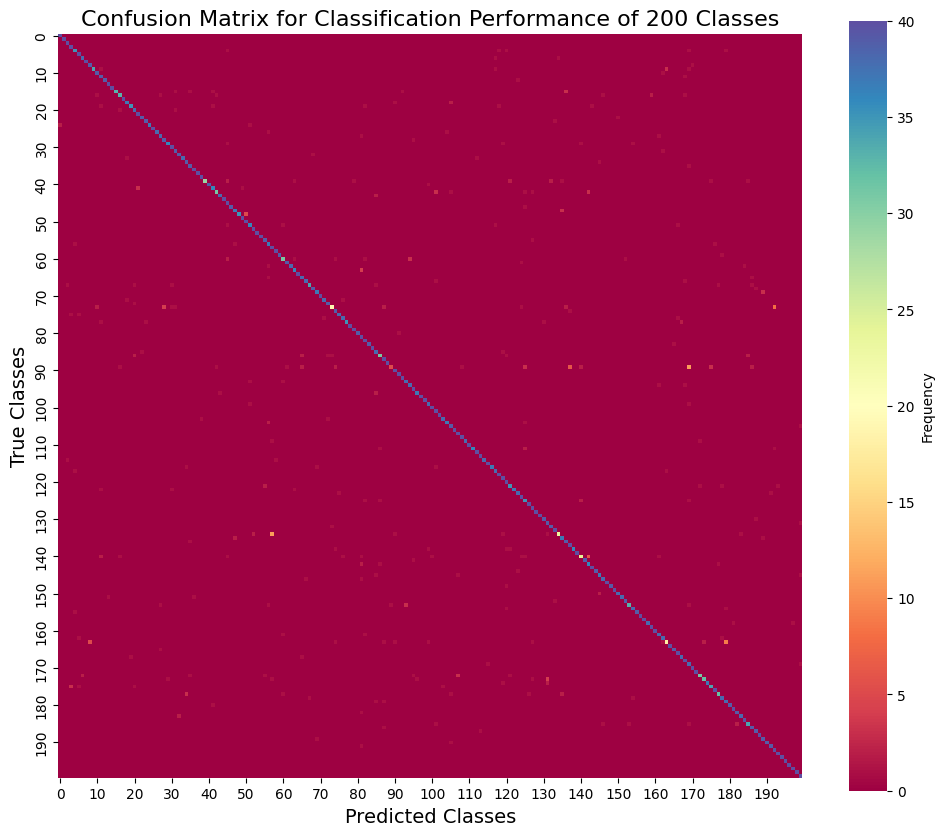

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='silu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_silu.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.1457, Train Acc: 0.6441, Train F1: 0.6570, Val Acc: 0.8918, Val F1: 0.8855, Time: 3.88s
Epoch 2/50, Train Loss: 0.4624, Train Acc: 0.9122, Train F1: 0.9123, Val Acc: 0.9464, Val F1: 0.9441, Time: 3.97s
Epoch 3/50, Train Loss: 0.2611, Train Acc: 0.9477, Train F1: 0.9478, Val Acc: 0.9581, Val F1: 0.9575, Time: 3.38s
Epoch 4/50, Train Loss: 0.1771, Train Acc: 0.9646, Train F1: 0.9647, Val Acc: 0.9636, Val F1: 0.9627, Time: 4.71s
Epoch 5/50, Train Loss: 0.1280, Train Acc: 0.9748, Train F1: 0.9748, Val Acc: 0.9684, Val F1: 0.9677, Time: 4.85s
Epoch 6/50, Train Loss: 0.0964, Train Acc: 0.9818, Train F1: 0.9819, Val Acc: 0.9689, Val F1: 0.9685, Time: 4.61s
Epoch 7/50, Train Loss: 0.0750, Train Acc: 0.9865, Train F1: 0.9866, Val Acc: 0.9720, Val F1: 0.9715, Time: 6.22s
Epoch 8/50, Train Loss: 0.0594, Train Acc: 0.9901, Train F1: 0.9902, Val Acc: 0.9740, Val F1: 0.9737, Time: 5.62s
Epoch 9/50, Train Loss: 0.0479, Train Acc: 0.9919, Train F1: 0.9919, Val Acc: 0.9759, Va

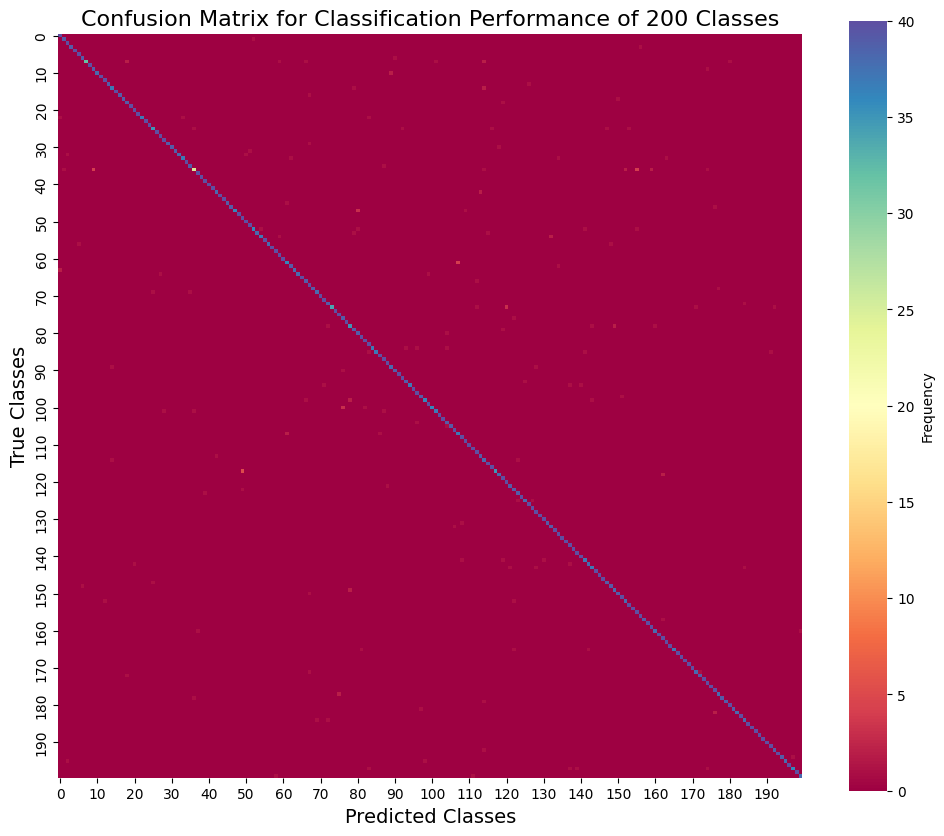

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='silu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_silu.csv', index=False)

## Tanh

Epoch 1/50, Train Loss: 2.3823, Train Acc: 0.6579, Train F1: 0.6596, Val Acc: 0.9163, Val F1: 0.9094, Time: 3.97s
Epoch 2/50, Train Loss: 0.8929, Train Acc: 0.8792, Train F1: 0.8795, Val Acc: 0.9423, Val F1: 0.9374, Time: 3.55s
Epoch 3/50, Train Loss: 0.6219, Train Acc: 0.9154, Train F1: 0.9157, Val Acc: 0.9516, Val F1: 0.9476, Time: 3.55s
Epoch 4/50, Train Loss: 0.4969, Train Acc: 0.9354, Train F1: 0.9357, Val Acc: 0.9606, Val F1: 0.9586, Time: 4.11s
Epoch 5/50, Train Loss: 0.4178, Train Acc: 0.9478, Train F1: 0.9481, Val Acc: 0.9621, Val F1: 0.9608, Time: 3.68s
Epoch 6/50, Train Loss: 0.3589, Train Acc: 0.9570, Train F1: 0.9572, Val Acc: 0.9645, Val F1: 0.9625, Time: 3.51s
Epoch 7/50, Train Loss: 0.3161, Train Acc: 0.9644, Train F1: 0.9646, Val Acc: 0.9665, Val F1: 0.9646, Time: 3.69s
Epoch 8/50, Train Loss: 0.2779, Train Acc: 0.9692, Train F1: 0.9694, Val Acc: 0.9665, Val F1: 0.9652, Time: 4.09s
Epoch 9/50, Train Loss: 0.2505, Train Acc: 0.9725, Train F1: 0.9727, Val Acc: 0.9676, Va

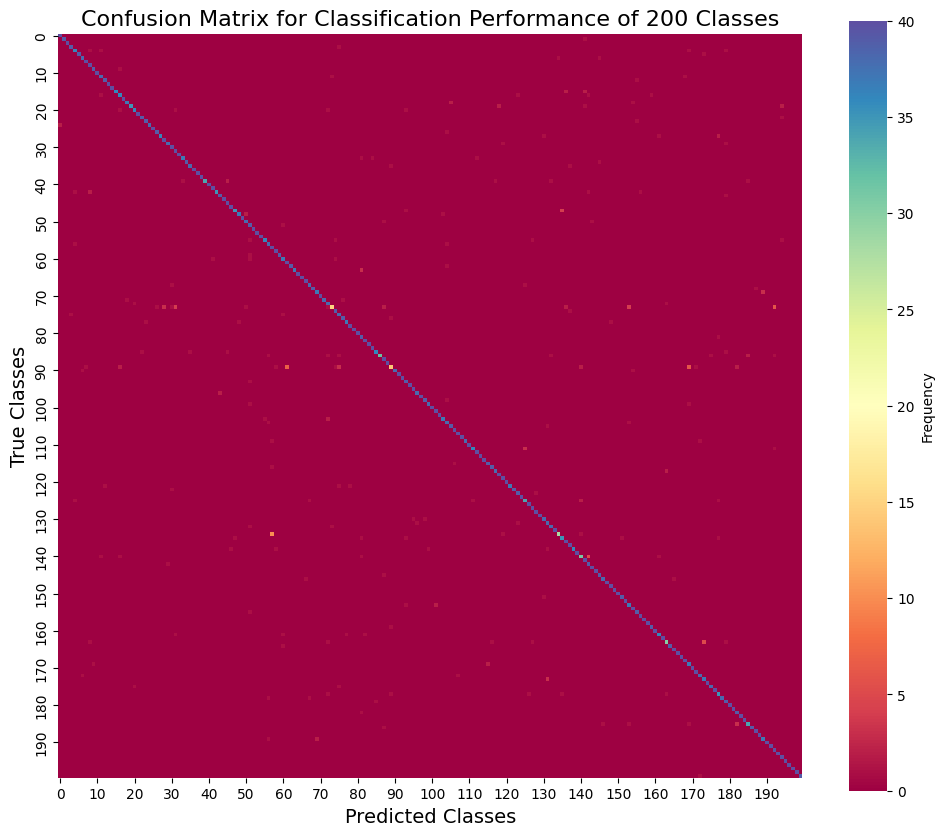

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='tanh').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_tanh.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 3.1314, Train Acc: 0.6345, Train F1: 0.6339, Val Acc: 0.8738, Val F1: 0.8628, Time: 3.61s
Epoch 2/50, Train Loss: 1.2758, Train Acc: 0.8973, Train F1: 0.8953, Val Acc: 0.9376, Val F1: 0.9322, Time: 3.36s
Epoch 3/50, Train Loss: 0.6799, Train Acc: 0.9412, Train F1: 0.9410, Val Acc: 0.9557, Val F1: 0.9530, Time: 3.35s
Epoch 4/50, Train Loss: 0.4397, Train Acc: 0.9581, Train F1: 0.9581, Val Acc: 0.9667, Val F1: 0.9651, Time: 4.03s
Epoch 5/50, Train Loss: 0.3209, Train Acc: 0.9689, Train F1: 0.9689, Val Acc: 0.9744, Val F1: 0.9739, Time: 3.34s
Epoch 6/50, Train Loss: 0.2484, Train Acc: 0.9766, Train F1: 0.9766, Val Acc: 0.9769, Val F1: 0.9765, Time: 3.33s
Epoch 7/50, Train Loss: 0.2014, Train Acc: 0.9825, Train F1: 0.9826, Val Acc: 0.9799, Val F1: 0.9796, Time: 3.38s
Epoch 8/50, Train Loss: 0.1662, Train Acc: 0.9859, Train F1: 0.9860, Val Acc: 0.9821, Val F1: 0.9820, Time: 3.90s
Epoch 9/50, Train Loss: 0.1392, Train Acc: 0.9890, Train F1: 0.9890, Val Acc: 0.9809, Va

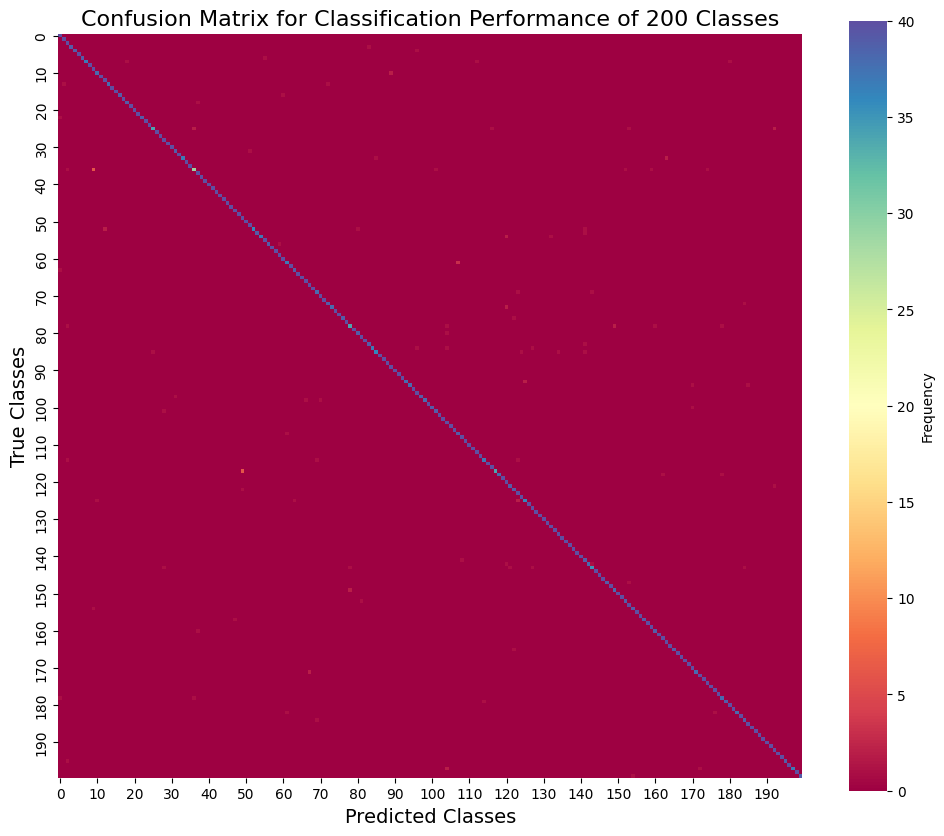

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='tanh').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_tanh.csv', index=False)

### For save

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada

input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='tanh').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_tanh.csv', index=False)

Epoch 1/50, Train Loss: 1.7779, Train Acc: 0.7660, Train F1: 0.7699, Val Acc: 0.9439, Val F1: 0.9405, Time: 4.12s
Epoch 2/50, Train Loss: 0.4199, Train Acc: 0.9495, Train F1: 0.9495, Val Acc: 0.9692, Val F1: 0.9686, Time: 4.06s
Epoch 3/50, Train Loss: 0.2466, Train Acc: 0.9718, Train F1: 0.9718, Val Acc: 0.9778, Val F1: 0.9775, Time: 4.76s
Epoch 4/50, Train Loss: 0.1702, Train Acc: 0.9819, Train F1: 0.9819, Val Acc: 0.9799, Val F1: 0.9797, Time: 4.06s
Epoch 5/50, Train Loss: 0.1242, Train Acc: 0.9883, Train F1: 0.9884, Val Acc: 0.9829, Val F1: 0.9828, Time: 4.05s
Epoch 6/50, Train Loss: 0.0943, Train Acc: 0.9921, Train F1: 0.9922, Val Acc: 0.9814, Val F1: 0.9812, Time: 4.66s
Epoch 7/50, Train Loss: 0.0714, Train Acc: 0.9941, Train F1: 0.9941, Val Acc: 0.9831, Val F1: 0.9829, Time: 4.86s
Epoch 8/50, Train Loss: 0.0558, Train Acc: 0.9949, Train F1: 0.9949, Val Acc: 0.9826, Val F1: 0.9824, Time: 4.06s
Epoch 9/50, Train Loss: 0.0441, Train Acc: 0.9963, Train F1: 0.9963, Val Acc: 0.9832, Va

KeyboardInterrupt: 

In [ ]:
# Menyimpan state_dict (bobot model)
torch.save(model.state_dict(), 'ViT-B_1024_Tanh.pth')
print("Model weights saved successfully!")


Model weights saved successfully!


In [ ]:
# Menyimpan keseluruhan model
torch.save(model, 'ViT-B_1024_Tanh_model.pth')
print("Entire model saved successfully!")


Entire model saved successfully!


## Hard Tanh

Epoch 1/50, Train Loss: 2.2684, Train Acc: 0.6701, Train F1: 0.6722, Val Acc: 0.9185, Val F1: 0.9097, Time: 3.60s
Epoch 2/50, Train Loss: 0.8419, Train Acc: 0.8826, Train F1: 0.8831, Val Acc: 0.9449, Val F1: 0.9396, Time: 3.55s
Epoch 3/50, Train Loss: 0.5898, Train Acc: 0.9198, Train F1: 0.9203, Val Acc: 0.9555, Val F1: 0.9525, Time: 4.16s
Epoch 4/50, Train Loss: 0.4703, Train Acc: 0.9374, Train F1: 0.9377, Val Acc: 0.9603, Val F1: 0.9580, Time: 3.56s
Epoch 5/50, Train Loss: 0.3929, Train Acc: 0.9499, Train F1: 0.9501, Val Acc: 0.9630, Val F1: 0.9610, Time: 3.56s
Epoch 6/50, Train Loss: 0.3348, Train Acc: 0.9593, Train F1: 0.9595, Val Acc: 0.9637, Val F1: 0.9615, Time: 3.88s
Epoch 7/50, Train Loss: 0.2927, Train Acc: 0.9644, Train F1: 0.9646, Val Acc: 0.9645, Val F1: 0.9629, Time: 3.93s
Epoch 8/50, Train Loss: 0.2566, Train Acc: 0.9699, Train F1: 0.9700, Val Acc: 0.9646, Val F1: 0.9624, Time: 3.59s
Epoch 9/50, Train Loss: 0.2286, Train Acc: 0.9729, Train F1: 0.9730, Val Acc: 0.9669, Va

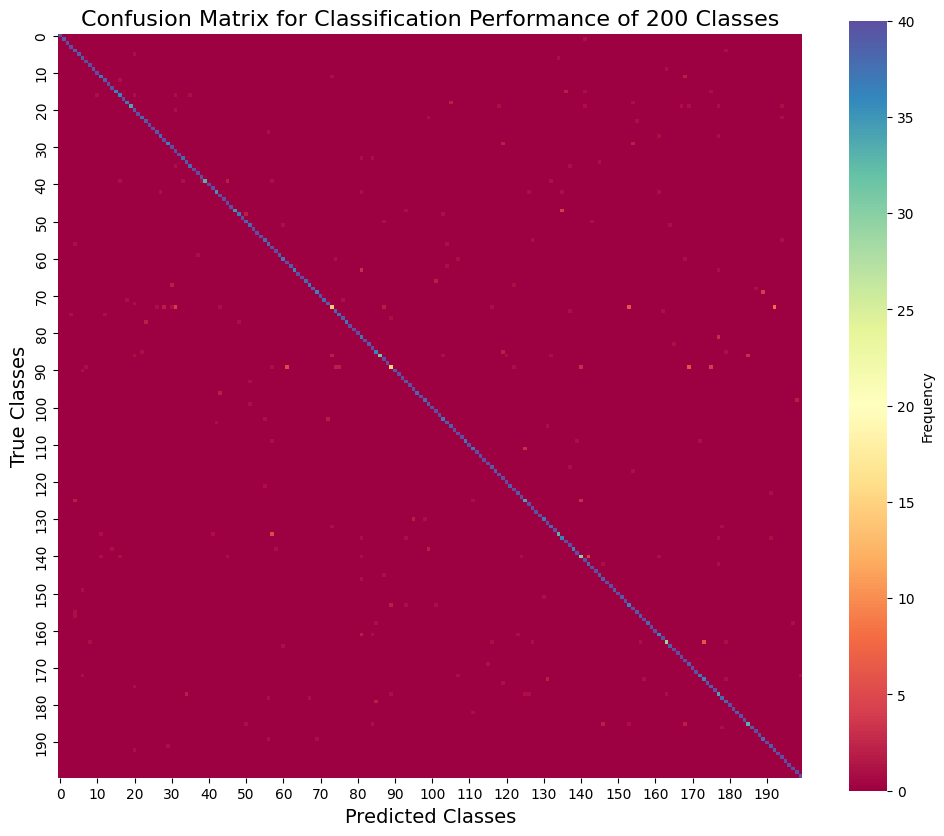

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='hard_tanh').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_hard_tanh.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.9746, Train Acc: 0.6555, Train F1: 0.6555, Val Acc: 0.8928, Val F1: 0.8846, Time: 3.79s
Epoch 2/50, Train Loss: 1.1415, Train Acc: 0.9097, Train F1: 0.9088, Val Acc: 0.9449, Val F1: 0.9418, Time: 3.74s
Epoch 3/50, Train Loss: 0.6011, Train Acc: 0.9472, Train F1: 0.9471, Val Acc: 0.9641, Val F1: 0.9624, Time: 4.23s
Epoch 4/50, Train Loss: 0.3905, Train Acc: 0.9642, Train F1: 0.9641, Val Acc: 0.9700, Val F1: 0.9686, Time: 5.26s
Epoch 5/50, Train Loss: 0.2829, Train Acc: 0.9735, Train F1: 0.9735, Val Acc: 0.9745, Val F1: 0.9738, Time: 5.65s
Epoch 6/50, Train Loss: 0.2187, Train Acc: 0.9808, Train F1: 0.9808, Val Acc: 0.9791, Val F1: 0.9788, Time: 4.59s
Epoch 7/50, Train Loss: 0.1749, Train Acc: 0.9857, Train F1: 0.9857, Val Acc: 0.9798, Val F1: 0.9793, Time: 6.12s
Epoch 8/50, Train Loss: 0.1422, Train Acc: 0.9882, Train F1: 0.9883, Val Acc: 0.9804, Val F1: 0.9802, Time: 5.42s
Epoch 9/50, Train Loss: 0.1180, Train Acc: 0.9913, Train F1: 0.9913, Val Acc: 0.9825, Va

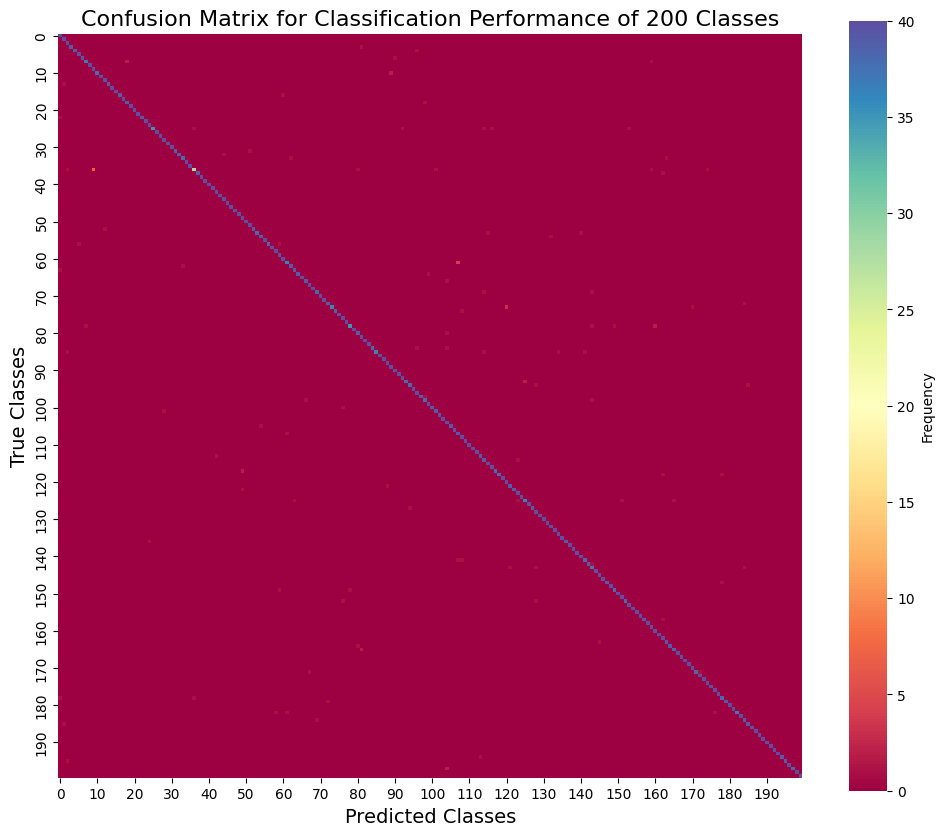

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='hard_tanh').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_hard_tanh.csv', index=False)

### For Save

Epoch 1/50, Train Loss: 2.9755, Train Acc: 0.6534, Train F1: 0.6535, Val Acc: 0.8989, Val F1: 0.8914, Time: 3.79s
Epoch 2/50, Train Loss: 1.1483, Train Acc: 0.9118, Train F1: 0.9110, Val Acc: 0.9491, Val F1: 0.9463, Time: 4.37s
Epoch 3/50, Train Loss: 0.6053, Train Acc: 0.9486, Train F1: 0.9486, Val Acc: 0.9670, Val F1: 0.9649, Time: 4.02s
Epoch 4/50, Train Loss: 0.3917, Train Acc: 0.9627, Train F1: 0.9628, Val Acc: 0.9744, Val F1: 0.9731, Time: 4.42s
Epoch 5/50, Train Loss: 0.2842, Train Acc: 0.9737, Train F1: 0.9737, Val Acc: 0.9779, Val F1: 0.9775, Time: 9.26s
Epoch 6/50, Train Loss: 0.2187, Train Acc: 0.9815, Train F1: 0.9815, Val Acc: 0.9809, Val F1: 0.9806, Time: 5.18s
Epoch 7/50, Train Loss: 0.1748, Train Acc: 0.9849, Train F1: 0.9850, Val Acc: 0.9800, Val F1: 0.9797, Time: 3.89s
Epoch 8/50, Train Loss: 0.1427, Train Acc: 0.9890, Train F1: 0.9891, Val Acc: 0.9821, Val F1: 0.9819, Time: 4.49s
Epoch 9/50, Train Loss: 0.1177, Train Acc: 0.9911, Train F1: 0.9911, Val Acc: 0.9830, Va

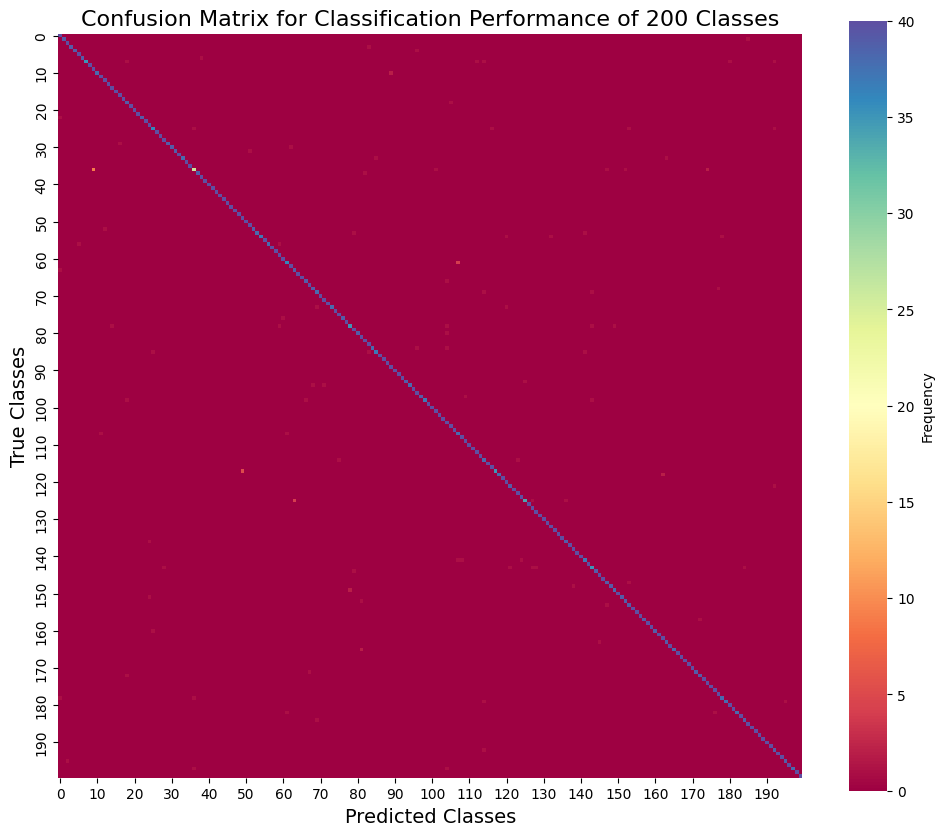

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='hard_tanh').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_hard_tanh.csv', index=False)

In [ ]:
# Menyimpan state_dict (bobot model)
torch.save(model.state_dict(), 'ViT-L_256_Hard_Tanh.pth')
print("Model weights saved successfully!")


Model weights saved successfully!


In [ ]:
# Menyimpan keseluruhan model
torch.save(model, 'ViT-L_256_Hard_Tanh_model.pth')
print("Entire model saved successfully!")


Entire model saved successfully!


## Softsign

Epoch 1/50, Train Loss: 2.8497, Train Acc: 0.6305, Train F1: 0.6306, Val Acc: 0.8892, Val F1: 0.8765, Time: 4.06s
Epoch 2/50, Train Loss: 1.1345, Train Acc: 0.8622, Train F1: 0.8615, Val Acc: 0.9317, Val F1: 0.9252, Time: 3.79s
Epoch 3/50, Train Loss: 0.7536, Train Acc: 0.9029, Train F1: 0.9032, Val Acc: 0.9443, Val F1: 0.9398, Time: 4.15s
Epoch 4/50, Train Loss: 0.5939, Train Acc: 0.9254, Train F1: 0.9257, Val Acc: 0.9523, Val F1: 0.9485, Time: 4.22s
Epoch 5/50, Train Loss: 0.4984, Train Acc: 0.9407, Train F1: 0.9409, Val Acc: 0.9583, Val F1: 0.9556, Time: 3.86s
Epoch 6/50, Train Loss: 0.4294, Train Acc: 0.9504, Train F1: 0.9506, Val Acc: 0.9601, Val F1: 0.9577, Time: 3.94s
Epoch 7/50, Train Loss: 0.3785, Train Acc: 0.9592, Train F1: 0.9594, Val Acc: 0.9626, Val F1: 0.9603, Time: 4.49s
Epoch 8/50, Train Loss: 0.3358, Train Acc: 0.9639, Train F1: 0.9641, Val Acc: 0.9634, Val F1: 0.9611, Time: 3.82s
Epoch 9/50, Train Loss: 0.3037, Train Acc: 0.9695, Train F1: 0.9697, Val Acc: 0.9650, Va

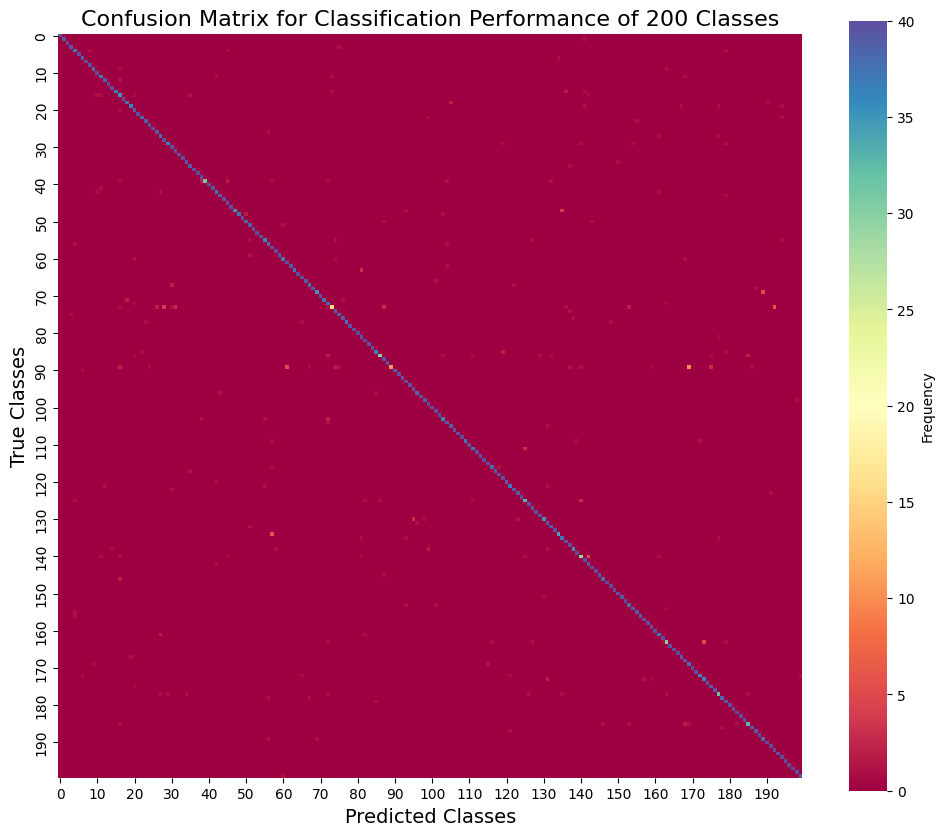

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='softsign').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_softsign.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 3.6626, Train Acc: 0.6049, Train F1: 0.6019, Val Acc: 0.8530, Val F1: 0.8423, Time: 4.04s
Epoch 2/50, Train Loss: 1.8684, Train Acc: 0.8627, Train F1: 0.8590, Val Acc: 0.9153, Val F1: 0.9070, Time: 3.94s
Epoch 3/50, Train Loss: 1.0663, Train Acc: 0.9186, Train F1: 0.9177, Val Acc: 0.9407, Val F1: 0.9366, Time: 4.12s
Epoch 4/50, Train Loss: 0.6878, Train Acc: 0.9399, Train F1: 0.9397, Val Acc: 0.9545, Val F1: 0.9512, Time: 6.17s
Epoch 5/50, Train Loss: 0.4929, Train Acc: 0.9544, Train F1: 0.9543, Val Acc: 0.9645, Val F1: 0.9624, Time: 6.86s
Epoch 6/50, Train Loss: 0.3808, Train Acc: 0.9630, Train F1: 0.9629, Val Acc: 0.9679, Val F1: 0.9665, Time: 5.59s
Epoch 7/50, Train Loss: 0.3082, Train Acc: 0.9706, Train F1: 0.9706, Val Acc: 0.9729, Val F1: 0.9719, Time: 5.69s
Epoch 8/50, Train Loss: 0.2572, Train Acc: 0.9758, Train F1: 0.9758, Val Acc: 0.9746, Val F1: 0.9737, Time: 3.55s
Epoch 9/50, Train Loss: 0.2203, Train Acc: 0.9800, Train F1: 0.9801, Val Acc: 0.9749, Va

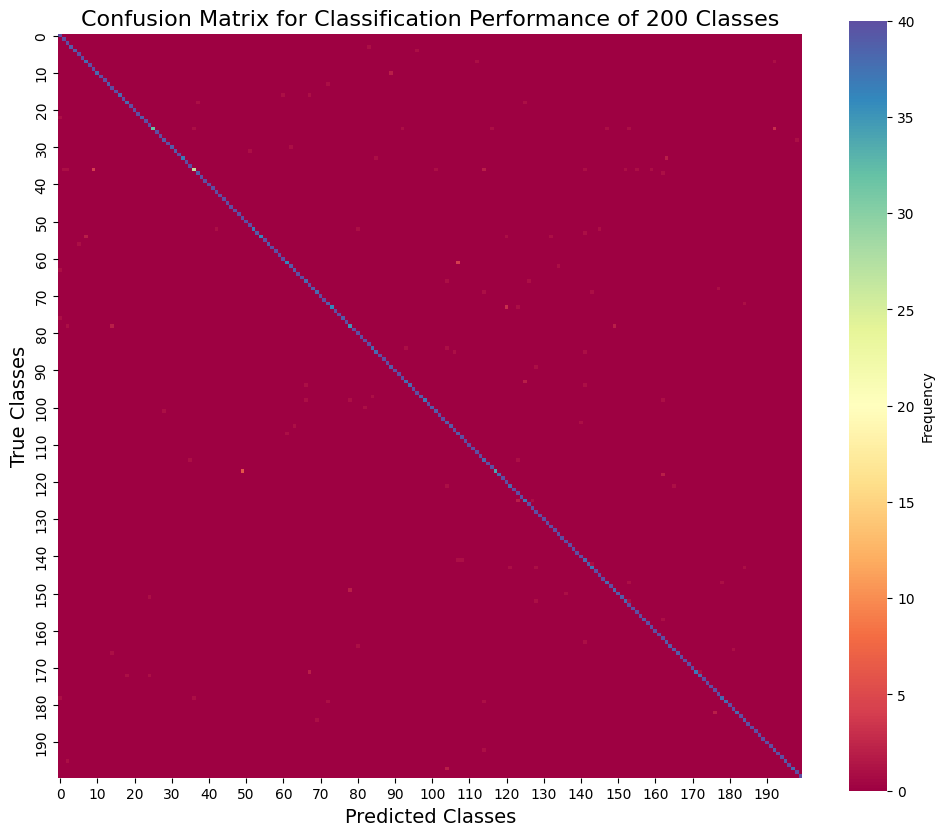

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='softsign').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_softsign.csv', index=False)

## ReLU

Epoch 1/50, Train Loss: 1.7357, Train Acc: 0.6758, Train F1: 0.6808, Val Acc: 0.9074, Val F1: 0.9014, Time: 3.76s
Epoch 2/50, Train Loss: 0.5334, Train Acc: 0.8789, Train F1: 0.8793, Val Acc: 0.9400, Val F1: 0.9362, Time: 4.15s
Epoch 3/50, Train Loss: 0.3547, Train Acc: 0.9165, Train F1: 0.9166, Val Acc: 0.9477, Val F1: 0.9464, Time: 3.59s
Epoch 4/50, Train Loss: 0.2626, Train Acc: 0.9381, Train F1: 0.9383, Val Acc: 0.9510, Val F1: 0.9491, Time: 3.54s
Epoch 5/50, Train Loss: 0.2029, Train Acc: 0.9512, Train F1: 0.9513, Val Acc: 0.9520, Val F1: 0.9495, Time: 4.08s
Epoch 6/50, Train Loss: 0.1628, Train Acc: 0.9611, Train F1: 0.9612, Val Acc: 0.9551, Val F1: 0.9537, Time: 3.80s
Epoch 7/50, Train Loss: 0.1333, Train Acc: 0.9688, Train F1: 0.9688, Val Acc: 0.9589, Val F1: 0.9578, Time: 3.63s
Epoch 8/50, Train Loss: 0.1127, Train Acc: 0.9732, Train F1: 0.9733, Val Acc: 0.9583, Val F1: 0.9563, Time: 3.71s
Epoch 9/50, Train Loss: 0.0955, Train Acc: 0.9769, Train F1: 0.9769, Val Acc: 0.9550, Va

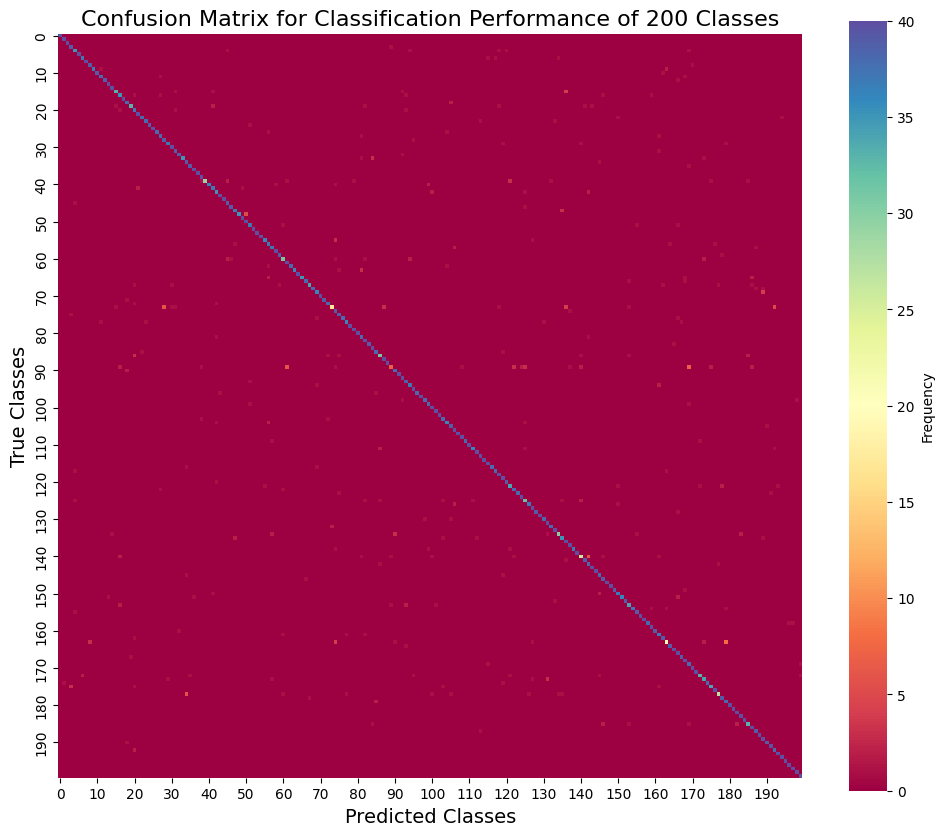

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_relu.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.1828, Train Acc: 0.6408, Train F1: 0.6469, Val Acc: 0.8966, Val F1: 0.8923, Time: 3.81s
Epoch 2/50, Train Loss: 0.4712, Train Acc: 0.9105, Train F1: 0.9104, Val Acc: 0.9460, Val F1: 0.9443, Time: 3.39s
Epoch 3/50, Train Loss: 0.2673, Train Acc: 0.9456, Train F1: 0.9456, Val Acc: 0.9597, Val F1: 0.9587, Time: 3.34s
Epoch 4/50, Train Loss: 0.1806, Train Acc: 0.9628, Train F1: 0.9629, Val Acc: 0.9633, Val F1: 0.9627, Time: 3.84s
Epoch 5/50, Train Loss: 0.1330, Train Acc: 0.9728, Train F1: 0.9729, Val Acc: 0.9724, Val F1: 0.9721, Time: 3.59s
Epoch 6/50, Train Loss: 0.1009, Train Acc: 0.9808, Train F1: 0.9809, Val Acc: 0.9721, Val F1: 0.9717, Time: 3.38s
Epoch 7/50, Train Loss: 0.0791, Train Acc: 0.9854, Train F1: 0.9854, Val Acc: 0.9739, Val F1: 0.9737, Time: 3.36s
Epoch 8/50, Train Loss: 0.0625, Train Acc: 0.9887, Train F1: 0.9887, Val Acc: 0.9759, Val F1: 0.9757, Time: 4.02s
Epoch 9/50, Train Loss: 0.0499, Train Acc: 0.9907, Train F1: 0.9907, Val Acc: 0.9766, Va

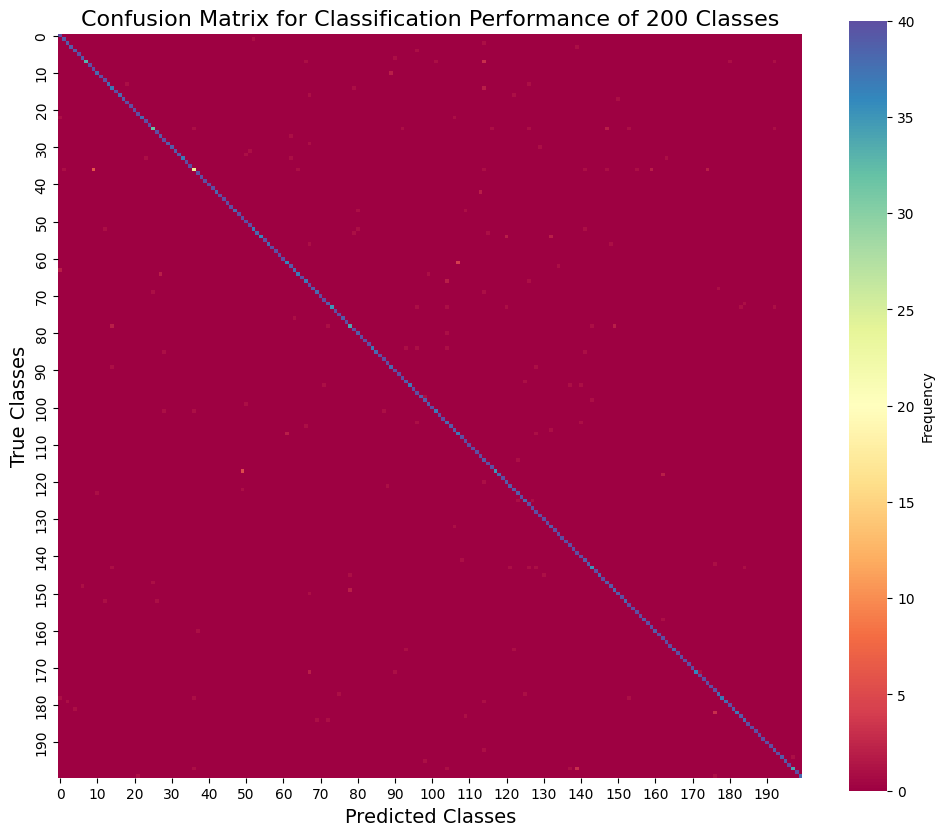

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_relu.csv', index=False)

## Leaky ReLU

Epoch 1/50, Train Loss: 1.7394, Train Acc: 0.6757, Train F1: 0.6812, Val Acc: 0.9079, Val F1: 0.9014, Time: 3.59s
Epoch 2/50, Train Loss: 0.5386, Train Acc: 0.8751, Train F1: 0.8756, Val Acc: 0.9354, Val F1: 0.9317, Time: 3.54s
Epoch 3/50, Train Loss: 0.3575, Train Acc: 0.9175, Train F1: 0.9177, Val Acc: 0.9495, Val F1: 0.9472, Time: 3.94s
Epoch 4/50, Train Loss: 0.2606, Train Acc: 0.9382, Train F1: 0.9383, Val Acc: 0.9511, Val F1: 0.9496, Time: 3.85s
Epoch 5/50, Train Loss: 0.2023, Train Acc: 0.9516, Train F1: 0.9517, Val Acc: 0.9541, Val F1: 0.9523, Time: 3.57s
Epoch 6/50, Train Loss: 0.1622, Train Acc: 0.9610, Train F1: 0.9611, Val Acc: 0.9529, Val F1: 0.9509, Time: 3.54s
Epoch 7/50, Train Loss: 0.1337, Train Acc: 0.9679, Train F1: 0.9679, Val Acc: 0.9581, Val F1: 0.9564, Time: 4.18s
Epoch 8/50, Train Loss: 0.1134, Train Acc: 0.9740, Train F1: 0.9740, Val Acc: 0.9541, Val F1: 0.9523, Time: 3.59s
Epoch 9/50, Train Loss: 0.0958, Train Acc: 0.9777, Train F1: 0.9777, Val Acc: 0.9555, Va

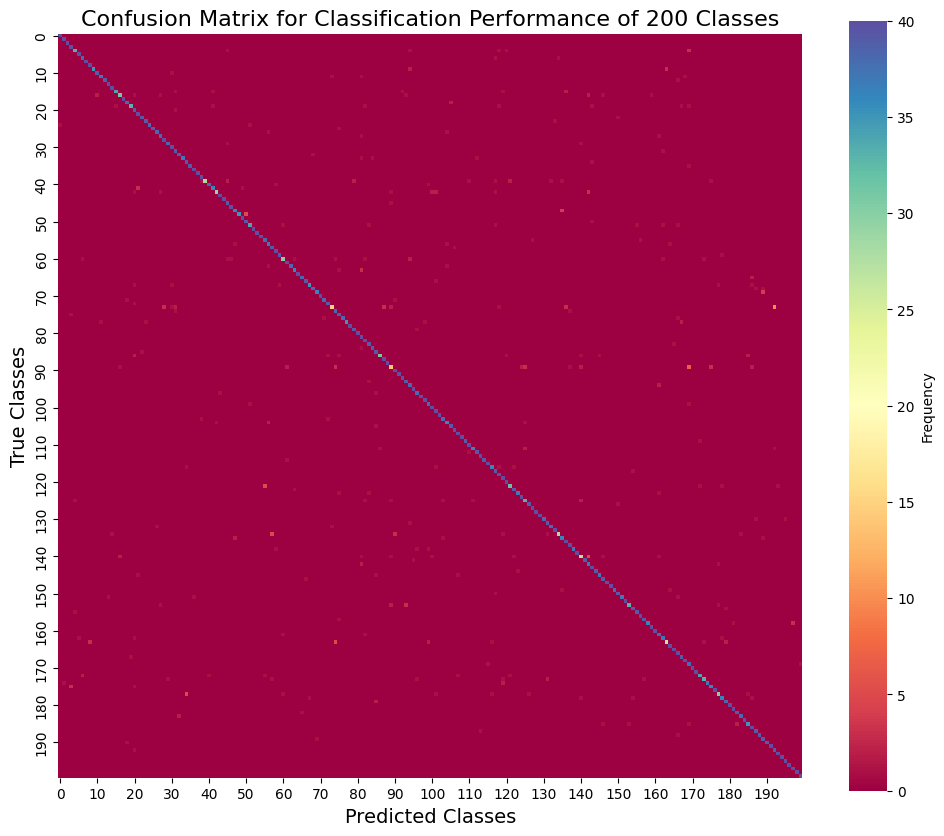

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='leaky_relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_leaky_relu.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.1810, Train Acc: 0.6422, Train F1: 0.6524, Val Acc: 0.8962, Val F1: 0.8904, Time: 5.37s
Epoch 2/50, Train Loss: 0.4763, Train Acc: 0.9084, Train F1: 0.9083, Val Acc: 0.9381, Val F1: 0.9348, Time: 3.36s
Epoch 3/50, Train Loss: 0.2711, Train Acc: 0.9456, Train F1: 0.9457, Val Acc: 0.9571, Val F1: 0.9561, Time: 3.40s
Epoch 4/50, Train Loss: 0.1843, Train Acc: 0.9635, Train F1: 0.9635, Val Acc: 0.9616, Val F1: 0.9610, Time: 3.97s
Epoch 5/50, Train Loss: 0.1348, Train Acc: 0.9729, Train F1: 0.9730, Val Acc: 0.9700, Val F1: 0.9695, Time: 3.48s
Epoch 6/50, Train Loss: 0.1022, Train Acc: 0.9807, Train F1: 0.9807, Val Acc: 0.9698, Val F1: 0.9694, Time: 3.40s
Epoch 7/50, Train Loss: 0.0792, Train Acc: 0.9854, Train F1: 0.9855, Val Acc: 0.9696, Val F1: 0.9691, Time: 3.39s
Epoch 8/50, Train Loss: 0.0631, Train Acc: 0.9889, Train F1: 0.9889, Val Acc: 0.9704, Val F1: 0.9702, Time: 3.96s
Epoch 9/50, Train Loss: 0.0516, Train Acc: 0.9912, Train F1: 0.9912, Val Acc: 0.9721, Va

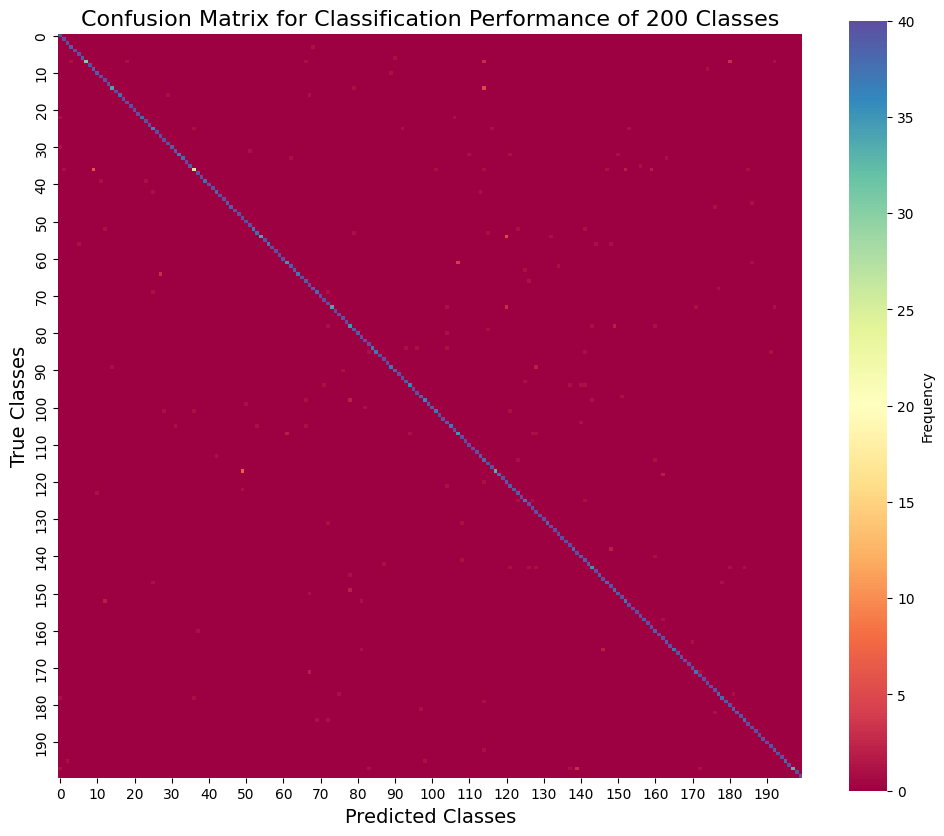

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='leaky_relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_leaky_relu.csv', index=False)

## PReLu

Epoch 1/50, Train Loss: 1.3392, Train Acc: 0.7264, Train F1: 0.7279, Val Acc: 0.9269, Val F1: 0.9247, Time: 3.74s
Epoch 2/50, Train Loss: 0.4107, Train Acc: 0.9018, Train F1: 0.9022, Val Acc: 0.9497, Val F1: 0.9477, Time: 4.10s
Epoch 3/50, Train Loss: 0.2633, Train Acc: 0.9366, Train F1: 0.9368, Val Acc: 0.9527, Val F1: 0.9508, Time: 3.94s
Epoch 4/50, Train Loss: 0.1866, Train Acc: 0.9555, Train F1: 0.9556, Val Acc: 0.9540, Val F1: 0.9519, Time: 3.70s
Epoch 5/50, Train Loss: 0.1403, Train Acc: 0.9656, Train F1: 0.9657, Val Acc: 0.9540, Val F1: 0.9517, Time: 3.74s
Epoch 6/50, Train Loss: 0.1099, Train Acc: 0.9733, Train F1: 0.9733, Val Acc: 0.9544, Val F1: 0.9524, Time: 4.41s
Epoch 7/50, Train Loss: 0.0896, Train Acc: 0.9781, Train F1: 0.9781, Val Acc: 0.9564, Val F1: 0.9544, Time: 3.70s
Epoch 8/50, Train Loss: 0.0741, Train Acc: 0.9823, Train F1: 0.9823, Val Acc: 0.9566, Val F1: 0.9547, Time: 3.71s
Epoch 9/50, Train Loss: 0.0634, Train Acc: 0.9843, Train F1: 0.9844, Val Acc: 0.9554, Va

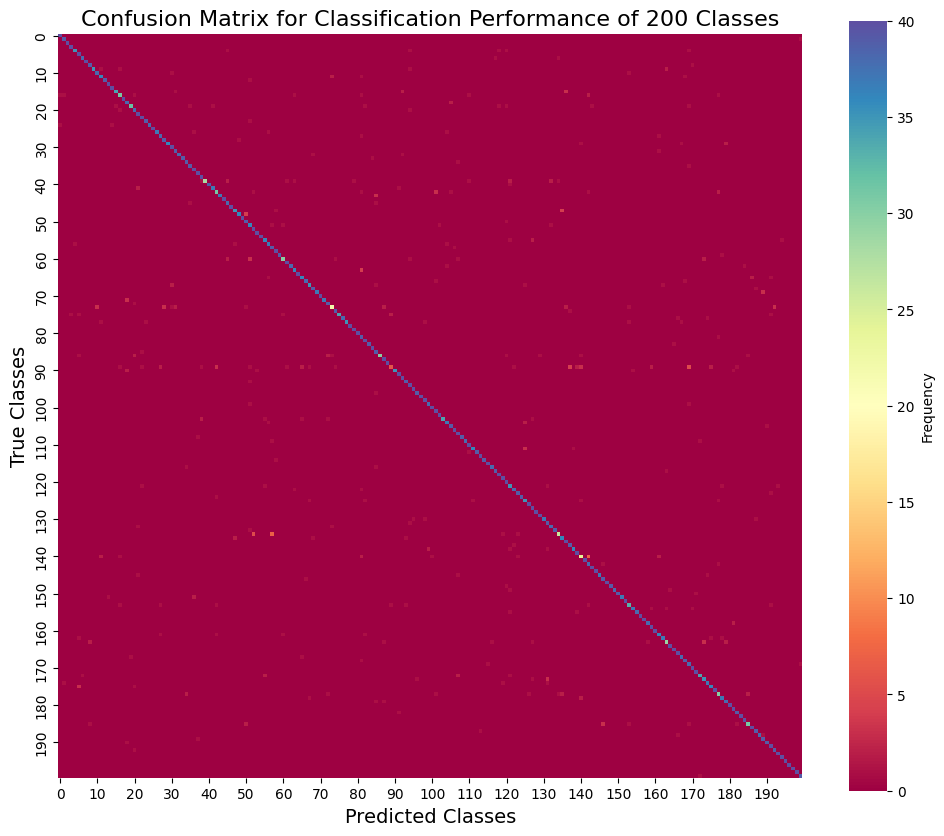

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='prelu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_prelu.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.1873, Train Acc: 0.6378, Train F1: 0.6485, Val Acc: 0.9015, Val F1: 0.8963, Time: 4.21s
Epoch 2/50, Train Loss: 0.4621, Train Acc: 0.9125, Train F1: 0.9125, Val Acc: 0.9467, Val F1: 0.9445, Time: 3.49s
Epoch 3/50, Train Loss: 0.2599, Train Acc: 0.9471, Train F1: 0.9472, Val Acc: 0.9596, Val F1: 0.9590, Time: 3.98s
Epoch 4/50, Train Loss: 0.1765, Train Acc: 0.9657, Train F1: 0.9658, Val Acc: 0.9663, Val F1: 0.9659, Time: 6.63s
Epoch 5/50, Train Loss: 0.1287, Train Acc: 0.9753, Train F1: 0.9754, Val Acc: 0.9716, Val F1: 0.9714, Time: 5.01s
Epoch 6/50, Train Loss: 0.0976, Train Acc: 0.9829, Train F1: 0.9829, Val Acc: 0.9725, Val F1: 0.9722, Time: 6.92s
Epoch 7/50, Train Loss: 0.0761, Train Acc: 0.9874, Train F1: 0.9874, Val Acc: 0.9756, Val F1: 0.9753, Time: 4.78s
Epoch 8/50, Train Loss: 0.0599, Train Acc: 0.9915, Train F1: 0.9915, Val Acc: 0.9769, Val F1: 0.9767, Time: 3.49s
Epoch 9/50, Train Loss: 0.0488, Train Acc: 0.9921, Train F1: 0.9922, Val Acc: 0.9775, Va

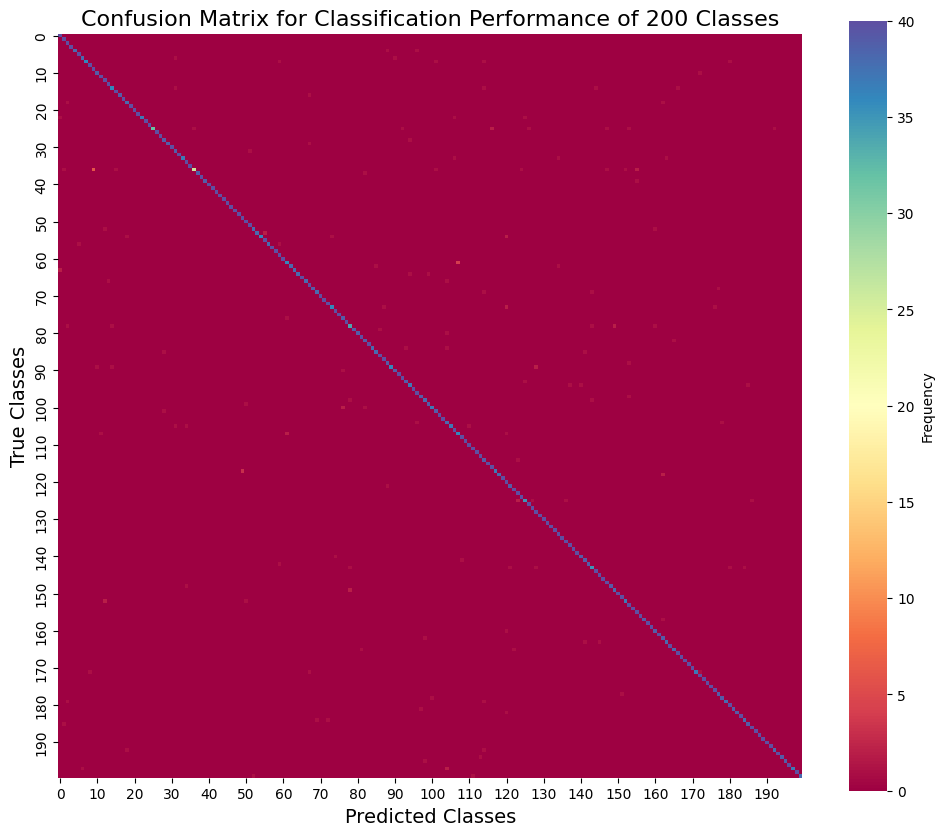

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='prelu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_prelu.csv', index=False)

## RReLU

Epoch 1/50, Train Loss: 1.7804, Train Acc: 0.6742, Train F1: 0.6788, Val Acc: 0.8994, Val F1: 0.8952, Time: 3.66s
Epoch 2/50, Train Loss: 0.5405, Train Acc: 0.8768, Train F1: 0.8772, Val Acc: 0.9411, Val F1: 0.9379, Time: 3.64s
Epoch 3/50, Train Loss: 0.3565, Train Acc: 0.9177, Train F1: 0.9180, Val Acc: 0.9465, Val F1: 0.9449, Time: 3.90s
Epoch 4/50, Train Loss: 0.2632, Train Acc: 0.9398, Train F1: 0.9400, Val Acc: 0.9543, Val F1: 0.9520, Time: 6.28s
Epoch 5/50, Train Loss: 0.2049, Train Acc: 0.9526, Train F1: 0.9527, Val Acc: 0.9546, Val F1: 0.9533, Time: 4.88s
Epoch 6/50, Train Loss: 0.1629, Train Acc: 0.9619, Train F1: 0.9619, Val Acc: 0.9547, Val F1: 0.9522, Time: 4.24s
Epoch 7/50, Train Loss: 0.1357, Train Acc: 0.9690, Train F1: 0.9691, Val Acc: 0.9601, Val F1: 0.9580, Time: 3.76s
Epoch 8/50, Train Loss: 0.1152, Train Acc: 0.9747, Train F1: 0.9747, Val Acc: 0.9580, Val F1: 0.9570, Time: 3.65s
Epoch 9/50, Train Loss: 0.0965, Train Acc: 0.9778, Train F1: 0.9779, Val Acc: 0.9581, Va

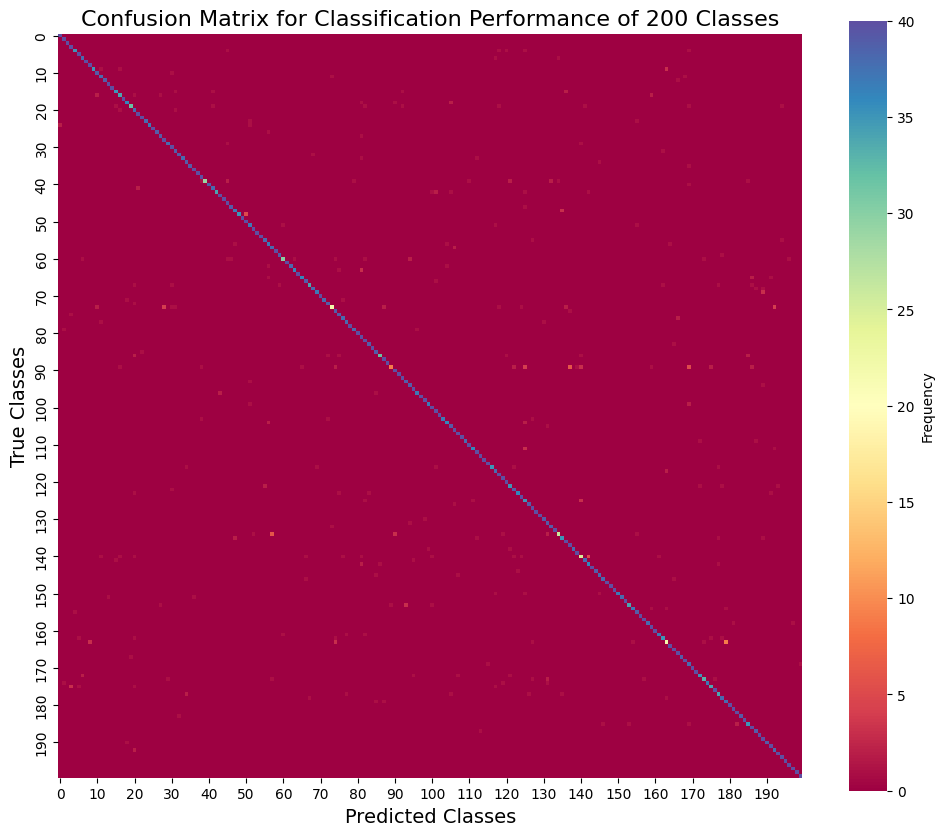

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='rrelu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_rrelu.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.1647, Train Acc: 0.6438, Train F1: 0.6552, Val Acc: 0.8984, Val F1: 0.8924, Time: 3.43s
Epoch 2/50, Train Loss: 0.4655, Train Acc: 0.9092, Train F1: 0.9092, Val Acc: 0.9459, Val F1: 0.9430, Time: 3.43s
Epoch 3/50, Train Loss: 0.2635, Train Acc: 0.9470, Train F1: 0.9470, Val Acc: 0.9579, Val F1: 0.9569, Time: 6.94s
Epoch 4/50, Train Loss: 0.1786, Train Acc: 0.9640, Train F1: 0.9642, Val Acc: 0.9685, Val F1: 0.9683, Time: 5.02s
Epoch 5/50, Train Loss: 0.1306, Train Acc: 0.9756, Train F1: 0.9757, Val Acc: 0.9710, Val F1: 0.9705, Time: 4.36s
Epoch 6/50, Train Loss: 0.0985, Train Acc: 0.9811, Train F1: 0.9811, Val Acc: 0.9730, Val F1: 0.9726, Time: 3.86s
Epoch 7/50, Train Loss: 0.0773, Train Acc: 0.9864, Train F1: 0.9865, Val Acc: 0.9718, Val F1: 0.9714, Time: 3.39s
Epoch 8/50, Train Loss: 0.0613, Train Acc: 0.9891, Train F1: 0.9891, Val Acc: 0.9739, Val F1: 0.9736, Time: 3.40s
Epoch 9/50, Train Loss: 0.0494, Train Acc: 0.9923, Train F1: 0.9923, Val Acc: 0.9761, Va

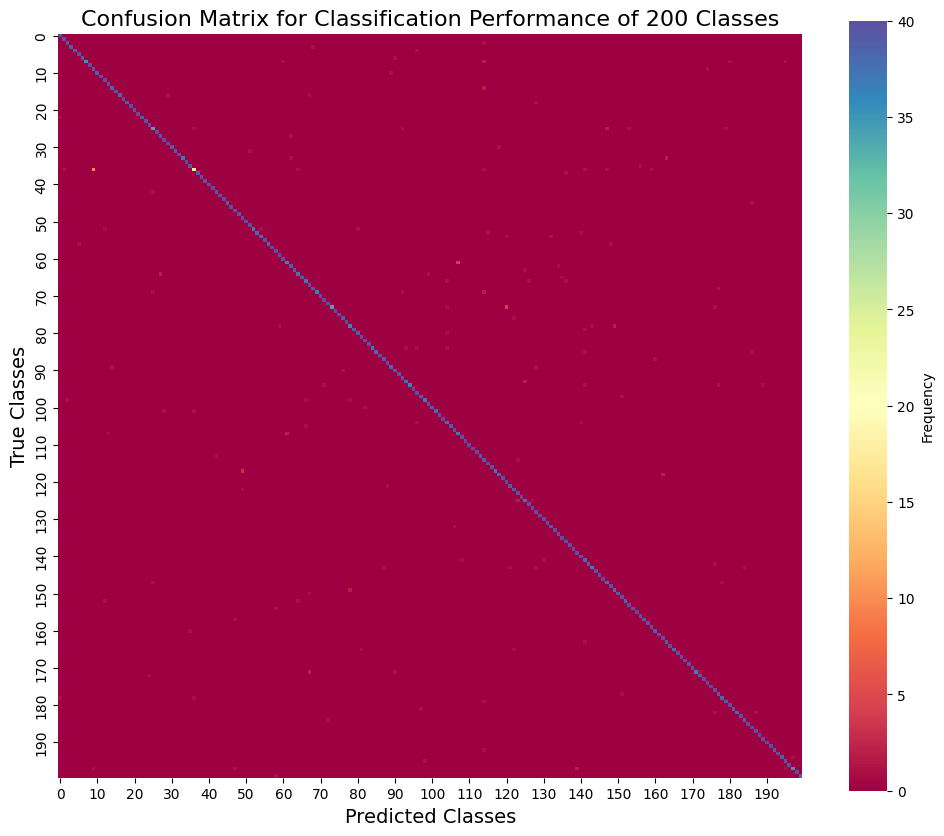

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='rrelu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_rrelu.csv', index=False)

## softplus

Epoch 1/50, Train Loss: 2.1967, Train Acc: 0.5924, Train F1: 0.5987, Val Acc: 0.8829, Val F1: 0.8765, Time: 3.65s
Epoch 2/50, Train Loss: 0.6875, Train Acc: 0.8435, Train F1: 0.8444, Val Acc: 0.9243, Val F1: 0.9198, Time: 3.56s
Epoch 3/50, Train Loss: 0.4681, Train Acc: 0.8885, Train F1: 0.8889, Val Acc: 0.9385, Val F1: 0.9361, Time: 4.02s
Epoch 4/50, Train Loss: 0.3560, Train Acc: 0.9144, Train F1: 0.9146, Val Acc: 0.9431, Val F1: 0.9404, Time: 3.86s
Epoch 5/50, Train Loss: 0.2875, Train Acc: 0.9313, Train F1: 0.9315, Val Acc: 0.9489, Val F1: 0.9475, Time: 3.60s
Epoch 6/50, Train Loss: 0.2381, Train Acc: 0.9419, Train F1: 0.9421, Val Acc: 0.9541, Val F1: 0.9519, Time: 3.62s
Epoch 7/50, Train Loss: 0.1982, Train Acc: 0.9511, Train F1: 0.9511, Val Acc: 0.9536, Val F1: 0.9521, Time: 4.22s
Epoch 8/50, Train Loss: 0.1687, Train Acc: 0.9587, Train F1: 0.9588, Val Acc: 0.9551, Val F1: 0.9537, Time: 3.59s
Epoch 9/50, Train Loss: 0.1477, Train Acc: 0.9647, Train F1: 0.9647, Val Acc: 0.9515, Va

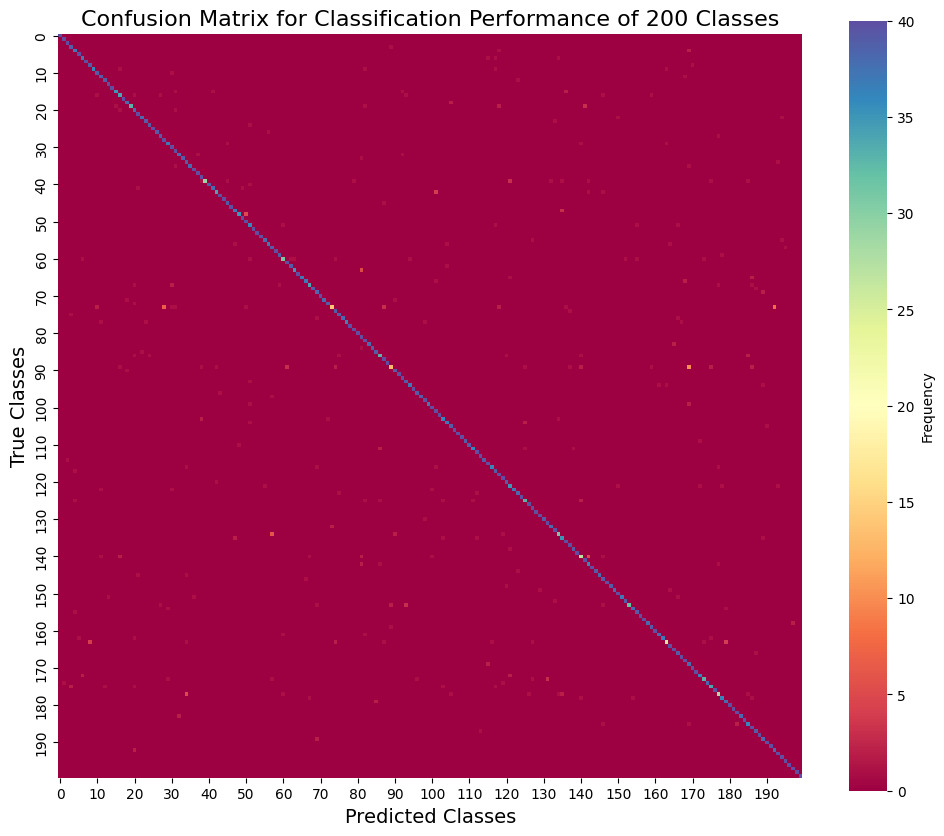

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='softplus').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_softplus.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.5097, Train Acc: 0.5821, Train F1: 0.5966, Val Acc: 0.8660, Val F1: 0.8618, Time: 3.39s
Epoch 2/50, Train Loss: 0.5708, Train Acc: 0.8926, Train F1: 0.8925, Val Acc: 0.9320, Val F1: 0.9288, Time: 3.40s
Epoch 3/50, Train Loss: 0.3188, Train Acc: 0.9352, Train F1: 0.9353, Val Acc: 0.9505, Val F1: 0.9487, Time: 6.00s
Epoch 4/50, Train Loss: 0.2216, Train Acc: 0.9540, Train F1: 0.9541, Val Acc: 0.9596, Val F1: 0.9573, Time: 4.97s
Epoch 5/50, Train Loss: 0.1630, Train Acc: 0.9678, Train F1: 0.9679, Val Acc: 0.9646, Val F1: 0.9643, Time: 7.43s
Epoch 6/50, Train Loss: 0.1266, Train Acc: 0.9745, Train F1: 0.9746, Val Acc: 0.9701, Val F1: 0.9697, Time: 5.10s
Epoch 7/50, Train Loss: 0.0990, Train Acc: 0.9812, Train F1: 0.9812, Val Acc: 0.9704, Val F1: 0.9698, Time: 4.64s
Epoch 8/50, Train Loss: 0.0802, Train Acc: 0.9852, Train F1: 0.9852, Val Acc: 0.9702, Val F1: 0.9694, Time: 6.55s
Epoch 9/50, Train Loss: 0.0651, Train Acc: 0.9889, Train F1: 0.9889, Val Acc: 0.9742, Va

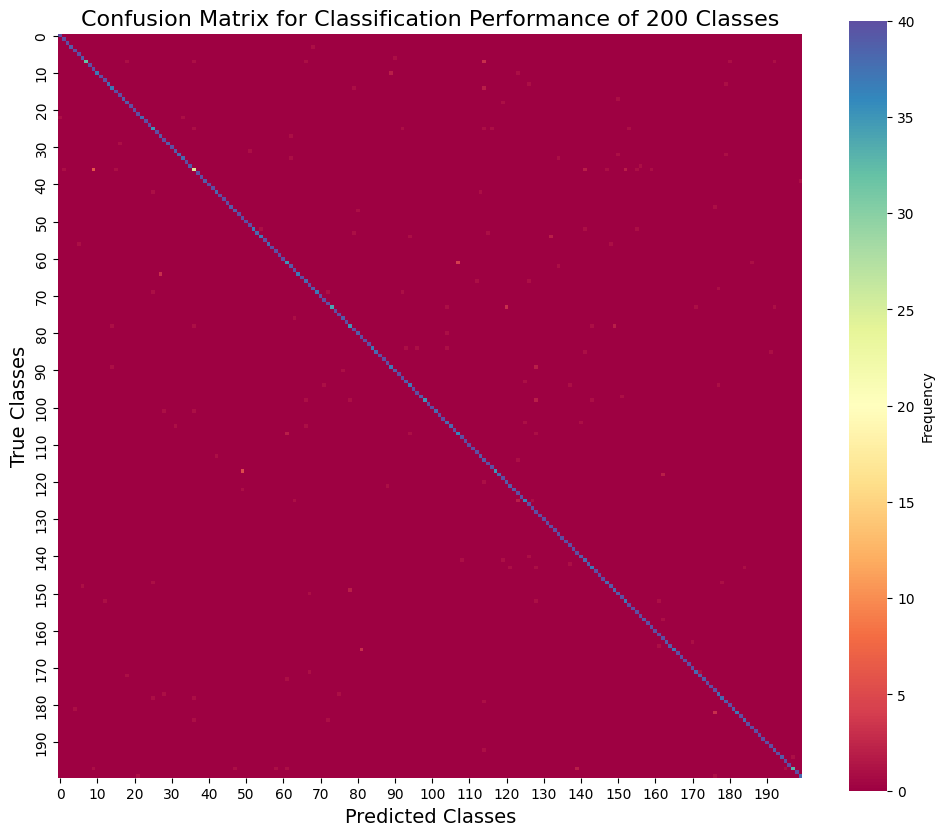

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='softplus').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_softplus.csv', index=False)

## elu

Epoch 1/50, Train Loss: 1.8356, Train Acc: 0.6740, Train F1: 0.6774, Val Acc: 0.9154, Val F1: 0.9101, Time: 3.82s
Epoch 2/50, Train Loss: 0.5641, Train Acc: 0.8838, Train F1: 0.8843, Val Acc: 0.9414, Val F1: 0.9389, Time: 3.67s
Epoch 3/50, Train Loss: 0.3835, Train Acc: 0.9204, Train F1: 0.9208, Val Acc: 0.9496, Val F1: 0.9468, Time: 3.71s
Epoch 4/50, Train Loss: 0.2920, Train Acc: 0.9407, Train F1: 0.9408, Val Acc: 0.9551, Val F1: 0.9531, Time: 4.20s
Epoch 5/50, Train Loss: 0.2337, Train Acc: 0.9551, Train F1: 0.9552, Val Acc: 0.9600, Val F1: 0.9574, Time: 3.66s
Epoch 6/50, Train Loss: 0.1912, Train Acc: 0.9625, Train F1: 0.9626, Val Acc: 0.9594, Val F1: 0.9578, Time: 3.70s
Epoch 7/50, Train Loss: 0.1602, Train Acc: 0.9704, Train F1: 0.9705, Val Acc: 0.9610, Val F1: 0.9593, Time: 4.17s
Epoch 8/50, Train Loss: 0.1351, Train Acc: 0.9742, Train F1: 0.9743, Val Acc: 0.9590, Val F1: 0.9575, Time: 3.88s
Epoch 9/50, Train Loss: 0.1158, Train Acc: 0.9782, Train F1: 0.9783, Val Acc: 0.9603, Va

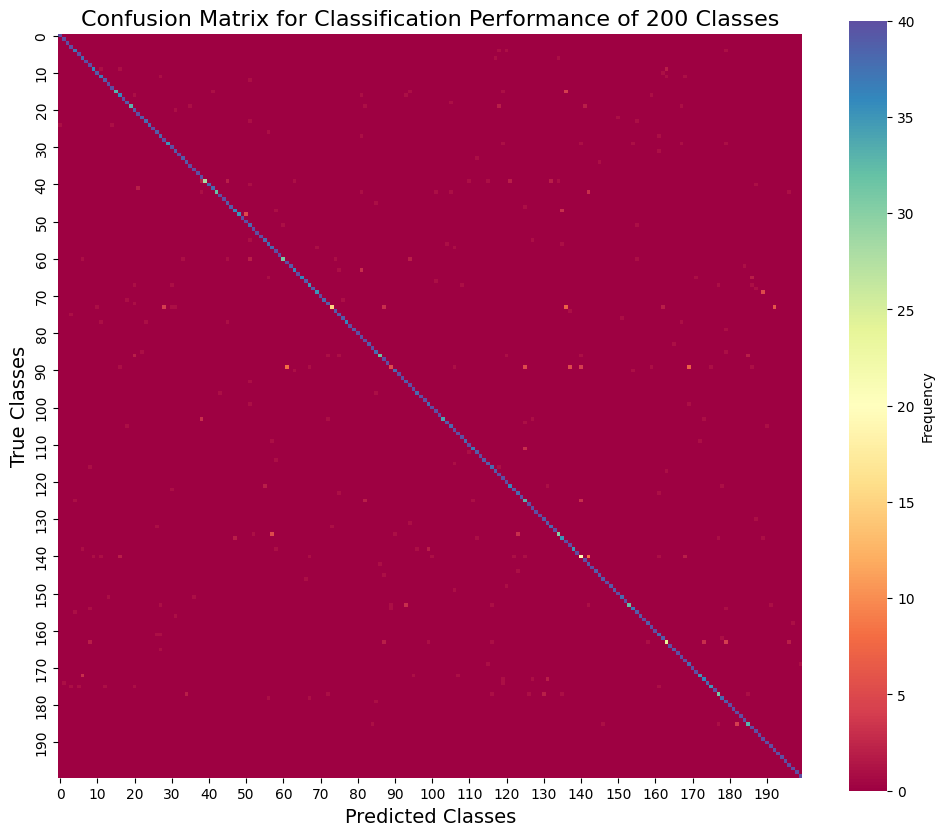

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='elu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_elu.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.1888, Train Acc: 0.6568, Train F1: 0.6624, Val Acc: 0.8998, Val F1: 0.8921, Time: 4.07s
Epoch 2/50, Train Loss: 0.4541, Train Acc: 0.9147, Train F1: 0.9147, Val Acc: 0.9484, Val F1: 0.9472, Time: 3.38s
Epoch 3/50, Train Loss: 0.2558, Train Acc: 0.9486, Train F1: 0.9486, Val Acc: 0.9664, Val F1: 0.9659, Time: 3.36s
Epoch 4/50, Train Loss: 0.1729, Train Acc: 0.9663, Train F1: 0.9664, Val Acc: 0.9702, Val F1: 0.9700, Time: 3.51s
Epoch 5/50, Train Loss: 0.1262, Train Acc: 0.9753, Train F1: 0.9754, Val Acc: 0.9741, Val F1: 0.9738, Time: 3.92s
Epoch 6/50, Train Loss: 0.0959, Train Acc: 0.9826, Train F1: 0.9826, Val Acc: 0.9719, Val F1: 0.9715, Time: 3.36s
Epoch 7/50, Train Loss: 0.0744, Train Acc: 0.9870, Train F1: 0.9870, Val Acc: 0.9724, Val F1: 0.9719, Time: 3.36s
Epoch 8/50, Train Loss: 0.0597, Train Acc: 0.9900, Train F1: 0.9900, Val Acc: 0.9762, Val F1: 0.9760, Time: 3.64s
Epoch 9/50, Train Loss: 0.0486, Train Acc: 0.9926, Train F1: 0.9926, Val Acc: 0.9755, Va

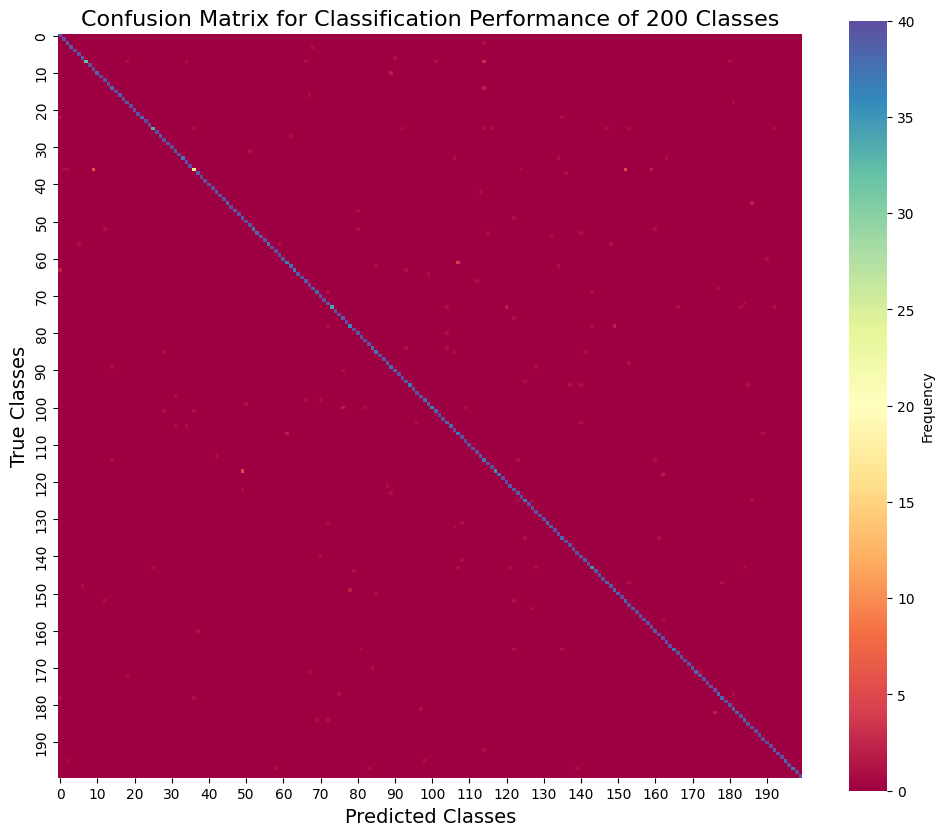

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='elu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_elu.csv', index=False)

## selu

Epoch 1/50, Train Loss: 1.8667, Train Acc: 0.6880, Train F1: 0.6897, Val Acc: 0.9204, Val F1: 0.9140, Time: 3.63s
Epoch 2/50, Train Loss: 0.6529, Train Acc: 0.8832, Train F1: 0.8837, Val Acc: 0.9489, Val F1: 0.9463, Time: 4.21s
Epoch 3/50, Train Loss: 0.4726, Train Acc: 0.9174, Train F1: 0.9179, Val Acc: 0.9513, Val F1: 0.9483, Time: 3.61s
Epoch 4/50, Train Loss: 0.3749, Train Acc: 0.9371, Train F1: 0.9375, Val Acc: 0.9564, Val F1: 0.9537, Time: 3.61s
Epoch 5/50, Train Loss: 0.3109, Train Acc: 0.9489, Train F1: 0.9492, Val Acc: 0.9566, Val F1: 0.9538, Time: 3.89s
Epoch 6/50, Train Loss: 0.2641, Train Acc: 0.9577, Train F1: 0.9578, Val Acc: 0.9596, Val F1: 0.9584, Time: 4.01s
Epoch 7/50, Train Loss: 0.2276, Train Acc: 0.9640, Train F1: 0.9641, Val Acc: 0.9604, Val F1: 0.9595, Time: 3.57s
Epoch 8/50, Train Loss: 0.1990, Train Acc: 0.9685, Train F1: 0.9686, Val Acc: 0.9607, Val F1: 0.9581, Time: 3.58s
Epoch 9/50, Train Loss: 0.1738, Train Acc: 0.9728, Train F1: 0.9729, Val Acc: 0.9641, Va

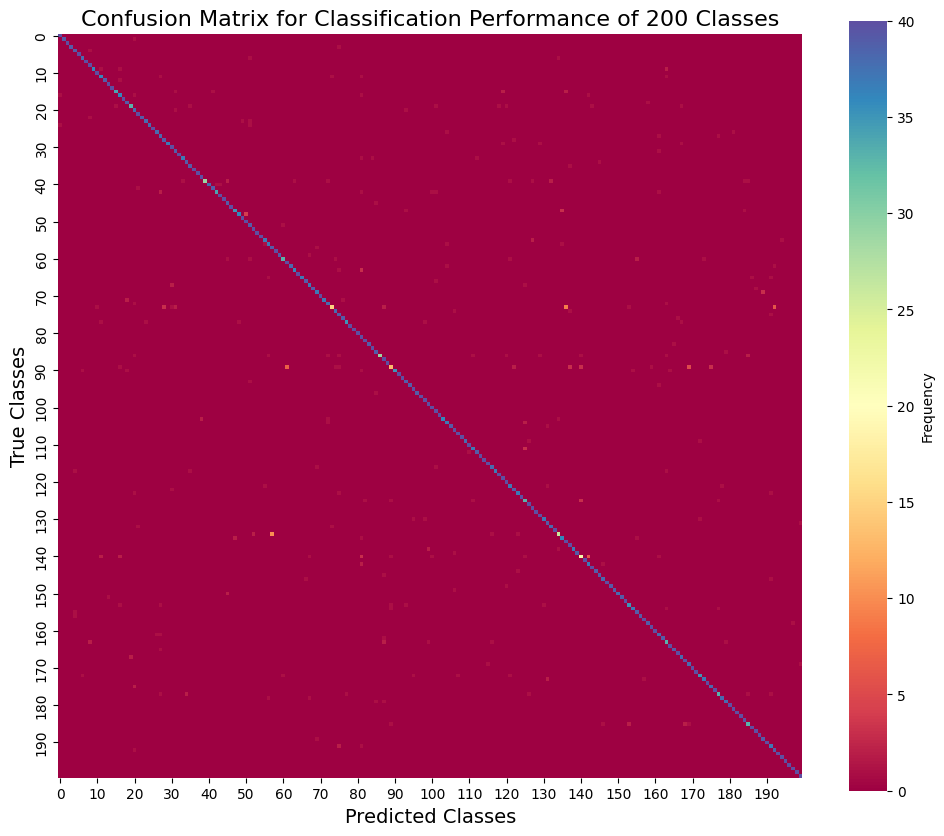

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='selu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_selu.csv', index=False)

#### ViT-L

Epoch 1/50, Train Loss: 2.2098, Train Acc: 0.6768, Train F1: 0.6787, Val Acc: 0.9205, Val F1: 0.9156, Time: 3.38s
Epoch 2/50, Train Loss: 0.4742, Train Acc: 0.9211, Train F1: 0.9211, Val Acc: 0.9540, Val F1: 0.9521, Time: 4.06s
Epoch 3/50, Train Loss: 0.2620, Train Acc: 0.9531, Train F1: 0.9531, Val Acc: 0.9664, Val F1: 0.9660, Time: 3.36s
Epoch 4/50, Train Loss: 0.1778, Train Acc: 0.9686, Train F1: 0.9686, Val Acc: 0.9701, Val F1: 0.9695, Time: 3.35s
Epoch 5/50, Train Loss: 0.1308, Train Acc: 0.9780, Train F1: 0.9781, Val Acc: 0.9746, Val F1: 0.9744, Time: 3.60s
Epoch 6/50, Train Loss: 0.1000, Train Acc: 0.9848, Train F1: 0.9848, Val Acc: 0.9762, Val F1: 0.9756, Time: 3.88s
Epoch 7/50, Train Loss: 0.0778, Train Acc: 0.9878, Train F1: 0.9878, Val Acc: 0.9758, Val F1: 0.9755, Time: 3.37s
Epoch 8/50, Train Loss: 0.0621, Train Acc: 0.9912, Train F1: 0.9912, Val Acc: 0.9765, Val F1: 0.9763, Time: 3.40s
Epoch 9/50, Train Loss: 0.0502, Train Acc: 0.9929, Train F1: 0.9929, Val Acc: 0.9789, Va

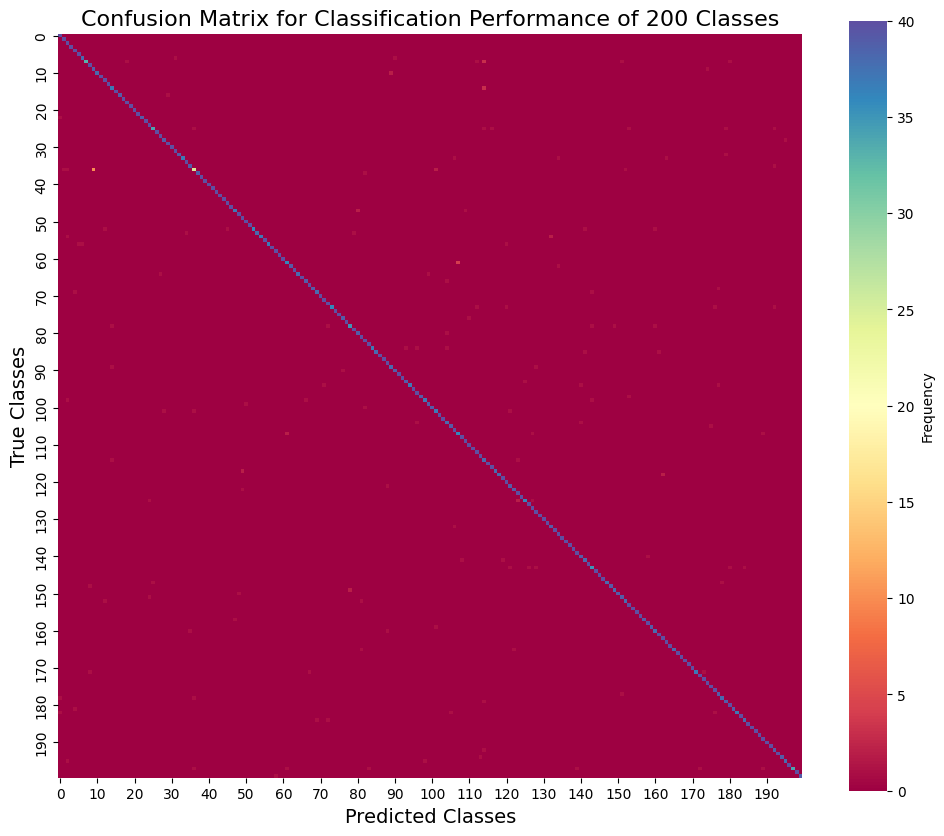

In [ ]:
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='selu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_selu.csv', index=False)

### Grafik Pengujian ViT-B/16


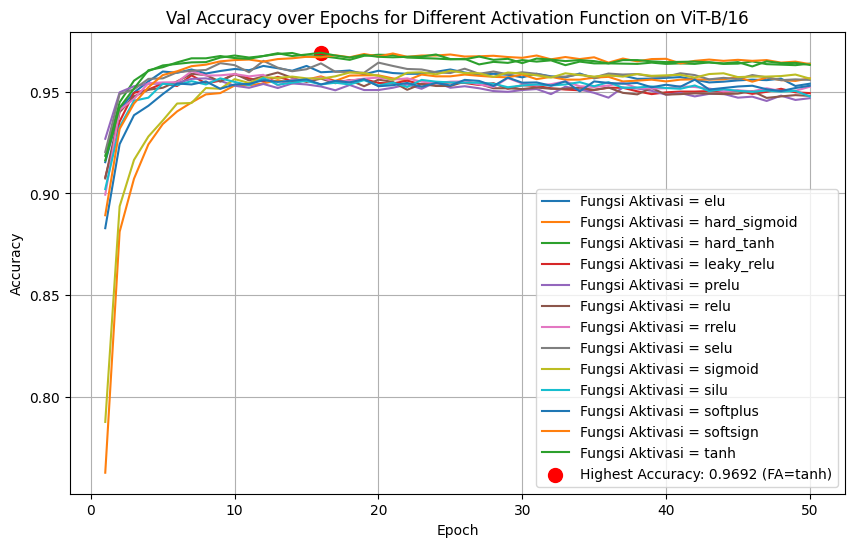

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_4_1024_elu.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/training_results_learning_rate_4_1024_hard_sigmoid.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/training_results_learning_rate_4_1024_hard_tanh.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/training_results_learning_rate_4_1024_leaky_relu.csv',       # Misalnya file hasil untuk learning rate 1
    '/content/training_results_learning_rate_4_1024_prelu.csv',
    '/content/training_results_learning_rate_4_1024_relu.csv',
    '/content/training_results_learning_rate_4_1024_rrelu.csv',
    '/content/training_results_learning_rate_4_1024_selu.csv',
    '/content/training_results_learning_rate_4_1024_sigmoid.csv',
    '/content/training_results_learning_rate_4_1024_silu.csv',
    '/content/training_results_learning_rate_4_1024_softplus.csv',
    '/content/training_results_learning_rate_4_1024_softsign.csv',
    '/content/training_results_learning_rate_4_1024_tanh.csv'
]

# Variabel untuk menyimpan label learning rate untuk setiap file
fungsi_aktivasi = ['elu', 'hard_sigmoid', 'hard_tanh', 'leaky_relu', 'prelu', 'relu', 'rrelu', 'selu', 'sigmoid', 'silu', 'softplus', 'softsign', 'tanh']

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_accuracy = 0
highest_epoch = 0
highest_activation_fn = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    accuracy = data['val_acc']

    # Plot akurasi vs epoch
    plt.plot(epochs, accuracy, label=f'Fungsi Aktivasi = {fungsi_aktivasi[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_accuracy = accuracy.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_accuracy > highest_accuracy:
        highest_accuracy = max_accuracy
        highest_epoch = max_epoch
        highest_activation_fn = fungsi_aktivasi[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_accuracy, color='red', s=100, label=f'Highest Accuracy: {highest_accuracy:.4f} (FA={highest_activation_fn})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy over Epochs for Different Activation Function on ViT-B/16')
plt.legend()
plt.grid(True)
plt.show()


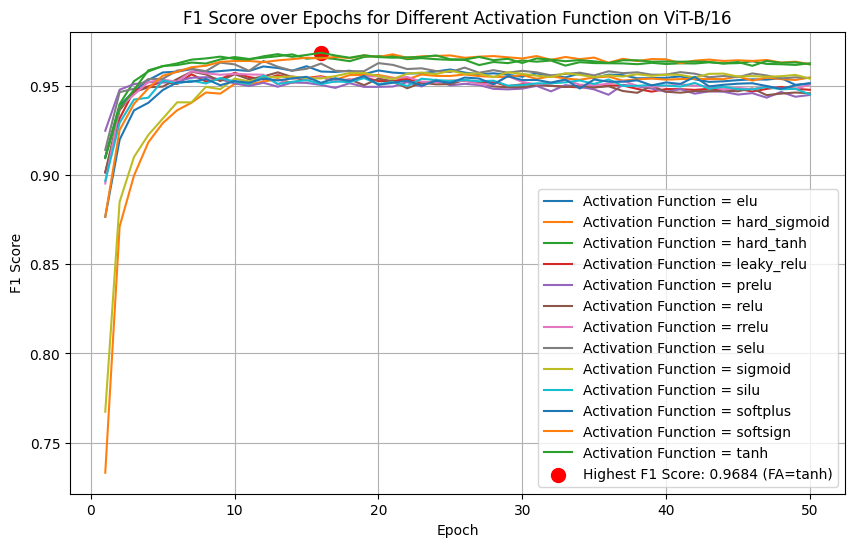

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_4_1024_elu.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/training_results_learning_rate_4_1024_hard_sigmoid.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/training_results_learning_rate_4_1024_hard_tanh.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/training_results_learning_rate_4_1024_leaky_relu.csv',       # Misalnya file hasil untuk learning rate 1
    '/content/training_results_learning_rate_4_1024_prelu.csv',
    '/content/training_results_learning_rate_4_1024_relu.csv',
    '/content/training_results_learning_rate_4_1024_rrelu.csv',
    '/content/training_results_learning_rate_4_1024_selu.csv',
    '/content/training_results_learning_rate_4_1024_sigmoid.csv',
    '/content/training_results_learning_rate_4_1024_silu.csv',
    '/content/training_results_learning_rate_4_1024_softplus.csv',
    '/content/training_results_learning_rate_4_1024_softsign.csv',
    '/content/training_results_learning_rate_4_1024_tanh.csv'
]

# Variabel untuk menyimpan label learning rate untuk setiap file
fungsi_aktivasi = ['elu', 'hard_sigmoid', 'hard_tanh', 'leaky_relu', 'prelu', 'relu', 'rrelu', 'selu', 'sigmoid', 'silu', 'softplus', 'softsign', 'tanh']

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_f1_score = 0
highest_epoch = 0
highest_activation_fn = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    f1_scores = data['val_f1']

    # Plot akurasi vs epoch
    plt.plot(epochs, f1_scores, label=f'Activation Function = {fungsi_aktivasi[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_f1_score = f1_scores.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_f1_score > highest_f1_score:
        highest_f1_score = max_f1_score
        highest_epoch = max_epoch
        highest_activation_fn= fungsi_aktivasi[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_f1_score, color='red', s=100, label=f'Highest F1 Score: {highest_f1_score:.4f} (FA={highest_activation_fn})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs for Different Activation Function on ViT-B/16')
plt.legend()
plt.grid(True)
plt.show()


### Grafik Pengujian ViT-L

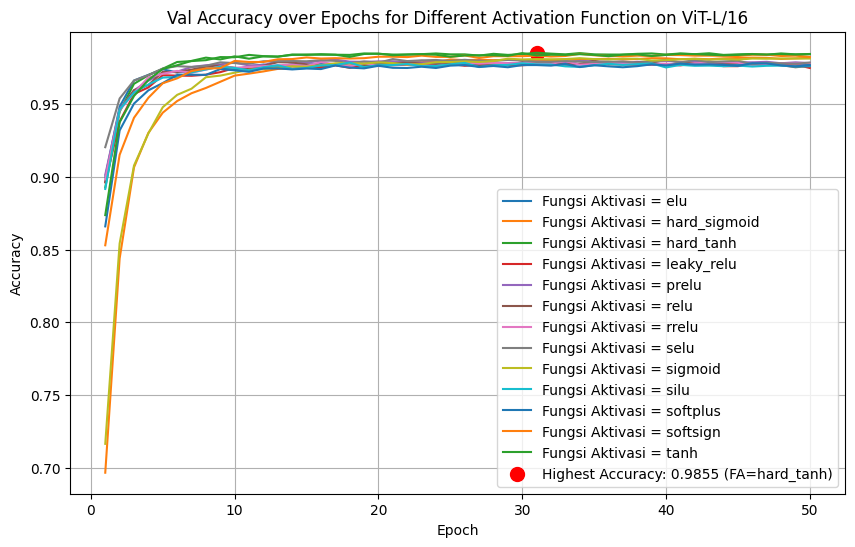

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_4_256_elu.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/training_results_learning_rate_4_256_hard_sigmoid.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/training_results_learning_rate_4_256_hard_tanh.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/training_results_learning_rate_4_256_leaky_relu.csv',       # Misalnya file hasil untuk learning rate 1
    '/content/training_results_learning_rate_4_256_prelu.csv',
    '/content/training_results_learning_rate_4_256_relu.csv',
    '/content/training_results_learning_rate_4_256_rrelu.csv',
    '/content/training_results_learning_rate_4_256_selu.csv',
    '/content/training_results_learning_rate_4_256_sigmoid.csv',
    '/content/training_results_learning_rate_4_256_silu.csv',
    '/content/training_results_learning_rate_4_256_softplus.csv',
    '/content/training_results_learning_rate_4_256_softsign.csv',
    '/content/training_results_learning_rate_4_256_tanh.csv'
]

# Variabel untuk menyimpan label learning rate untuk setiap file
fungsi_aktivasi = ['elu', 'hard_sigmoid', 'hard_tanh', 'leaky_relu', 'prelu', 'relu', 'rrelu', 'selu', 'sigmoid', 'silu', 'softplus', 'softsign', 'tanh']

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_accuracy = 0
highest_epoch = 0
highest_activation_fn = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    accuracy = data['val_acc']

    # Plot akurasi vs epoch
    plt.plot(epochs, accuracy, label=f'Fungsi Aktivasi = {fungsi_aktivasi[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_accuracy = accuracy.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_accuracy > highest_accuracy:
        highest_accuracy = max_accuracy
        highest_epoch = max_epoch
        highest_activation_fn = fungsi_aktivasi[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_accuracy, color='red', s=100, label=f'Highest Accuracy: {highest_accuracy:.4f} (FA={highest_activation_fn})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy over Epochs for Different Activation Function on ViT-L/16')
plt.legend()
plt.grid(True)
plt.show()


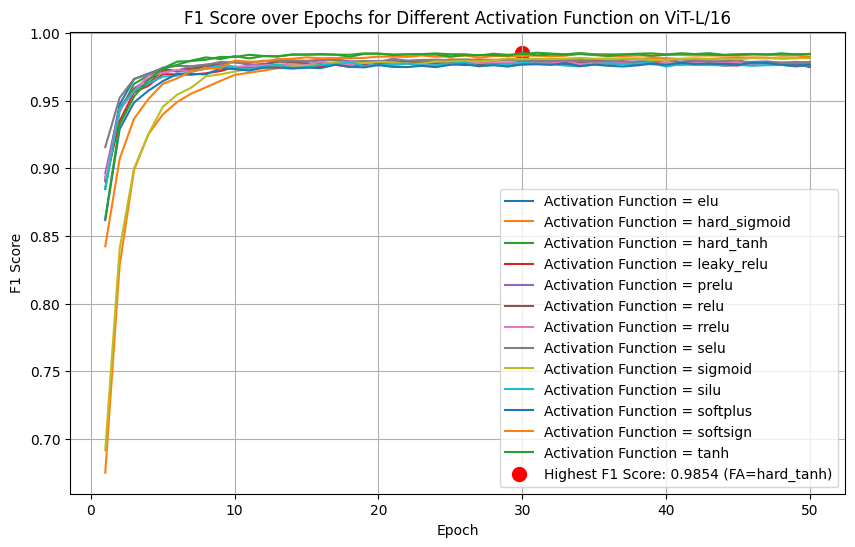

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_4_256_elu.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/training_results_learning_rate_4_256_hard_sigmoid.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/training_results_learning_rate_4_256_hard_tanh.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/training_results_learning_rate_4_256_leaky_relu.csv',       # Misalnya file hasil untuk learning rate 1
    '/content/training_results_learning_rate_4_256_prelu.csv',
    '/content/training_results_learning_rate_4_256_relu.csv',
    '/content/training_results_learning_rate_4_256_rrelu.csv',
    '/content/training_results_learning_rate_4_256_selu.csv',
    '/content/training_results_learning_rate_4_256_sigmoid.csv',
    '/content/training_results_learning_rate_4_256_silu.csv',
    '/content/training_results_learning_rate_4_256_softplus.csv',
    '/content/training_results_learning_rate_4_256_softsign.csv',
    '/content/training_results_learning_rate_4_256_tanh.csv'
]

# Variabel untuk menyimpan label learning rate untuk setiap file
fungsi_aktivasi = ['elu', 'hard_sigmoid', 'hard_tanh', 'leaky_relu', 'prelu', 'relu', 'rrelu', 'selu', 'sigmoid', 'silu', 'softplus', 'softsign', 'tanh']

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_f1_score = 0
highest_epoch = 0
highest_activation_fn = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    f1_scores = data['val_f1']

    # Plot akurasi vs epoch
    plt.plot(epochs, f1_scores, label=f'Activation Function = {fungsi_aktivasi[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_f1_score = f1_scores.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_f1_score > highest_f1_score:
        highest_f1_score = max_f1_score
        highest_epoch = max_epoch
        highest_activation_fn= fungsi_aktivasi[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_f1_score, color='red', s=100, label=f'Highest F1 Score: {highest_f1_score:.4f} (FA={highest_activation_fn})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs for Different Activation Function on ViT-L/16')
plt.legend()
plt.grid(True)
plt.show()


# Pengujian ViT-L/16

## Pengujian Learning rate

### Learning rate -6

Epoch 1/100, Train Loss: 5.4186, Train Acc: 0.0066, Train F1: 0.0038, Val Acc: 0.0089, Val F1: 0.0060, Time: 3.57s
Epoch 2/100, Train Loss: 5.2713, Train Acc: 0.0120, Train F1: 0.0082, Val Acc: 0.0169, Val F1: 0.0132, Time: 3.03s
Epoch 3/100, Train Loss: 5.1346, Train Acc: 0.0220, Train F1: 0.0166, Val Acc: 0.0289, Val F1: 0.0214, Time: 3.57s
Epoch 4/100, Train Loss: 5.0054, Train Acc: 0.0368, Train F1: 0.0291, Val Acc: 0.0467, Val F1: 0.0366, Time: 3.11s
Epoch 5/100, Train Loss: 4.8822, Train Acc: 0.0601, Train F1: 0.0502, Val Acc: 0.0722, Val F1: 0.0578, Time: 3.02s
Epoch 6/100, Train Loss: 4.7635, Train Acc: 0.0917, Train F1: 0.0778, Val Acc: 0.1106, Val F1: 0.0919, Time: 3.01s
Epoch 7/100, Train Loss: 4.6481, Train Acc: 0.1283, Train F1: 0.1102, Val Acc: 0.1496, Val F1: 0.1257, Time: 3.34s
Epoch 8/100, Train Loss: 4.5366, Train Acc: 0.1687, Train F1: 0.1461, Val Acc: 0.1913, Val F1: 0.1615, Time: 3.32s
Epoch 9/100, Train Loss: 4.4277, Train Acc: 0.2121, Train F1: 0.1871, Val Acc: 0

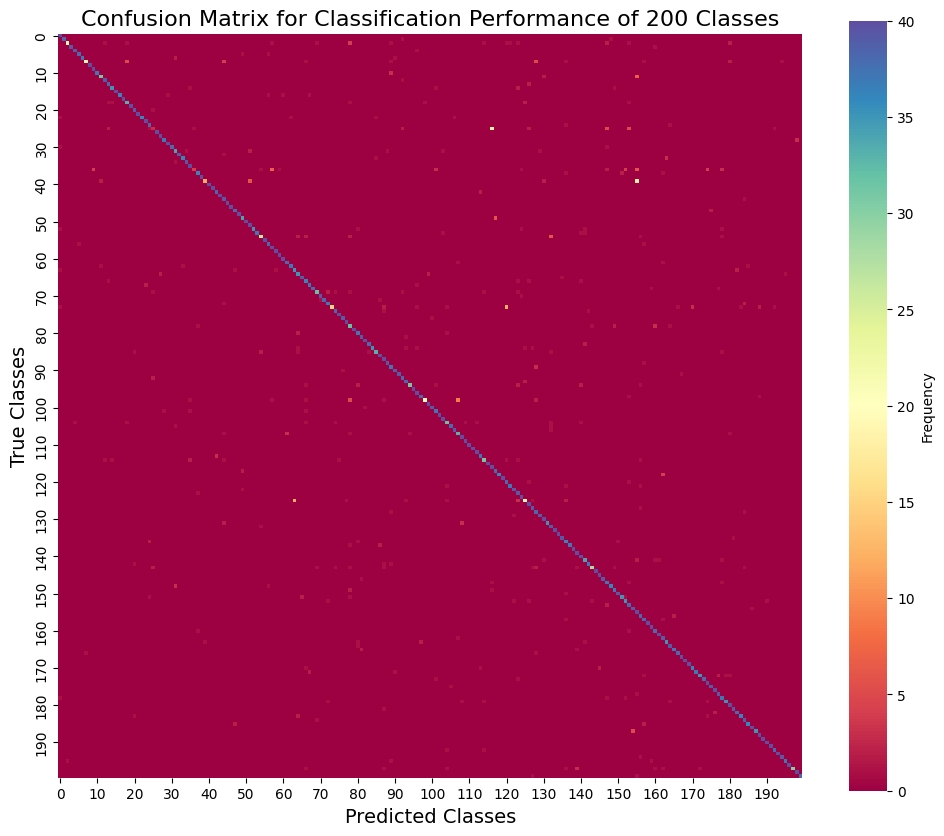

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_6.csv', index=False)

### Learningrate -5

Epoch 1/100, Train Loss: 4.9005, Train Acc: 0.0797, Train F1: 0.0723, Val Acc: 0.2575, Val F1: 0.2223, Time: 3.58s
Epoch 2/100, Train Loss: 3.8328, Train Acc: 0.4404, Train F1: 0.4214, Val Acc: 0.6242, Val F1: 0.5994, Time: 3.13s
Epoch 3/100, Train Loss: 3.0007, Train Acc: 0.6787, Train F1: 0.6683, Val Acc: 0.7711, Val F1: 0.7554, Time: 2.99s
Epoch 4/100, Train Loss: 2.3672, Train Acc: 0.7776, Train F1: 0.7714, Val Acc: 0.8356, Val F1: 0.8235, Time: 3.03s
Epoch 5/100, Train Loss: 1.8982, Train Acc: 0.8305, Train F1: 0.8271, Val Acc: 0.8688, Val F1: 0.8598, Time: 3.32s
Epoch 6/100, Train Loss: 1.5566, Train Acc: 0.8586, Train F1: 0.8566, Val Acc: 0.8898, Val F1: 0.8828, Time: 3.38s
Epoch 7/100, Train Loss: 1.3068, Train Acc: 0.8780, Train F1: 0.8773, Val Acc: 0.9048, Val F1: 0.8985, Time: 3.02s
Epoch 8/100, Train Loss: 1.1223, Train Acc: 0.8909, Train F1: 0.8906, Val Acc: 0.9154, Val F1: 0.9098, Time: 3.00s
Epoch 9/100, Train Loss: 0.9824, Train Acc: 0.9015, Train F1: 0.9016, Val Acc: 0

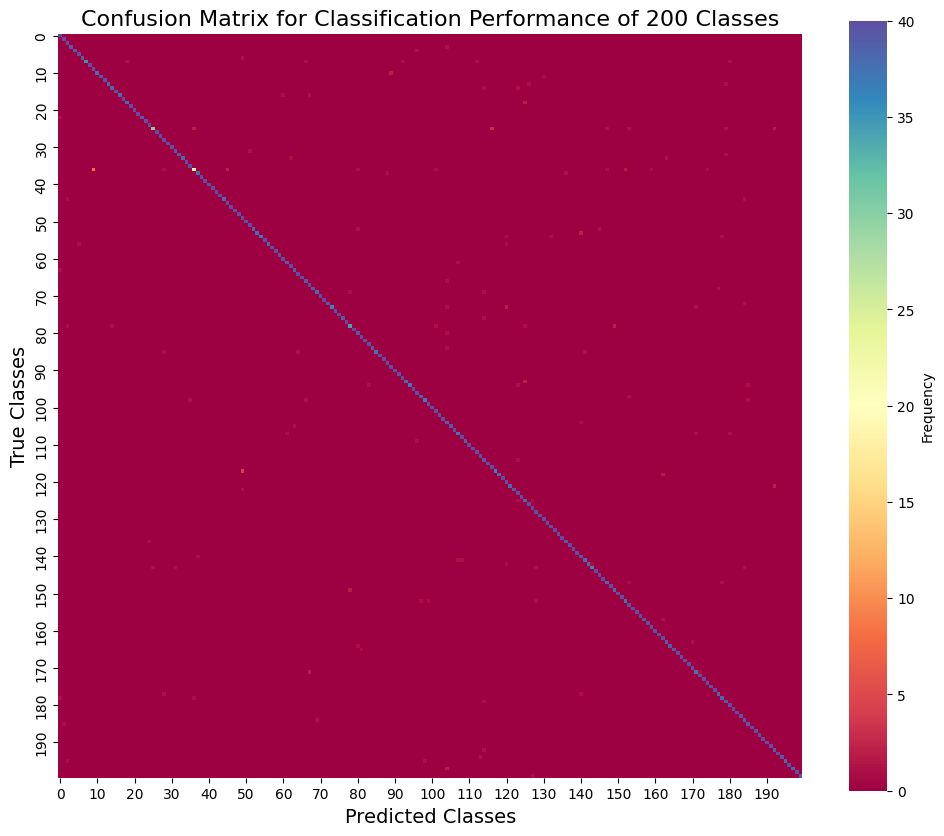

In [ ]:
hyperparams['learning_rate'] = 1e-5
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_5.csv', index=False)

### Learning rate -4

Epoch 1/100, Train Loss: 2.3178, Train Acc: 0.6525, Train F1: 0.6553, Val Acc: 0.9129, Val F1: 0.9070, Time: 3.34s
Epoch 2/100, Train Loss: 0.6338, Train Acc: 0.9164, Train F1: 0.9167, Val Acc: 0.9485, Val F1: 0.9461, Time: 3.01s
Epoch 3/100, Train Loss: 0.4030, Train Acc: 0.9427, Train F1: 0.9432, Val Acc: 0.9651, Val F1: 0.9638, Time: 3.60s
Epoch 4/100, Train Loss: 0.3128, Train Acc: 0.9540, Train F1: 0.9545, Val Acc: 0.9696, Val F1: 0.9689, Time: 3.19s
Epoch 5/100, Train Loss: 0.2627, Train Acc: 0.9617, Train F1: 0.9621, Val Acc: 0.9745, Val F1: 0.9741, Time: 3.03s
Epoch 6/100, Train Loss: 0.2287, Train Acc: 0.9661, Train F1: 0.9665, Val Acc: 0.9745, Val F1: 0.9740, Time: 3.01s
Epoch 7/100, Train Loss: 0.2063, Train Acc: 0.9698, Train F1: 0.9702, Val Acc: 0.9760, Val F1: 0.9757, Time: 3.35s
Epoch 8/100, Train Loss: 0.1874, Train Acc: 0.9720, Train F1: 0.9725, Val Acc: 0.9786, Val F1: 0.9783, Time: 3.36s
Epoch 9/100, Train Loss: 0.1707, Train Acc: 0.9747, Train F1: 0.9749, Val Acc: 0

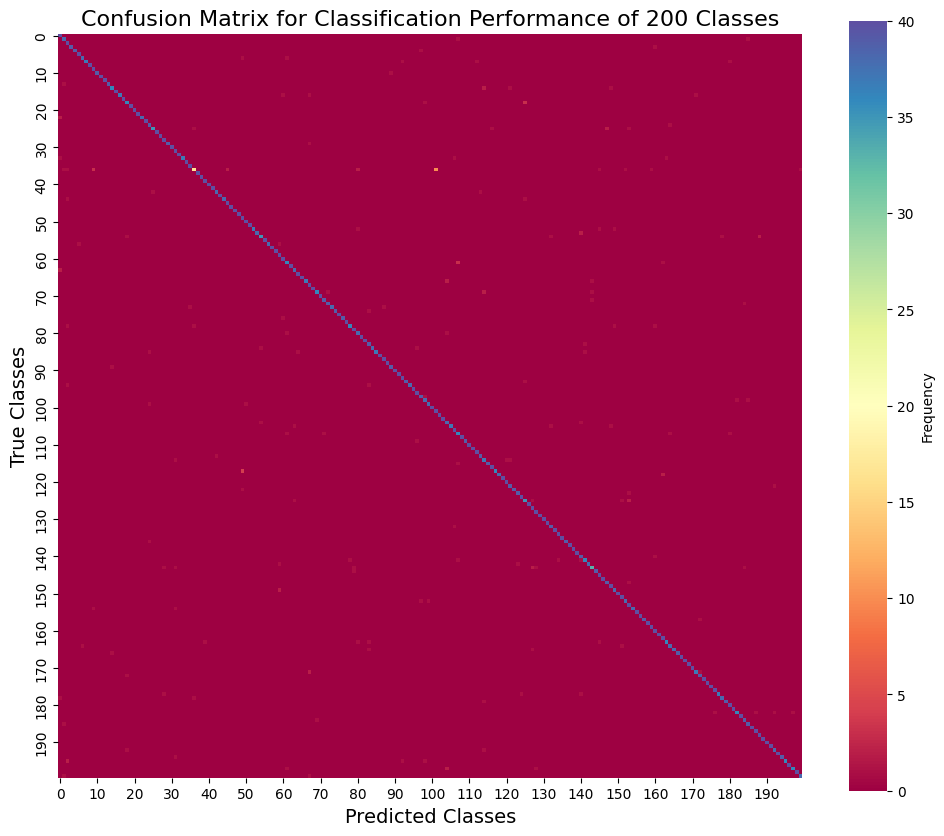

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4.csv', index=False)

### Learning rate -3

Epoch 1/100, Train Loss: 0.7037, Train Acc: 0.8570, Train F1: 0.8579, Val Acc: 0.9615, Val F1: 0.9595, Time: 3.04s
Epoch 2/100, Train Loss: 0.1925, Train Acc: 0.9572, Train F1: 0.9574, Val Acc: 0.9675, Val F1: 0.9673, Time: 3.01s
Epoch 3/100, Train Loss: 0.1341, Train Acc: 0.9707, Train F1: 0.9709, Val Acc: 0.9735, Val F1: 0.9733, Time: 3.52s
Epoch 4/100, Train Loss: 0.1030, Train Acc: 0.9785, Train F1: 0.9786, Val Acc: 0.9714, Val F1: 0.9710, Time: 3.18s
Epoch 5/100, Train Loss: 0.0857, Train Acc: 0.9820, Train F1: 0.9821, Val Acc: 0.9712, Val F1: 0.9710, Time: 3.01s
Epoch 6/100, Train Loss: 0.0695, Train Acc: 0.9852, Train F1: 0.9852, Val Acc: 0.9752, Val F1: 0.9751, Time: 3.06s
Epoch 7/100, Train Loss: 0.0625, Train Acc: 0.9862, Train F1: 0.9863, Val Acc: 0.9712, Val F1: 0.9707, Time: 3.36s
Epoch 8/100, Train Loss: 0.0514, Train Acc: 0.9892, Train F1: 0.9893, Val Acc: 0.9702, Val F1: 0.9701, Time: 3.40s
Epoch 9/100, Train Loss: 0.0473, Train Acc: 0.9908, Train F1: 0.9908, Val Acc: 0

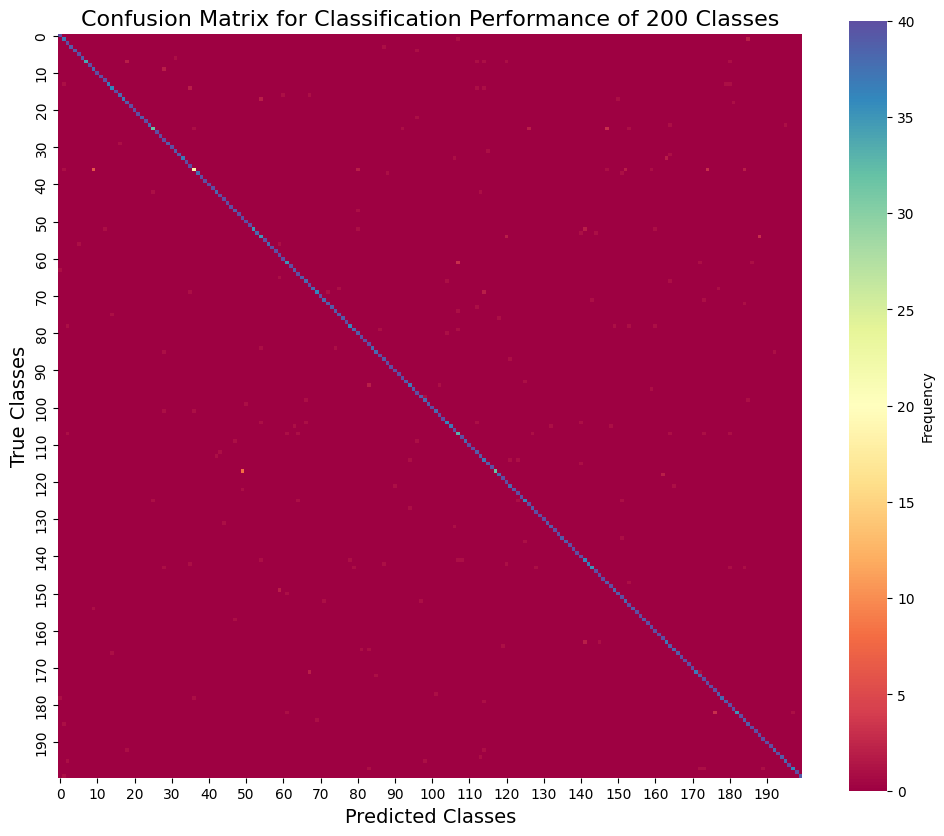

In [ ]:
hyperparams['learning_rate'] = 1e-3
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=0, activation_fn='relu').to(device)

num_epochs = 100
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_3.csv', index=False)

### Grafik Pengujian

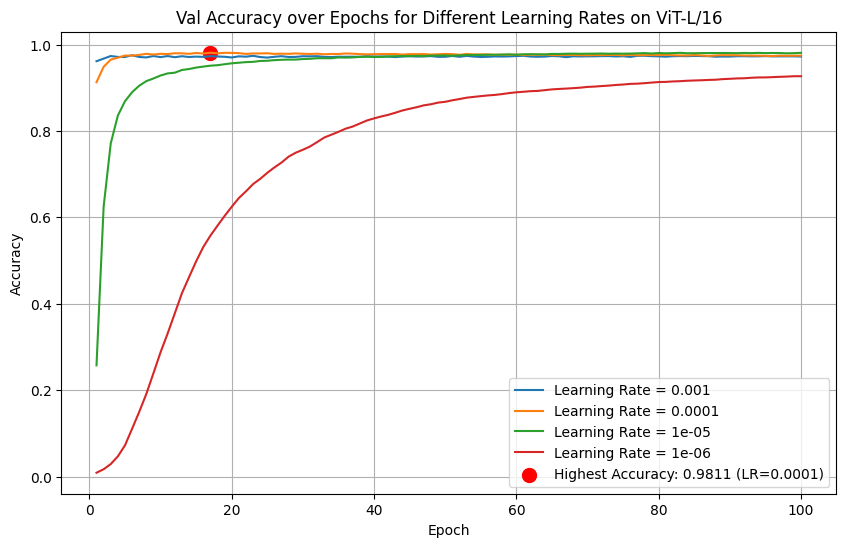

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_3.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_4.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_5.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_6.csv'       # Misalnya file hasil untuk learning rate 1
]

# Variabel untuk menyimpan label learning rate untuk setiap file
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_accuracy = 0
highest_epoch = 0
highest_lr = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    accuracy = data['val_acc']

    # Plot akurasi vs epoch
    plt.plot(epochs, accuracy, label=f'Learning Rate = {learning_rates[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_accuracy = accuracy.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_accuracy > highest_accuracy:
        highest_accuracy = max_accuracy
        highest_epoch = max_epoch
        highest_lr = learning_rates[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_accuracy, color='red', s=100, label=f'Highest Accuracy: {highest_accuracy:.4f} (LR={highest_lr})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy over Epochs for Different Learning Rates on ViT-L/16')
plt.legend()
plt.grid(True)
plt.show()


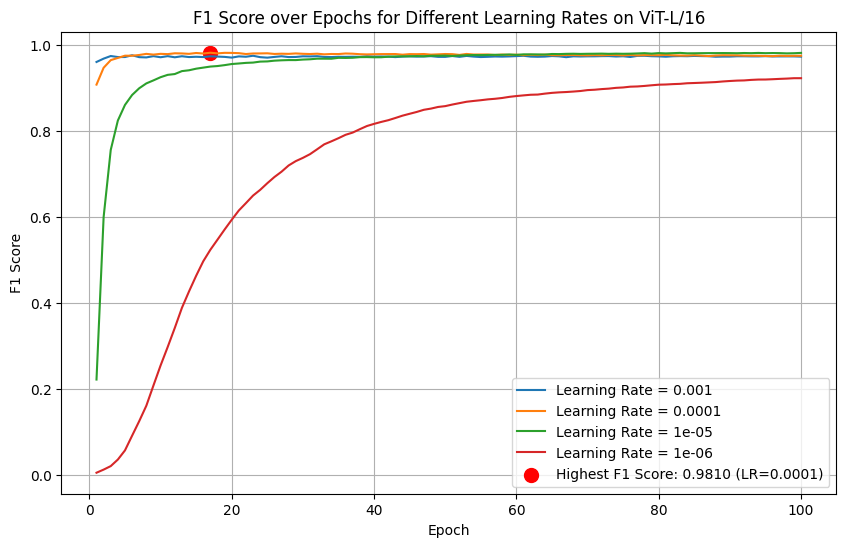

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_3.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_4.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_5.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/Hasil Pengujian ViT L/Learning Rate/training_results_learning_rate_6.csv'       # Misalnya file hasil untuk learning rate 1
]

# Variabel untuk menyimpan label learning rate untuk setiap file
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_f1_score = 0
highest_epoch = 0
highest_lr = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    f1_scores = data['val_f1']

    # Plot akurasi vs epoch
    plt.plot(epochs, f1_scores, label=f'Learning Rate = {learning_rates[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_f1_score = f1_scores.max()
    max_epoch = epochs[f1_scores.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_f1_score > highest_f1_score:
        highest_f1_score = max_f1_score
        highest_epoch = max_epoch
        highest_lr= learning_rates[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_f1_score, color='red', s=100, label=f'Highest F1 Score: {highest_f1_score:.4f} (LR={highest_lr})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs for Different Learning Rates on ViT-L/16')
plt.legend()
plt.grid(True)
plt.show()


## Pengujian jumlah neuron

### 64 Neuron

Epoch 1/50, Train Loss: 3.5383, Train Acc: 0.3759, Train F1: 0.3858, Val Acc: 0.7464, Val F1: 0.7281, Time: 3.36s
Epoch 2/50, Train Loss: 1.2449, Train Acc: 0.7921, Train F1: 0.7888, Val Acc: 0.8705, Val F1: 0.8645, Time: 3.69s
Epoch 3/50, Train Loss: 0.6725, Train Acc: 0.8730, Train F1: 0.8727, Val Acc: 0.9074, Val F1: 0.9040, Time: 5.23s
Epoch 4/50, Train Loss: 0.4702, Train Acc: 0.9065, Train F1: 0.9065, Val Acc: 0.9271, Val F1: 0.9242, Time: 7.28s
Epoch 5/50, Train Loss: 0.3627, Train Acc: 0.9249, Train F1: 0.9248, Val Acc: 0.9389, Val F1: 0.9363, Time: 7.17s
Epoch 6/50, Train Loss: 0.2963, Train Acc: 0.9376, Train F1: 0.9376, Val Acc: 0.9465, Val F1: 0.9449, Time: 5.19s
Epoch 7/50, Train Loss: 0.2481, Train Acc: 0.9478, Train F1: 0.9478, Val Acc: 0.9511, Val F1: 0.9501, Time: 4.76s
Epoch 8/50, Train Loss: 0.2129, Train Acc: 0.9563, Train F1: 0.9563, Val Acc: 0.9567, Val F1: 0.9560, Time: 6.86s
Epoch 9/50, Train Loss: 0.1844, Train Acc: 0.9617, Train F1: 0.9618, Val Acc: 0.9601, Va

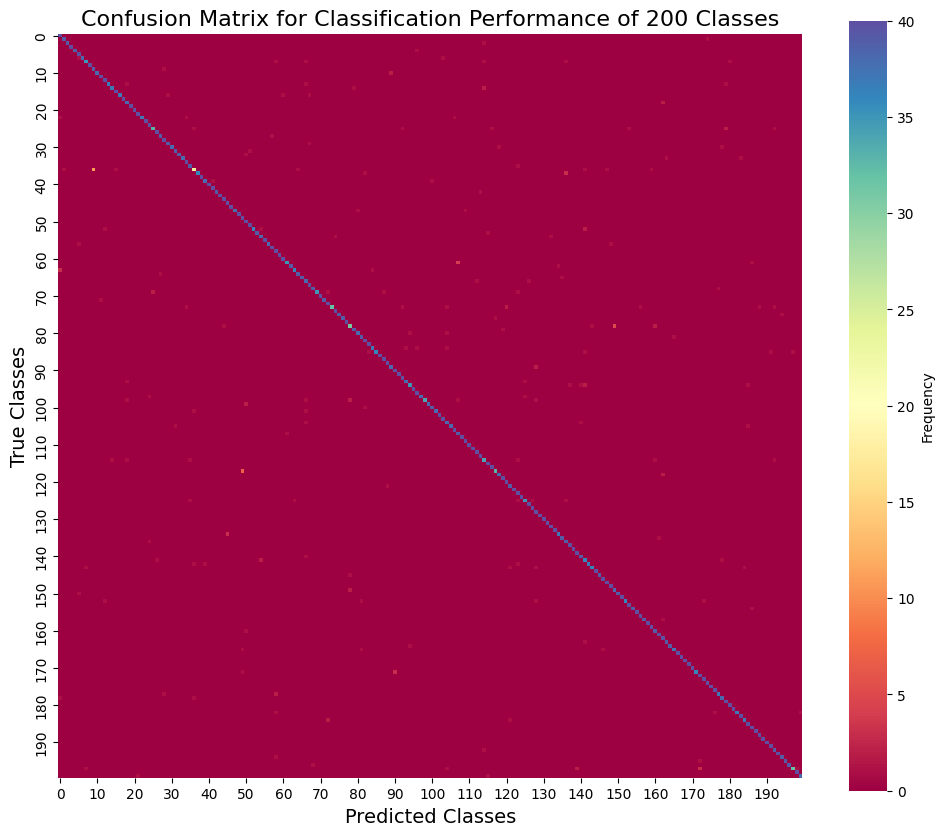

In [ ]:
hyperparams['learning_rate'] = 1e-4
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=64, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_64_neuron.csv', index=False)

### 128 Neuron

Epoch 1/50, Train Loss: 2.8390, Train Acc: 0.5255, Train F1: 0.5447, Val Acc: 0.8454, Val F1: 0.8359, Time: 3.41s
Epoch 2/50, Train Loss: 0.7466, Train Acc: 0.8715, Train F1: 0.8710, Val Acc: 0.9167, Val F1: 0.9141, Time: 3.91s
Epoch 3/50, Train Loss: 0.4133, Train Acc: 0.9203, Train F1: 0.9203, Val Acc: 0.9449, Val F1: 0.9429, Time: 4.02s
Epoch 4/50, Train Loss: 0.2888, Train Acc: 0.9427, Train F1: 0.9428, Val Acc: 0.9543, Val F1: 0.9532, Time: 3.40s
Epoch 5/50, Train Loss: 0.2173, Train Acc: 0.9561, Train F1: 0.9562, Val Acc: 0.9640, Val F1: 0.9636, Time: 3.61s
Epoch 6/50, Train Loss: 0.1723, Train Acc: 0.9665, Train F1: 0.9665, Val Acc: 0.9639, Val F1: 0.9633, Time: 4.06s
Epoch 7/50, Train Loss: 0.1398, Train Acc: 0.9727, Train F1: 0.9727, Val Acc: 0.9661, Val F1: 0.9657, Time: 3.37s
Epoch 8/50, Train Loss: 0.1157, Train Acc: 0.9781, Train F1: 0.9781, Val Acc: 0.9685, Val F1: 0.9682, Time: 3.48s
Epoch 9/50, Train Loss: 0.0962, Train Acc: 0.9818, Train F1: 0.9819, Val Acc: 0.9709, Va

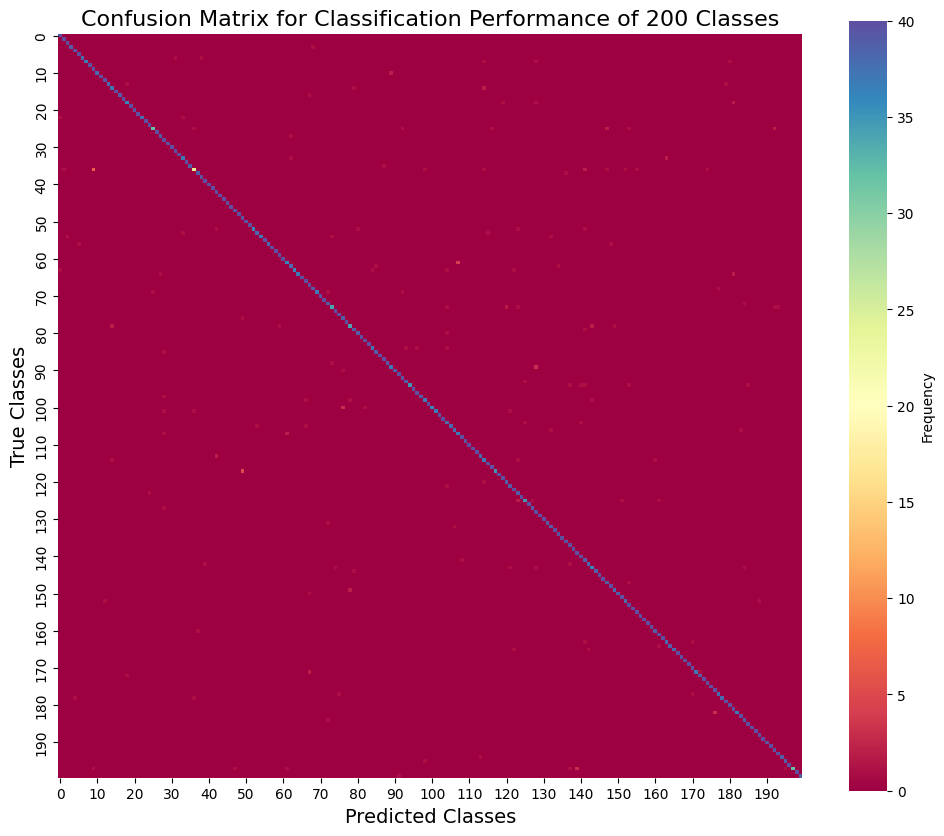

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=128, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_128_neuron.csv', index=False)

### 256 Neuron

Epoch 1/50, Train Loss: 2.1945, Train Acc: 0.6414, Train F1: 0.6511, Val Acc: 0.8992, Val F1: 0.8973, Time: 3.48s
Epoch 2/50, Train Loss: 0.4756, Train Acc: 0.9104, Train F1: 0.9104, Val Acc: 0.9416, Val F1: 0.9401, Time: 3.56s
Epoch 3/50, Train Loss: 0.2679, Train Acc: 0.9465, Train F1: 0.9466, Val Acc: 0.9615, Val F1: 0.9612, Time: 3.83s
Epoch 4/50, Train Loss: 0.1810, Train Acc: 0.9641, Train F1: 0.9642, Val Acc: 0.9634, Val F1: 0.9629, Time: 3.72s
Epoch 5/50, Train Loss: 0.1329, Train Acc: 0.9742, Train F1: 0.9743, Val Acc: 0.9694, Val F1: 0.9688, Time: 3.47s
Epoch 6/50, Train Loss: 0.0998, Train Acc: 0.9814, Train F1: 0.9814, Val Acc: 0.9712, Val F1: 0.9711, Time: 3.41s
Epoch 7/50, Train Loss: 0.0782, Train Acc: 0.9857, Train F1: 0.9857, Val Acc: 0.9751, Val F1: 0.9749, Time: 4.15s
Epoch 8/50, Train Loss: 0.0620, Train Acc: 0.9885, Train F1: 0.9885, Val Acc: 0.9751, Val F1: 0.9750, Time: 3.45s
Epoch 9/50, Train Loss: 0.0499, Train Acc: 0.9910, Train F1: 0.9910, Val Acc: 0.9749, Va

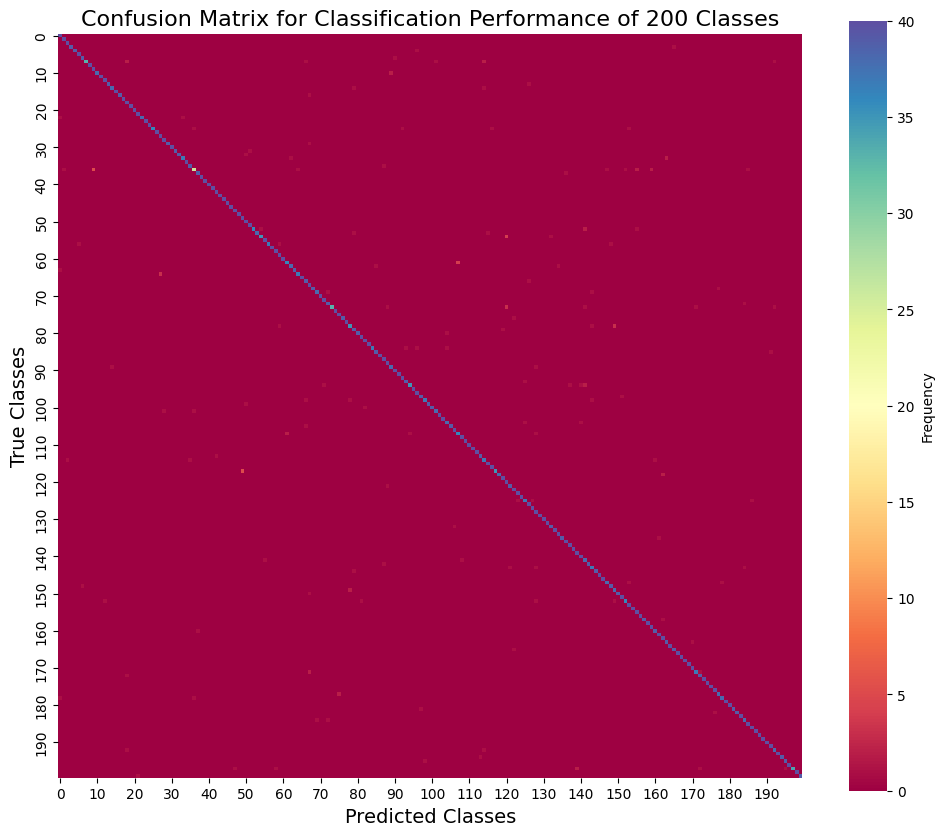

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=256, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_256_neuron.csv', index=False)

### 512 Neuron

Epoch 1/50, Train Loss: 1.6732, Train Acc: 0.7161, Train F1: 0.7214, Val Acc: 0.9263, Val F1: 0.9220, Time: 3.59s
Epoch 2/50, Train Loss: 0.3295, Train Acc: 0.9323, Train F1: 0.9323, Val Acc: 0.9591, Val F1: 0.9582, Time: 4.18s
Epoch 3/50, Train Loss: 0.1840, Train Acc: 0.9613, Train F1: 0.9613, Val Acc: 0.9720, Val F1: 0.9718, Time: 3.61s
Epoch 4/50, Train Loss: 0.1216, Train Acc: 0.9745, Train F1: 0.9745, Val Acc: 0.9709, Val F1: 0.9708, Time: 3.52s
Epoch 5/50, Train Loss: 0.0853, Train Acc: 0.9829, Train F1: 0.9829, Val Acc: 0.9752, Val F1: 0.9750, Time: 3.79s
Epoch 6/50, Train Loss: 0.0614, Train Acc: 0.9882, Train F1: 0.9882, Val Acc: 0.9736, Val F1: 0.9736, Time: 4.04s
Epoch 7/50, Train Loss: 0.0460, Train Acc: 0.9921, Train F1: 0.9921, Val Acc: 0.9758, Val F1: 0.9756, Time: 3.53s
Epoch 8/50, Train Loss: 0.0363, Train Acc: 0.9932, Train F1: 0.9932, Val Acc: 0.9746, Val F1: 0.9743, Time: 3.55s
Epoch 9/50, Train Loss: 0.0291, Train Acc: 0.9952, Train F1: 0.9952, Val Acc: 0.9770, Va

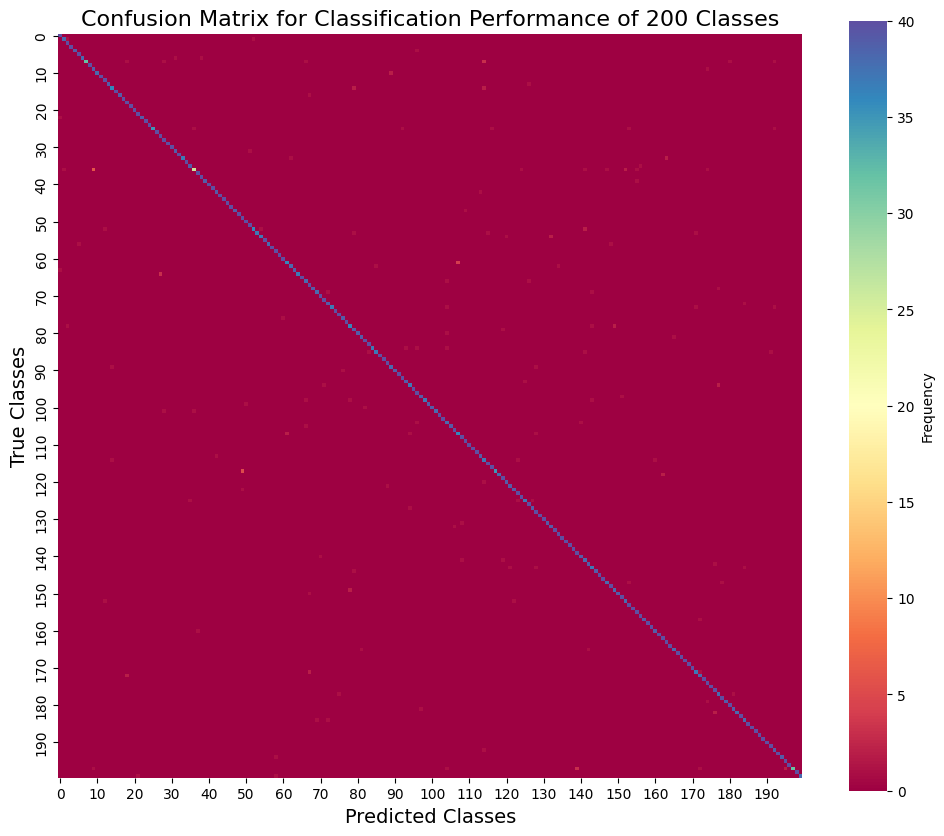

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=512, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_512_neuron.csv', index=False)

### 1024 Neuron

Epoch 1/50, Train Loss: 1.2990, Train Acc: 0.7682, Train F1: 0.7721, Val Acc: 0.9455, Val F1: 0.9439, Time: 3.90s
Epoch 2/50, Train Loss: 0.2414, Train Acc: 0.9454, Train F1: 0.9455, Val Acc: 0.9595, Val F1: 0.9587, Time: 4.26s
Epoch 3/50, Train Loss: 0.1322, Train Acc: 0.9705, Train F1: 0.9706, Val Acc: 0.9714, Val F1: 0.9711, Time: 3.73s
Epoch 4/50, Train Loss: 0.0829, Train Acc: 0.9818, Train F1: 0.9818, Val Acc: 0.9716, Val F1: 0.9715, Time: 3.80s
Epoch 5/50, Train Loss: 0.0552, Train Acc: 0.9889, Train F1: 0.9889, Val Acc: 0.9761, Val F1: 0.9760, Time: 4.37s
Epoch 6/50, Train Loss: 0.0389, Train Acc: 0.9922, Train F1: 0.9922, Val Acc: 0.9752, Val F1: 0.9751, Time: 3.87s
Epoch 7/50, Train Loss: 0.0303, Train Acc: 0.9942, Train F1: 0.9942, Val Acc: 0.9755, Val F1: 0.9755, Time: 3.74s
Epoch 8/50, Train Loss: 0.0237, Train Acc: 0.9951, Train F1: 0.9951, Val Acc: 0.9751, Val F1: 0.9748, Time: 4.06s
Epoch 9/50, Train Loss: 0.0202, Train Acc: 0.9965, Train F1: 0.9965, Val Acc: 0.9771, Va

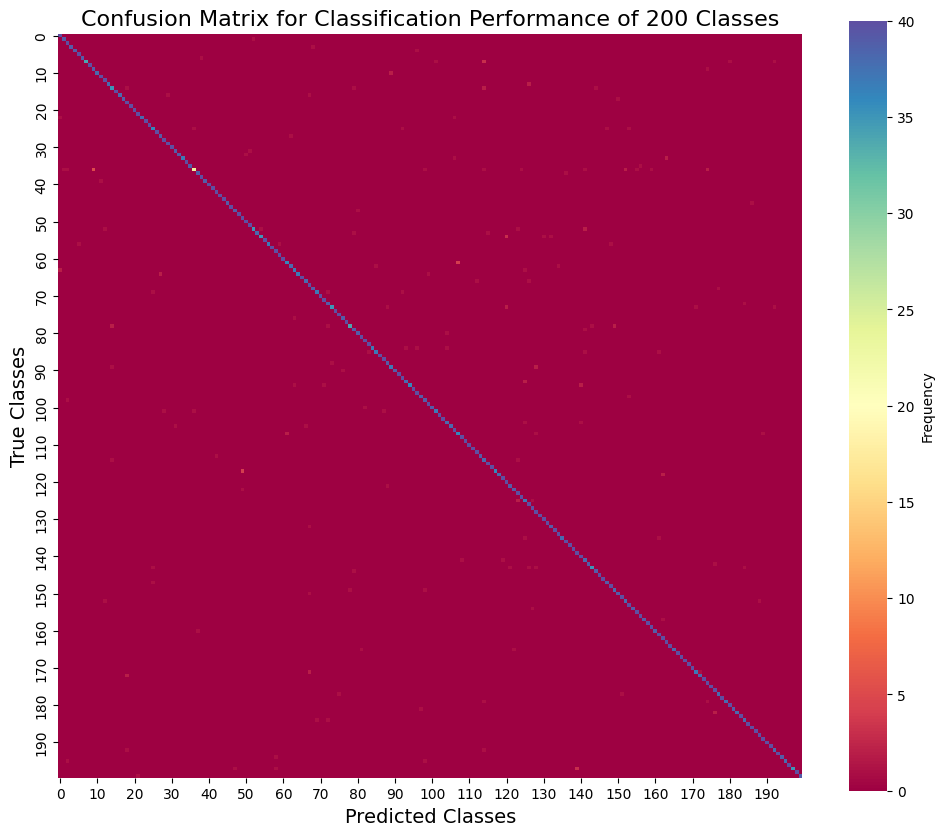

In [ ]:
num_classes = 200  # Sesuaikan dengan jumlah kelas yang ada
input_dim = train_data[0][0].shape[0]
model = SimpleClassifier(input_dim=input_dim, num_classes=num_classes, hidden_size=1024, activation_fn='relu').to(device)

num_epochs = 50
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results_learning_rate_4_1024_neuron.csv', index=False)

### Grafik Pengujian

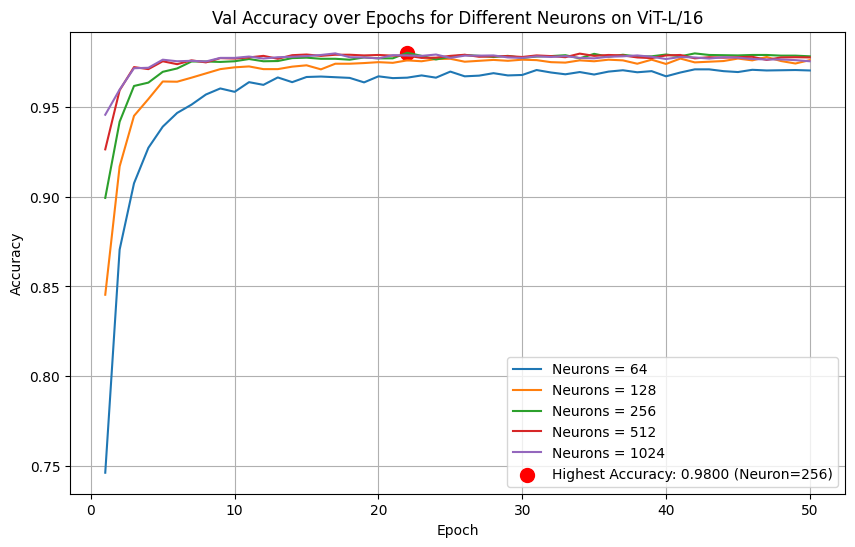

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_4_64_neuron.csv',  # Misalnya file hasil untuk learning rate 0.001
    '/content/training_results_learning_rate_4_128_neuron.csv',   # Misalnya file hasil untuk learning rate 0.01
    '/content/training_results_learning_rate_4_256_neuron.csv',    # Misalnya file hasil untuk learning rate 0.1
    '/content/training_results_learning_rate_4_512_neuron.csv',       # Misalnya file hasil untuk learning rate 1
    '/content/training_results_learning_rate_4_1024_neuron.csv'
]

# Variabel untuk menyimpan label learning rate untuk setiap file
neurons = [64, 128, 256, 512, 1024]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai akurasi dan epoch tertinggi secara keseluruhan
highest_accuracy = 0
highest_epoch = 0
highest_lr = None

# Loop untuk memuat setiap file CSV, lalu plot data akurasi vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'accuracy'
    epochs = data['epoch']
    accuracy = data['val_acc']

    # Plot akurasi vs epoch
    plt.plot(epochs, accuracy, label=f'Neurons = {neurons[i]}')

    # Menemukan akurasi tertinggi dalam file ini
    max_accuracy = accuracy.max()
    max_epoch = epochs[accuracy.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_accuracy > highest_accuracy:
        highest_accuracy = max_accuracy
        highest_epoch = max_epoch
        highest_neuron = neurons[i]

# Menambahkan tanda titik untuk akurasi tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_accuracy, color='red', s=100, label=f'Highest Accuracy: {highest_accuracy:.4f} (Neuron={highest_neuron})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy over Epochs for Different Neurons on ViT-L/16')
plt.legend()
plt.grid(True)
plt.show()


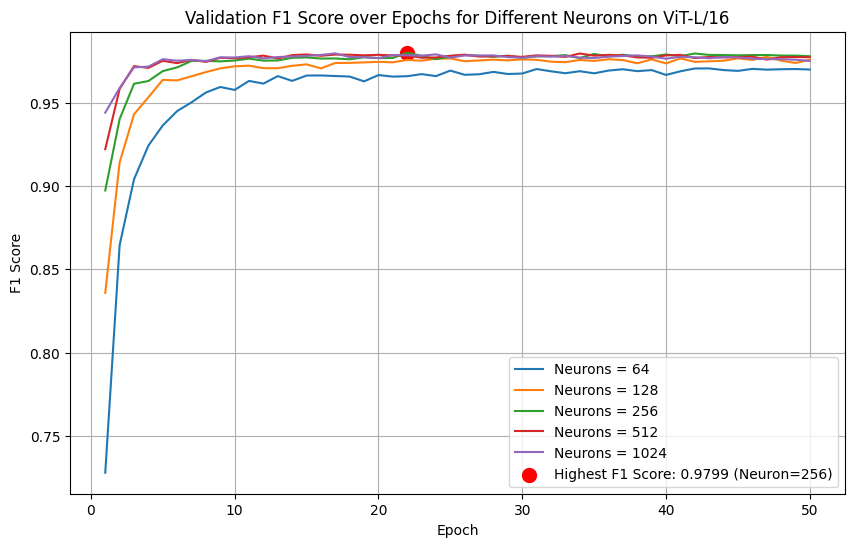

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nama file CSV yang akan dibaca
file_paths = [
    '/content/training_results_learning_rate_4_64_neuron.csv',  # File hasil untuk 64 neuron
    '/content/training_results_learning_rate_4_128_neuron.csv',  # File hasil untuk 128 neuron
    '/content/training_results_learning_rate_4_256_neuron.csv',  # File hasil untuk 256 neuron
    '/content/training_results_learning_rate_4_512_neuron.csv',  # File hasil untuk 512 neuron
    '/content/training_results_learning_rate_4_1024_neuron.csv'  # File hasil untuk 1024 neuron
]

# Variabel untuk menyimpan label neuron untuk setiap file
neurons = [64, 128, 256, 512, 1024]

# Membuat grafik
plt.figure(figsize=(10, 6))

# Variabel untuk menyimpan nilai F1-score dan epoch tertinggi secara keseluruhan
highest_f1_score = 0
highest_epoch = 0
highest_neuron = None

# Loop untuk memuat setiap file CSV, lalu plot data F1-score vs epoch
for i, file_path in enumerate(file_paths):
    # Membaca data dari file CSV
    data = pd.read_csv(file_path)

    # Pastikan file CSV memiliki kolom 'epoch' dan 'val_f1'
    epochs = data['epoch']
    f1_scores = data['val_f1']  # Pastikan kolom ini sesuai dengan nama kolom dalam file CSV Anda

    # Plot F1-score vs epoch
    plt.plot(epochs, f1_scores, label=f'Neurons = {neurons[i]}')

    # Menemukan F1-score tertinggi dalam file ini
    max_f1_score = f1_scores.max()
    max_epoch = epochs[f1_scores.idxmax()]

    # Menyimpan nilai tertinggi global
    if max_f1_score > highest_f1_score:
        highest_f1_score = max_f1_score
        highest_epoch = max_epoch
        highest_neuron = neurons[i]

# Menambahkan tanda titik untuk F1-score tertinggi dari keseluruhan data
plt.scatter(highest_epoch, highest_f1_score, color='red', s=100, label=f'Highest F1 Score: {highest_f1_score:.4f} (Neuron={highest_neuron})')

# Menambahkan label, judul, dan legend
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score over Epochs for Different Neurons on ViT-L/16')
plt.legend()
plt.grid(True)
plt.show()


# Komputasi

In [ ]:
import time
import os
import torch
import torch.nn as nn
from PIL import Image
import random
import csv
from torchvision import transforms, models

In [ ]:
# Path dataset dan model
dataset_path = r"/content/VNPlant_200_512"
vit_b_weights_path = r"/content/ViT-B_1024_Tanh.pth"
vit_l_weights_path = r"/content/ViT-L_256_Hard_Tanh.pth"

In [ ]:
# Fungsi untuk memuat model ViT dan weights
def load_vit_model(model_type, weights_path, input_dim=768, hidden_size=1024, activation_fn_name='tanh', num_classes=200):
    activation_fn = get_activation_fn(activation_fn_name)
    if model_type == 'vit_b_16':
        model = vit_b_16(pretrained=True)  # Tanpa pretrained
        model.heads = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            activation_fn,
            nn.Linear(hidden_size, num_classes)
        )
    elif model_type == 'vit_l_16':
        model = vit_l_16(pretrained=True)
        model.heads = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            activation_fn,
            nn.Linear(hidden_size, num_classes)
        )
    else:
        raise ValueError("Model type must be 'vit_b_16' or 'vit_l_16'")

    model.load_state_dict(torch.load(weights_path, map_location=device), strict=False)
    return model.to(device)

In [ ]:
# Fungsi preprocessing gambar
def process_image(image_path, model, device):
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Sesuaikan dengan resolusi input model ViT
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Model eval mode
    model.eval()

    # Hitung waktu komputasi
    start_time = time.time()
    with torch.no_grad():
        image_tensor = transform(image).unsqueeze(0).to(device)
        model(image_tensor)
    end_time = time.time()

    elapsed_time = end_time - start_time
    return image_path, elapsed_time

In [ ]:
def get_class_names(dataset_path):
    return sorted([name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))])

# Fungsi untuk memilih gambar acak dari direktori
def select_random_image_from_directory(dataset_path, class_names):
    class_name = random.choice(class_names)
    class_folder = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder):
        image_list = [img for img in os.listdir(class_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_list:
            return None  # Jika folder tidak berisi gambar
        image_name = random.choice(image_list)
        return os.path.join(class_folder, image_name)
    return None

# Fungsi untuk memilih sejumlah gambar acak
def select_random_images(dataset_path, class_names, num_images=100):
    images = []
    while len(images) < num_images:
        image_path = select_random_image_from_directory(dataset_path, class_names)
        if image_path:
            images.append(image_path)
    return images

In [ ]:
vit_b_model = load_vit_model(
    model_type='vit_b_16',
    weights_path=vit_b_weights_path,
    input_dim=768,
    hidden_size=1024,
    activation_fn_name='tanh',
    num_classes=200
)

# Muat model ViT-L/16
vit_l_model = load_vit_model(
    model_type='vit_l_16',
    weights_path=vit_l_weights_path,
    input_dim=1024,  # Dimensi input fitur ViT-L/16
    hidden_size=256,
    activation_fn_name='hard_tanh',
    num_classes=200
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-84-04909f17160b>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

In [ ]:
dataset_path = '/content/VNPlant_200_512/test'

class_names = get_class_names(dataset_path)

# Pilih 100 gambar acak
random_images = select_random_images(dataset_path, class_names, num_images=100)

In [ ]:
# Pengujian compute time
csv_filename = "compute_time_vit_b_16.csv"
with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['Image Path', 'Computation Time (s)']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    total_time = 0

    for image_path in random_images:
        print(f"Processing random image: {image_path}")

        # Hitung waktu komputasi menggunakan model ViT-B/16
        image_path, elapsed_time = process_image(image_path, vit_b_model, device)

        print(f"Computation time for {image_path}: {elapsed_time:.4f} seconds")

        writer.writerow({
            'Image Path': image_path,
            'Computation Time (s)': elapsed_time
        })

        total_time += elapsed_time

    average_time = total_time / len(random_images)
    print(f"Average computation time for all 100 images: {average_time:.4f} seconds")

Processing random image: /content/VNPlant_200_512/test/Psychotria rubra/57.JPG
Computation time for /content/VNPlant_200_512/test/Psychotria rubra/57.JPG: 0.0179 seconds
Processing random image: /content/VNPlant_200_512/test/Ageratum conyzoides/87.JPG
Computation time for /content/VNPlant_200_512/test/Ageratum conyzoides/87.JPG: 0.0146 seconds
Processing random image: /content/VNPlant_200_512/test/Curculigo orchioides/87.JPG
Computation time for /content/VNPlant_200_512/test/Curculigo orchioides/87.JPG: 0.0197 seconds
Processing random image: /content/VNPlant_200_512/test/Callisia fragrans/92.JPG
Computation time for /content/VNPlant_200_512/test/Callisia fragrans/92.JPG: 0.0212 seconds
Processing random image: /content/VNPlant_200_512/test/Sauropus androgynus/6.JPG
Computation time for /content/VNPlant_200_512/test/Sauropus androgynus/6.JPG: 0.0175 seconds
Processing random image: /content/VNPlant_200_512/test/Averrhoa carambola/91.JPG
Computation time for /content/VNPlant_200_512/tes

In [ ]:
# Pengujian compute time
csv_filename = "compute_time_vit_l_16.csv"
with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['Image Path', 'Computation Time (s)']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    total_time = 0

    for image_path in random_images:
        print(f"Processing random image: {image_path}")

        # Hitung waktu komputasi menggunakan model ViT-L/16
        image_path, elapsed_time = process_image(image_path, vit_l_model, device)

        print(f"Computation time for {image_path}: {elapsed_time:.4f} seconds")

        writer.writerow({
            'Image Path': image_path,
            'Computation Time (s)': elapsed_time
        })

        total_time += elapsed_time

    average_time_vit_l = total_time / len(random_images)
    print(f"Average computation time for all 100 images: {average_time_vit_l:.4f} seconds")

Processing random image: /content/VNPlant_200_512/test/Psychotria rubra/57.JPG
Computation time for /content/VNPlant_200_512/test/Psychotria rubra/57.JPG: 0.0318 seconds
Processing random image: /content/VNPlant_200_512/test/Ageratum conyzoides/87.JPG
Computation time for /content/VNPlant_200_512/test/Ageratum conyzoides/87.JPG: 0.0786 seconds
Processing random image: /content/VNPlant_200_512/test/Curculigo orchioides/87.JPG
Computation time for /content/VNPlant_200_512/test/Curculigo orchioides/87.JPG: 0.0591 seconds
Processing random image: /content/VNPlant_200_512/test/Callisia fragrans/92.JPG
Computation time for /content/VNPlant_200_512/test/Callisia fragrans/92.JPG: 0.0320 seconds
Processing random image: /content/VNPlant_200_512/test/Sauropus androgynus/6.JPG
Computation time for /content/VNPlant_200_512/test/Sauropus androgynus/6.JPG: 0.0442 seconds
Processing random image: /content/VNPlant_200_512/test/Averrhoa carambola/91.JPG
Computation time for /content/VNPlant_200_512/tes

In [ ]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Pengujian compute time
csv_filename = "compute_time_vit_b_16.csv"
with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['Image Path', 'Computation Time (s)']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    total_time = 0

    for image_path in random_images:
        print(f"Processing random image: {image_path}")

        # Hitung waktu komputasi menggunakan model ViT-B/16
        image_path, elapsed_time = process_image(image_path, vit_b_model, device)

        print(f"Computation time for {image_path}: {elapsed_time:.4f} seconds")

        writer.writerow({
            'Image Path': image_path,
            'Computation Time (s)': elapsed_time
        })

        total_time += elapsed_time

    cpu_average_time = total_time / len(random_images)
    print(f"Average computation time for all 100 images: {cpu_average_time:.4f} seconds")

Processing random image: /content/VNPlant_200_512/test/Pereskia Sacharosa/8.JPG
Computation time for /content/VNPlant_200_512/test/Pereskia Sacharosa/8.JPG: 0.9143 seconds
Processing random image: /content/VNPlant_200_512/test/Dicliptera chinensis/81.JPG
Computation time for /content/VNPlant_200_512/test/Dicliptera chinensis/81.JPG: 0.6382 seconds
Processing random image: /content/VNPlant_200_512/test/Polyscias fruticosa/66.JPG
Computation time for /content/VNPlant_200_512/test/Polyscias fruticosa/66.JPG: 1.0297 seconds
Processing random image: /content/VNPlant_200_512/test/Cordyline fruticosa/6.JPG
Computation time for /content/VNPlant_200_512/test/Cordyline fruticosa/6.JPG: 1.0476 seconds
Processing random image: /content/VNPlant_200_512/test/Vernonia amygdalina/48.JPG
Computation time for /content/VNPlant_200_512/test/Vernonia amygdalina/48.JPG: 1.0353 seconds
Processing random image: /content/VNPlant_200_512/test/Stachytarpheta jamaicensis/76.JPG
Computation time for /content/VNPla

In [ ]:
# Pengujian compute time
csv_filename = "compute_time_vit_l_16.csv"
with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['Image Path', 'Computation Time (s)']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    total_time = 0

    for image_path in random_images:
        print(f"Processing random image: {image_path}")

        # Hitung waktu komputasi menggunakan model ViT-L/16
        image_path, elapsed_time = process_image(image_path, vit_l_model, device)

        print(f"Computation time for {image_path}: {elapsed_time:.4f} seconds")

        writer.writerow({
            'Image Path': image_path,
            'Computation Time (s)': elapsed_time
        })

        total_time += elapsed_time

    cpu_average_time_vit_l = total_time / len(random_images)
    print(f"Average computation time for all 100 images: {cpu_average_time_vit_l:.4f} seconds")

Processing random image: /content/VNPlant_200_512/test/Pereskia Sacharosa/8.JPG
Computation time for /content/VNPlant_200_512/test/Pereskia Sacharosa/8.JPG: 2.6857 seconds
Processing random image: /content/VNPlant_200_512/test/Dicliptera chinensis/81.JPG
Computation time for /content/VNPlant_200_512/test/Dicliptera chinensis/81.JPG: 3.8706 seconds
Processing random image: /content/VNPlant_200_512/test/Polyscias fruticosa/66.JPG
Computation time for /content/VNPlant_200_512/test/Polyscias fruticosa/66.JPG: 2.5502 seconds
Processing random image: /content/VNPlant_200_512/test/Cordyline fruticosa/6.JPG
Computation time for /content/VNPlant_200_512/test/Cordyline fruticosa/6.JPG: 2.3869 seconds
Processing random image: /content/VNPlant_200_512/test/Vernonia amygdalina/48.JPG
Computation time for /content/VNPlant_200_512/test/Vernonia amygdalina/48.JPG: 2.4109 seconds
Processing random image: /content/VNPlant_200_512/test/Stachytarpheta jamaicensis/76.JPG
Computation time for /content/VNPla

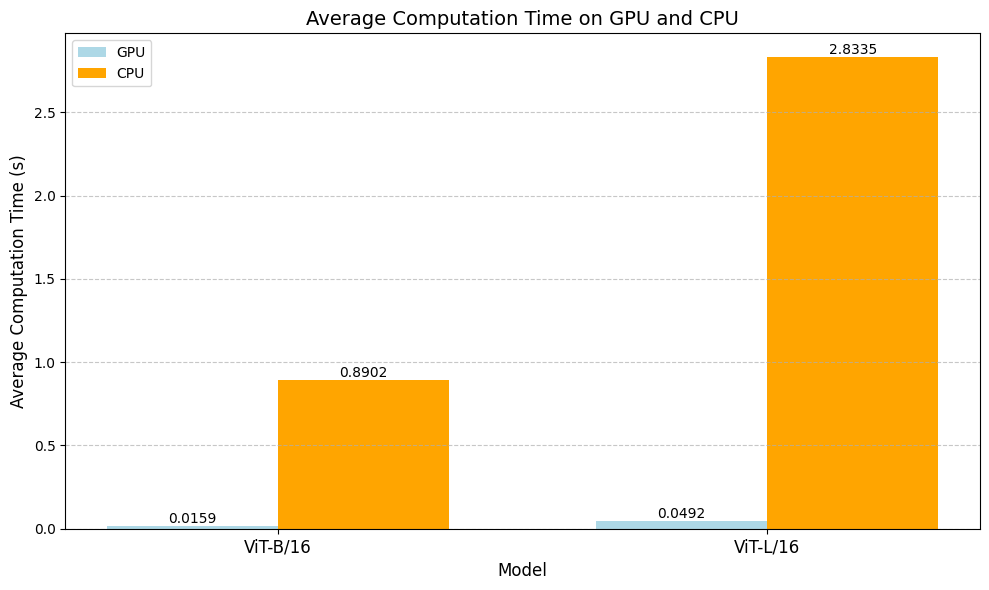

In [ ]:
# Visualisasi hasil waktu komputasi
import matplotlib.pyplot as plt
import numpy as np

# Contoh data untuk visualisasi
models = ['ViT-B/16', 'ViT-L/16']
gpu_times = [average_time, average_time_vit_l]  # Ganti dengan hasil waktu komputasi Anda
cpu_times = [cpu_average_time, cpu_average_time_vit_l]  # Ganti dengan hasil waktu komputasi CPU Anda

# Menentukan posisi untuk bar
x = np.arange(len(models))  # Posisi untuk bar

# Membuat plot
fig, ax = plt.subplots(figsize=(10, 6))

# Lebar bar
bar_width = 0.35

# Plot untuk GPU dan CPU
bars_gpu = ax.bar(x - bar_width/2, gpu_times, bar_width, label='GPU', color='lightblue')
bars_cpu = ax.bar(x + bar_width/2, cpu_times, bar_width, label='CPU', color='orange')

# Menambahkan label sumbu dan judul
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Average Computation Time (s)', fontsize=12)
ax.set_title('Average Computation Time on GPU and CPU', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Menampilkan nilai di atas bar
for bar in bars_gpu:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

for bar in bars_cpu:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Tampilkan grid untuk kemudahan membaca
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

# Training Model (OUTDATED)

# Evaluasi dan Training

In [ ]:
def evaluate(model, data_loader, criterion, print_confusion=False):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(nn.functional.softmax(outputs, dim=1).data, 1)

            # Calculate number of correct predictions using PyTorch
            total_correct += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Menghitung metrics
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)

    # Print Confusion Matrix
    if print_confusion:
        print("Confusion Matrix:")
        print(cm)

    return accuracy, f1, avg_loss, cm


In [ ]:
def train(model, train_loader, test_loader, num_epochs, hyperparams):
    optimizer = AdamW(model.parameters(), lr=hyperparams['learning_rate'], betas=hyperparams['optimizer_betas'])
    criterion = nn.CrossEntropyLoss()

    model.train()
    results = []

    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        start_time = time.time()

        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, preds = torch.max(nn.functional.softmax(outputs, dim=1).data, 1)
            total_correct += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        # Evaluasi
        train_acc = total_correct / total_samples
        train_loss = total_loss / len(train_loader)
        val_acc, val_f1, val_loss, cm = evaluate(model, test_loader, criterion, print_confusion=(epoch == num_epochs - 1))

        end_time = time.time()
        epoch_time = end_time - start_time

        results.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'epoch_time': epoch_time
        })

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}, Val F1-score: {val_f1:.4f}, Time: {epoch_time:.2f}s")

    results_df = pd.DataFrame(results)
    return results_df

## Learning Rate 10^-6

In [ ]:
num_epochs = 10
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results.csv', index=False)

print("\nTraining Selesai. Hasil disimpan ke 'training_results.csv'.")

Epoch 1/10, Train Loss: 5.4868, Train Acc: 0.0057, Val Loss: 5.4225 Val Acc: 0.0073, Val F1-score: 0.0057, Time: 2285.48s
Epoch 2/10, Train Loss: 5.3762, Train Acc: 0.0095, Val Loss: 5.3029 Val Acc: 0.0121, Val F1-score: 0.0096, Time: 1231.27s
Epoch 3/10, Train Loss: 5.2730, Train Acc: 0.0150, Val Loss: 5.1902 Val Acc: 0.0182, Val F1-score: 0.0144, Time: 1232.52s
Epoch 4/10, Train Loss: 5.1754, Train Acc: 0.0232, Val Loss: 5.0837 Val Acc: 0.0281, Val F1-score: 0.0230, Time: 1232.04s
Epoch 5/10, Train Loss: 5.0827, Train Acc: 0.0326, Val Loss: 4.9823 Val Acc: 0.0384, Val F1-score: 0.0317, Time: 1232.35s
Epoch 6/10, Train Loss: 4.9939, Train Acc: 0.0443, Val Loss: 4.8846 Val Acc: 0.0519, Val F1-score: 0.0436, Time: 1221.50s
Epoch 7/10, Train Loss: 4.9084, Train Acc: 0.0576, Val Loss: 4.7908 Val Acc: 0.0688, Val F1-score: 0.0574, Time: 1226.54s
Epoch 8/10, Train Loss: 4.8259, Train Acc: 0.0724, Val Loss: 4.7000 Val Acc: 0.0902, Val F1-score: 0.0753, Time: 1230.72s
Epoch 9/10, Train Loss: 

In [ ]:
num_epochs = 10
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results20.csv', index=False)

print("\nTraining Selesai. Hasil disimpan ke 'training_results.csv'.")

Epoch 1/10, Train Loss: 4.5929, Train Acc: 0.1324, Val Loss: 4.4432 Val Acc: 0.1638, Val F1-score: 0.1368, Time: 2276.08s
Epoch 2/10, Train Loss: 4.5190, Train Acc: 0.1557, Val Loss: 4.3617 Val Acc: 0.1878, Val F1-score: 0.1578, Time: 1235.37s
Epoch 3/10, Train Loss: 4.4467, Train Acc: 0.1789, Val Loss: 4.2816 Val Acc: 0.2155, Val F1-score: 0.1833, Time: 1234.92s
Epoch 4/10, Train Loss: 4.3760, Train Acc: 0.2013, Val Loss: 4.2035 Val Acc: 0.2435, Val F1-score: 0.2094, Time: 1234.30s
Epoch 5/10, Train Loss: 4.3068, Train Acc: 0.2223, Val Loss: 4.1273 Val Acc: 0.2692, Val F1-score: 0.2327, Time: 1233.46s
Epoch 6/10, Train Loss: 4.2392, Train Acc: 0.2441, Val Loss: 4.0526 Val Acc: 0.2983, Val F1-score: 0.2601, Time: 1235.02s
Epoch 7/10, Train Loss: 4.1731, Train Acc: 0.2676, Val Loss: 3.9797 Val Acc: 0.3249, Val F1-score: 0.2865, Time: 1235.66s
Epoch 8/10, Train Loss: 4.1083, Train Acc: 0.2900, Val Loss: 3.9078 Val Acc: 0.3530, Val F1-score: 0.3131, Time: 1236.48s
Epoch 9/10, Train Loss: 

## Learning rate 10^-5


In [ ]:
num_epochs = 10
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results.csv', index=False)

print("\nTraining Selesai. Hasil disimpan ke 'training_results.csv'.")

Epoch 1/10, Train Loss: 5.1758, Train Acc: 0.0255, Val Loss: 4.6398 Val Acc: 0.0959, Val F1-score: 0.0804, Time: 2291.36s
Epoch 2/10, Train Loss: 4.3582, Train Acc: 0.1981, Val Loss: 3.8524 Val Acc: 0.3765, Val F1-score: 0.3458, Time: 1241.17s
Epoch 3/10, Train Loss: 3.7192, Train Acc: 0.4262, Val Loss: 3.2117 Val Acc: 0.6075, Val F1-score: 0.5826, Time: 1236.33s
Epoch 4/10, Train Loss: 3.1940, Train Acc: 0.5837, Val Loss: 2.6885 Val Acc: 0.7261, Val F1-score: 0.7070, Time: 1234.07s
Epoch 5/10, Train Loss: 2.7671, Train Acc: 0.6674, Val Loss: 2.2691 Val Acc: 0.7846, Val F1-score: 0.7689, Time: 1234.95s
Epoch 6/10, Train Loss: 2.4220, Train Acc: 0.7145, Val Loss: 1.9349 Val Acc: 0.8203, Val F1-score: 0.8060, Time: 1237.94s
Epoch 7/10, Train Loss: 2.1458, Train Acc: 0.7507, Val Loss: 1.6698 Val Acc: 0.8416, Val F1-score: 0.8290, Time: 1235.35s
Epoch 8/10, Train Loss: 1.9241, Train Acc: 0.7746, Val Loss: 1.4584 Val Acc: 0.8579, Val F1-score: 0.8469, Time: 1237.77s
Epoch 9/10, Train Loss: 

## Learning rate 10^-4

In [ ]:
num_epochs = 10
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results.csv', index=False)

print("\nTraining Selesai. Hasil disimpan ke 'training_results.csv'.")

Epoch 1/10, Train Loss: 2.9885, Train Acc: 0.5159, Val Loss: 1.1892 Val Acc: 0.8620, Val F1-score: 0.8494, Time: 2361.81s
Epoch 2/10, Train Loss: 1.2302, Train Acc: 0.8225, Val Loss: 0.6035 Val Acc: 0.9204, Val F1-score: 0.9136, Time: 1274.14s
Epoch 3/10, Train Loss: 0.8834, Train Acc: 0.8604, Val Loss: 0.4307 Val Acc: 0.9305, Val F1-score: 0.9242, Time: 1278.57s
Epoch 4/10, Train Loss: 0.7377, Train Acc: 0.8805, Val Loss: 0.3511 Val Acc: 0.9423, Val F1-score: 0.9368, Time: 1269.61s
Epoch 5/10, Train Loss: 0.6508, Train Acc: 0.8948, Val Loss: 0.2986 Val Acc: 0.9464, Val F1-score: 0.9422, Time: 1276.68s
Epoch 6/10, Train Loss: 0.5923, Train Acc: 0.9025, Val Loss: 0.2759 Val Acc: 0.9466, Val F1-score: 0.9420, Time: 1276.21s
Epoch 7/10, Train Loss: 0.5489, Train Acc: 0.9087, Val Loss: 0.2517 Val Acc: 0.9487, Val F1-score: 0.9450, Time: 1276.77s
Epoch 8/10, Train Loss: 0.5147, Train Acc: 0.9140, Val Loss: 0.2308 Val Acc: 0.9571, Val F1-score: 0.9549, Time: 1274.84s
Epoch 9/10, Train Loss: 

## Learning Rate 10^-3

In [ ]:
num_epochs = 10
results_df = train(model, train_loader, test_loader, num_epochs, hyperparams)

results_df.to_csv('training_results.csv', index=False)

print("\nTraining Selesai. Hasil disimpan ke 'training_results.csv'.")

Epoch 1/10, Train Loss: 1.1788, Train Acc: 0.7609, Val Loss: 0.2591 Val Acc: 0.9351, Val F1-score: 0.9327, Time: 2351.54s
Epoch 2/10, Train Loss: 0.5006, Train Acc: 0.8930, Val Loss: 0.1912 Val Acc: 0.9484, Val F1-score: 0.9464, Time: 1261.72s
Epoch 3/10, Train Loss: 0.3905, Train Acc: 0.9178, Val Loss: 0.1906 Val Acc: 0.9500, Val F1-score: 0.9479, Time: 1263.15s
Epoch 4/10, Train Loss: 0.3243, Train Acc: 0.9300, Val Loss: 0.1833 Val Acc: 0.9513, Val F1-score: 0.9487, Time: 1266.27s
Epoch 5/10, Train Loss: 0.2809, Train Acc: 0.9390, Val Loss: 0.1910 Val Acc: 0.9499, Val F1-score: 0.9476, Time: 1263.15s
Epoch 6/10, Train Loss: 0.2492, Train Acc: 0.9467, Val Loss: 0.2051 Val Acc: 0.9500, Val F1-score: 0.9476, Time: 1263.94s
Epoch 7/10, Train Loss: 0.2229, Train Acc: 0.9516, Val Loss: 0.2034 Val Acc: 0.9493, Val F1-score: 0.9475, Time: 1263.32s
Epoch 8/10, Train Loss: 0.2118, Train Acc: 0.9533, Val Loss: 0.2148 Val Acc: 0.9484, Val F1-score: 0.9472, Time: 1259.61s
Epoch 9/10, Train Loss: 